<a href="https://colab.research.google.com/github/timmpfe/Factor-Based-Analysis-of-Cryptocurrency-Returns/blob/main/Final_Version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.formula.api as smp
import statsmodels.regression.linear_model as rg
import statsmodels.tools.tools as ct
import statsmodels.stats.diagnostic as dg
import statsmodels.formula.api as smf
from statsmodels import regression
from statsmodels.regression.rolling import RollingOLS

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats.mstats import winsorize
import matplotlib.pyplot as plt

import scipy
from scipy import stats

In [ ]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


# Dataset cleaning and first calculations

In [ ]:
initial_df = pd.read_csv('/drive/My Drive/Colab Notebooks/fin_short.csv')

In [ ]:
initial_df['date'] = pd.to_datetime(initial_df['date'])

In [ ]:
initial_df

,date,name_symbol,price,volume_24h,circulating_supply,market_cap,pct_change_24h,pct_change_7d
0,2013-04-28,BITCOIN BTC,1.342100e+02,0.0,11091325.00,1.488567e+09,NaN,NaN
1,2013-04-28,LITECOIN LTC,4.348405e+00,0.0,17164230.00,7.463702e+07,NaN,NaN
2,2013-04-28,PEERCOIN PPC,3.865249e-01,0.0,18757362.00,7.250187e+06,NaN,NaN
3,2013-04-28,NAMECOIN NMC,1.107233e+00,0.0,5415300.00,5.995997e+06,NaN,NaN
4,2013-04-28,TERRACOIN TRC,6.468923e-01,0.0,2323569.75,1.503099e+06,NaN,NaN
...,...,...,...,...,...,...,...,...
8288541,2022-10-15,BABY-FPS-TOKEN BFPS,6.775802e-05,0.0,0.00,0.000000e+00,0.000000,-29.800288
8288542,2022-10-15,ALEX-LAB ALEX,2.023764e-02,0.0,0.00,0.000000e+00,-1.788206,0.000000
8288543,2022-10-15,RETAWARS-GOLDROSE-TOKEN GRT,1.494837e-02,0.0,0.00,0.000000e+00,0.000000,0.034392
8288544,2022-10-15,AMETA APLUS,4.831760e-03,0.0,0.00,0.000000e+00,-8.270602,0.000000


In [ ]:
initial_df['pct_change_24h'] /= 100
initial_df['pct_change_7d'] /= 100

In [ ]:
def winsorize_series(s):
    return s.clip(lower=s.quantile(0.01, interpolation='lower'), 
                  upper=s.quantile(0.99, interpolation='higher'))

def winsorize_df(df):
    return df.apply(winsorize_series, axis=0)


def group_p_change(group):
  group['pct_change'] = group['price'].pct_change()
  return group


def winsorize_group(group):
  #group['pct_change_7d'] = winsorize_series(group['pct_change_7d'])
  #group['pct_change_24h'] = winsorize_series(group['pct_change_24h'])
  group['pct_change'] = winsorize_series(group['pct_change'])
  return group


def cumret_group(group):
  group['cumret'] = group['pct_change']+1
  group['cumret'].iloc[0] = 1
  group['cumret'] = group['cumret'].cumprod()
  return group

In [ ]:
initial_df = initial_df.groupby('name_symbol').apply(group_p_change)

In [ ]:
wins = initial_df.groupby('date').apply(winsorize_group)

In [ ]:
wins = wins.groupby('name_symbol').apply(cumret_group)

In [ ]:
y = pd.pivot_table(data= wins, columns='name_symbol', values='cumret', index='date')

In [ ]:
initial_df.groupby('date')['name_symbol'].count().to_frame()


,name_symbol
date,
2013-04-28,7
2013-04-29,7
2013-04-30,7
2013-05-01,7
2013-05-02,7
...,...
2022-10-11,9390
2022-10-12,9391
2022-10-13,9396


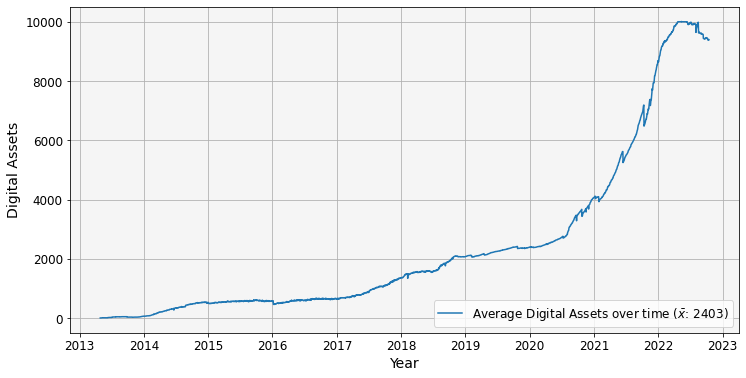

In [ ]:
count = (initial_df
         .groupby('date')['name_symbol']
         .count()
         .to_frame())
mean = count.mean().astype(int)['name_symbol']
plt.figure(figsize=(12,6))
plt.grid(True)
plt.plot(initial_df.groupby('date')['name_symbol'].count().to_frame(), 
         label='Average Digital Assets over time ('+ r'$\bar{x}$' + f': {mean})')
plt.legend(loc='lower right')
plt.ylabel('Digital Assets', 
           fontsize=14)
plt.xlabel('Year', 
           fontsize=14)
#plt.yticks(c['id'].values[::2000])
plt.rc('axes', 
       labelsize=12)    # fontsize of the x and y labels
plt.rc('legend', 
       fontsize=12)    # legend fontsize
plt.rc('xtick', 
       labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', 
       labelsize=12)    # fontsize of the tick labels
plt.savefig('/drive/My Drive/Colab Notebooks/Initial_Dataset.png', dpi=300)

In [ ]:
prices = initial_df[['date', 'name_symbol', 'price']]
prices = pd.pivot_table(prices, index='date', columns='name_symbol',values='price')

In [ ]:
prices.replace(to_replace=0, value=np.nan, inplace=True)

In [ ]:
prices.interpolate(limit_direction='both',
                  limit_area='inside',
                  methode='time',
                  limit=5,
                  inplace=True)

In [ ]:
prices.max().nlargest()

name_symbol
TRAVEL1CLICK T1C       1.513989e+10
FOUR-EMPERORS YONKŌ    1.497753e+08
YOUVES UUSD            7.103651e+07
ONLY-1-TOKEN O1T       6.419264e+06
SQUIDDAO SQUID         3.935587e+06
dtype: float64

In [ ]:
prices.min().nsmallest()

name_symbol
BABYKITTY BABYKITTY          1.000000e-20
BNBTIGER BNBTIGER            1.000000e-20
DOGEQUEEN DOGEQUEEN          1.000000e-20
FIRSTHARE FirstHare          1.000000e-20
MOONLIGHT-TOKEN MOONLIGHT    1.000000e-20
dtype: float64

In [ ]:
circulating_supply = initial_df[['date', 'name_symbol', 'circulating_supply']]
circulating_supply = pd.pivot_table(circulating_supply, index='date', columns='name_symbol', values='circulating_supply')

In [ ]:
dcirculating_supply = circulating_supply.abs()

In [ ]:
circulating_supply.interpolate(limit_direction='both',
                                  limit_area='inside',
                                  methode='time',
                                  limit=5,
                                  inplace=True)

In [ ]:
circulating_supply

name_symbol,00-TOKEN 00,007COIN 007,01COIN ZOC,0CASH ZCH,0CHAIN ZCN,0X ZRX,0X-NODES BIOS,0XBTC 0xBTC,0XCERT ZXC,0XDAO OXD,...,ZURRENCY ZURR,ZUSD ZUSD,ZUZ-PROTOCOL ZUZ,ZVCHAIN ZVC,ZYNECOIN ZYN,ZYRO ZYRO,ZYTARA-DOLLAR ZUSD,ZYX ZYX,ZZZ-FINANCE ZZZ,ZZZ-FINANCE-V2 ZZZV2
date,,,,,,,,,,,,,,,,,,,,,
2013-04-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-05-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-11,0.0,NaN,0.0,NaN,48400982.0,8.474961e+08,0.0,9706750.0,NaN,0.0,...,0.0,1472237.0,NaN,NaN,3.271319e+07,0.0,NaN,0.0,NaN,NaN
2022-10-12,0.0,NaN,0.0,NaN,48400982.0,8.474961e+08,0.0,9706750.0,NaN,0.0,...,0.0,1472237.0,NaN,NaN,3.271319e+07,0.0,NaN,0.0,NaN,NaN
2022-10-13,0.0,NaN,0.0,NaN,48400982.0,8.474961e+08,0.0,9706750.0,NaN,0.0,...,0.0,1472237.0,NaN,NaN,3.271319e+07,0.0,NaN,0.0,NaN,NaN


In [ ]:
volume = initial_df[['date', 'name_symbol', 'volume_24h']]

In [ ]:
volume = pd.pivot_table(volume, index='date', columns='name_symbol', values='volume_24h')

In [ ]:
volume.interpolate(limit_direction='both',
                                  limit_area='inside',
                                  methode='time',
                                  limit=5,
                                  inplace=True)

Adjustment for survivorship bias

In [ ]:
def group_pct_change(group):
  group['log_change'] = np.log(group['price']) - np.log(group['price'].shift(1))
  return group

In [ ]:
def group_p_change(group):
  group['pct_change'] = group['price'].pct_change()
  return group

In [ ]:
prices = prices.stack().to_frame()
prices.reset_index(inplace=True)

prices.rename(columns={0:'price'}, inplace=True)

In [ ]:
pct_change = prices.groupby('name_symbol').apply(group_pct_change)

In [ ]:
pct_change = pct_change.groupby('name_symbol').apply(group_p_change)

In [ ]:
pct_change[pct_change['name_symbol']=='BITCOIN BTC']

,date,name_symbol,price,log_change,pct_change
0,2013-04-28,BITCOIN BTC,134.210022,NaN,NaN
7,2013-04-29,BITCOIN BTC,144.539993,0.074150,0.076969
14,2013-04-30,BITCOIN BTC,139.000031,-0.039082,-0.038328
21,2013-05-01,BITCOIN BTC,116.990021,-0.172386,-0.158345
28,2013-05-02,BITCOIN BTC,105.209999,-0.106130,-0.100693
...,...,...,...,...,...
8307855,2022-10-11,BITCOIN BTC,19051.418269,-0.004716,-0.004705
8317256,2022-10-12,BITCOIN BTC,19157.446287,0.005550,0.005565
8326656,2022-10-13,BITCOIN BTC,19382.904034,0.011700,0.011769
8336054,2022-10-14,BITCOIN BTC,19185.656700,-0.010228,-0.010176


In [ ]:
circ_sup = circulating_supply.stack().to_frame()
circ_sup.reset_index(inplace=True)
circ_sup.rename(columns={0:'circulating_supply'}, inplace=True)

In [ ]:
volume = volume.stack().to_frame()
volume.reset_index(inplace=True)
volume.rename(columns={0:'volume'}, inplace=True)

In [ ]:
circ_sup

,date,name_symbol,circulating_supply
0,2013-04-28,BITCOIN BTC,1.109132e+07
1,2013-04-28,DEVCOIN DVC,4.366620e+09
2,2013-04-28,LITECOIN LTC,1.716423e+07
3,2013-04-28,NAMECOIN NMC,5.415300e+06
4,2013-04-28,NOVACOIN NVC,2.737059e+05
...,...,...,...
7809214,2022-10-15,ZURRENCY ZURR,0.000000e+00
7809215,2022-10-15,ZUSD ZUSD,1.472237e+06
7809216,2022-10-15,ZYNECOIN ZYN,3.271319e+07
7809217,2022-10-15,ZYRO ZYRO,0.000000e+00


In [ ]:
new_df = pct_change.merge(volume, on=["date","name_symbol"])

In [ ]:
new_df = new_df.merge(circ_sup, on=['date', 'name_symbol'])

In [ ]:
new_df

,date,name_symbol,price,log_change,pct_change,volume,circulating_supply
0,2013-04-28,BITCOIN BTC,134.210022,NaN,NaN,0.00,1.109132e+07
1,2013-04-28,DEVCOIN DVC,0.000326,NaN,NaN,0.00,4.366620e+09
2,2013-04-28,LITECOIN LTC,4.348405,NaN,NaN,0.00,1.716423e+07
3,2013-04-28,NAMECOIN NMC,1.107233,NaN,NaN,0.00,5.415300e+06
4,2013-04-28,NOVACOIN NVC,4.246405,NaN,NaN,0.00,2.737059e+05
...,...,...,...,...,...,...,...
7797384,2022-10-15,ZURRENCY ZURR,1.741152,-0.015942,-0.015815,63194.24,0.000000e+00
7797385,2022-10-15,ZUSD ZUSD,0.999113,-0.000882,-0.000882,17444.75,1.472237e+06
7797386,2022-10-15,ZYNECOIN ZYN,0.202383,0.000888,0.000889,39817.82,3.271319e+07
7797387,2022-10-15,ZYRO ZYRO,0.004552,-0.025634,-0.025308,216057.83,0.000000e+00


In [ ]:
new_df[new_df['circulating_supply'] < 0]

,date,name_symbol,price,log_change,pct_change,volume,circulating_supply
3206065,2021-03-12,KYLIN KYL,1.571007,0.214733,0.239530,18488947.81,-9.003087e+08
3219163,2021-03-15,LUA-TOKEN LUA,0.137392,-0.050447,-0.049196,256890.91,-1.020888e+08
3223518,2021-03-16,LUA-TOKEN LUA,0.114719,-0.180358,-0.165028,505974.37,-1.020535e+08
3227901,2021-03-17,LUA-TOKEN LUA,0.126152,0.095008,0.099668,239745.89,-1.020535e+08
3588214,2021-05-30,ZENZO ZNZ,0.056153,0.004327,0.004337,185.42,-1.212000e+03
3593635,2021-05-31,ZENZO ZNZ,0.062882,0.113186,0.119840,671.96,-1.212000e+03
3599075,2021-06-01,ZENZO ZNZ,0.061725,-0.018568,-0.018397,1740.51,-1.212000e+03


In [ ]:
new_df['circulating_supply'].iloc[3206065] = 4.984567e+07

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
new_df.replace(to_replace =  -1212.0, value = 13854780.0, inplace=True)

In [ ]:
new_df['market_cap'] = new_df['price'] * new_df['circulating_supply']

In [ ]:
new_df['market_cap'].nlargest(100)

2370048    2.513857e+16
2363790    2.506329e+16
2357532    2.275425e+16
2367962    2.221566e+16
2355446    2.194456e+16
               ...     
4695083    1.080398e+12
4407472    1.080378e+12
3429560    1.079670e+12
3230494    1.079511e+12
3200073    1.078136e+12
Name: market_cap, Length: 100, dtype: float64

In [ ]:
new_df[new_df['circulating_supply']==0]

,date,name_symbol,price,log_change,pct_change,volume,circulating_supply,market_cap
291319,2015-11-02,AUGUR REP,1.840258,0.091962,0.096323,4418.285156,0.0,0.0
291876,2015-11-03,AUGUR REP,2.077598,0.121306,0.128971,6807.882324,0.0,0.0
292431,2015-11-04,AUGUR REP,2.086624,0.004335,0.004345,9165.780273,0.0,0.0
292987,2015-11-05,AUGUR REP,1.962678,-0.061238,-0.059400,854.995850,0.0,0.0
293543,2015-11-06,AUGUR REP,1.825214,-0.072613,-0.070039,73.242233,0.0,0.0
...,...,...,...,...,...,...,...,...
7797382,2022-10-15,ZUPLO ZLP,0.001275,-0.017534,-0.017381,12.750000,0.0,0.0
7797383,2022-10-15,ZURCOIN ZUR,0.000306,-0.058356,-0.056686,0.000000,0.0,0.0
7797384,2022-10-15,ZURRENCY ZURR,1.741152,-0.015942,-0.015815,63194.240000,0.0,0.0
7797387,2022-10-15,ZYRO ZYRO,0.004552,-0.025634,-0.025308,216057.830000,0.0,0.0


In [ ]:
new_df['Index_value'] = new_df['price']*new_df['market_cap']


In [ ]:
def group_index_val(group):
  group['Index_value'] = group['price']*group['market_cap']
  group['group_mkt_cap'] = group['market_cap'].sum()/1000
  group['Index_level'] = group['Index_value'].sum()/group['group_mkt_cap'].mean()
  return group

In [ ]:
new_df = new_df.groupby('date').apply(group_index_val)

In [ ]:
index = new_df[['date','Index_level']]

In [ ]:
index = index.drop_duplicates()

In [ ]:
index.set_index('date', inplace=True)

In [ ]:
initial_df.columns

Index(['date', 'name_symbol', 'price', 'volume_24h', 'circulating_supply',
       'market_cap', 'pct_change_24h', 'pct_change_7d'],
      dtype='object')

In [ ]:
pct_change_plot = initial_df[['date', 'name_symbol', 'pct_change_24h', 'pct_change_7d']]

In [ ]:
pct_change_plot['date'] = pd.to_datetime(pct_change_plot['date'])
pct_change_plot.set_index('date', inplace=True)
pct_change_plot.dropna(inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [ ]:
initial_df

,date,name_symbol,price,volume_24h,circulating_supply,market_cap,pct_change_24h,pct_change_7d
0,2013-04-28,BITCOIN BTC,1.342100e+02,0.0,11091325.00,1.488567e+09,NaN,NaN
1,2013-04-28,LITECOIN LTC,4.348405e+00,0.0,17164230.00,7.463702e+07,NaN,NaN
2,2013-04-28,PEERCOIN PPC,3.865249e-01,0.0,18757362.00,7.250187e+06,NaN,NaN
3,2013-04-28,NAMECOIN NMC,1.107233e+00,0.0,5415300.00,5.995997e+06,NaN,NaN
4,2013-04-28,TERRACOIN TRC,6.468923e-01,0.0,2323569.75,1.503099e+06,NaN,NaN
...,...,...,...,...,...,...,...,...
8288541,2022-10-15,BABY-FPS-TOKEN BFPS,6.775802e-05,0.0,0.00,0.000000e+00,0.000000,-29.800288
8288542,2022-10-15,ALEX-LAB ALEX,2.023764e-02,0.0,0.00,0.000000e+00,-1.788206,0.000000
8288543,2022-10-15,RETAWARS-GOLDROSE-TOKEN GRT,1.494837e-02,0.0,0.00,0.000000e+00,0.000000,0.034392
8288544,2022-10-15,AMETA APLUS,4.831760e-03,0.0,0.00,0.000000e+00,-8.270602,0.000000


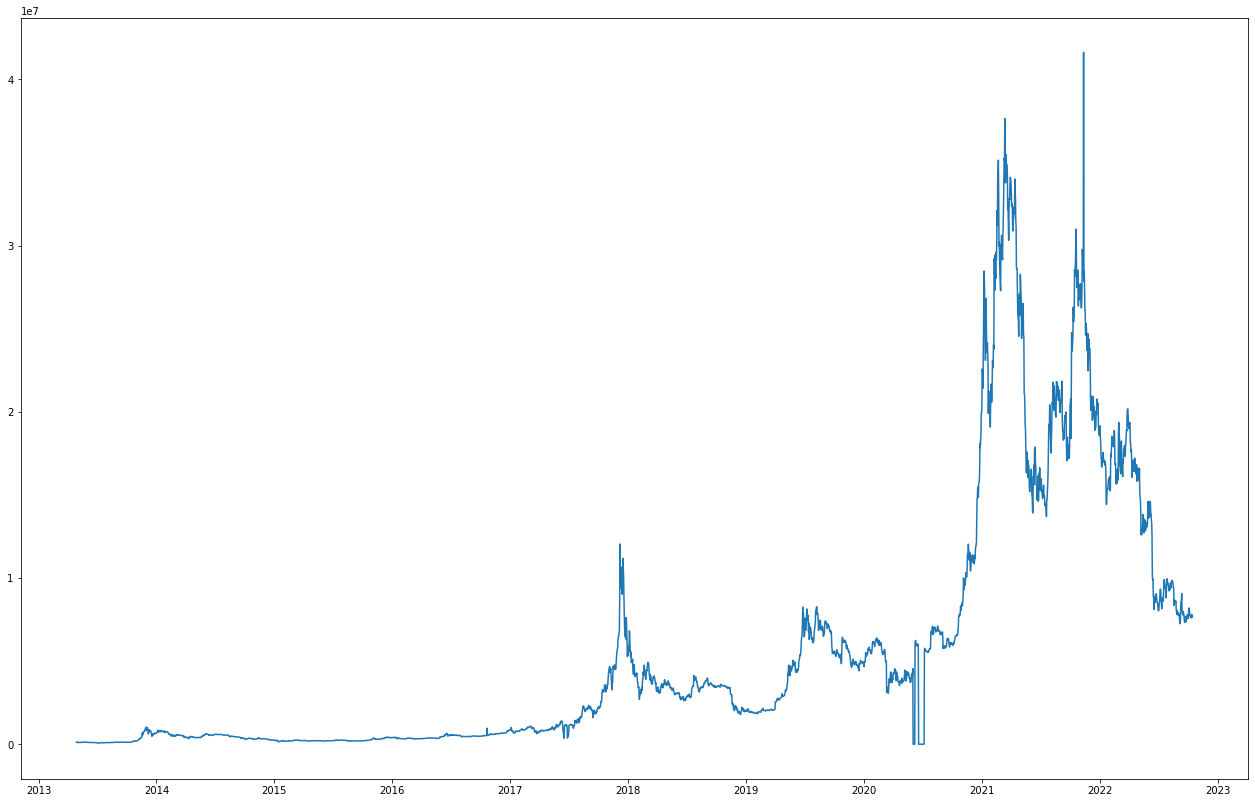

In [ ]:
plt.figure(figsize=(22,14))
plt.plot(index['Index_level'])

In [ ]:
index['Index_level'].nsmallest(50)

date
2020-06-28       62.191080
2020-07-01       63.236357
2020-06-30       69.986657
2020-06-25       70.244327
2020-07-03       70.482793
2020-06-24       73.574260
2020-06-23       82.337441
2020-06-29       82.368867
2020-06-26       83.462293
2020-06-21       84.862692
2020-06-22       86.730538
2020-07-02       88.112695
2020-06-20       90.082953
2020-06-19       94.438646
2020-06-27       94.691622
2020-07-04      172.104654
2020-07-05      290.269815
2020-06-07      353.349592
2020-06-05      433.171075
2020-06-04      593.683712
2020-07-06      626.490795
2020-06-03      864.526212
2020-06-02     1683.268532
2013-07-05    64058.283607
2013-07-06    65757.221909
2013-07-07    69827.190451
2013-07-08    71815.370248
2013-07-09    71980.074392
2013-07-03    72872.123175
2013-07-04    75624.025742
2013-07-10    81647.133219
2013-07-01    82896.576968
2013-07-11    83942.260993
2013-07-20    84039.348111
2013-07-02    85071.216726
2013-07-18    85171.852103
2013-07-21    85310.326

In [ ]:
index['pct_change'] = index['Index_level'].pct_change()

In [ ]:
new = new_df

In [ ]:
new.set_index('date', inplace=True)

In [ ]:
new_df = initial_df[['date', 'name_symbol', 'pct_change']]
new_df = new_df.groupby('name_symbol').apply(winsorize_group)
new_df.set_index('date', inplace=True)
new_df['log_change'] = np.log(new_df['pct_change']+1)

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


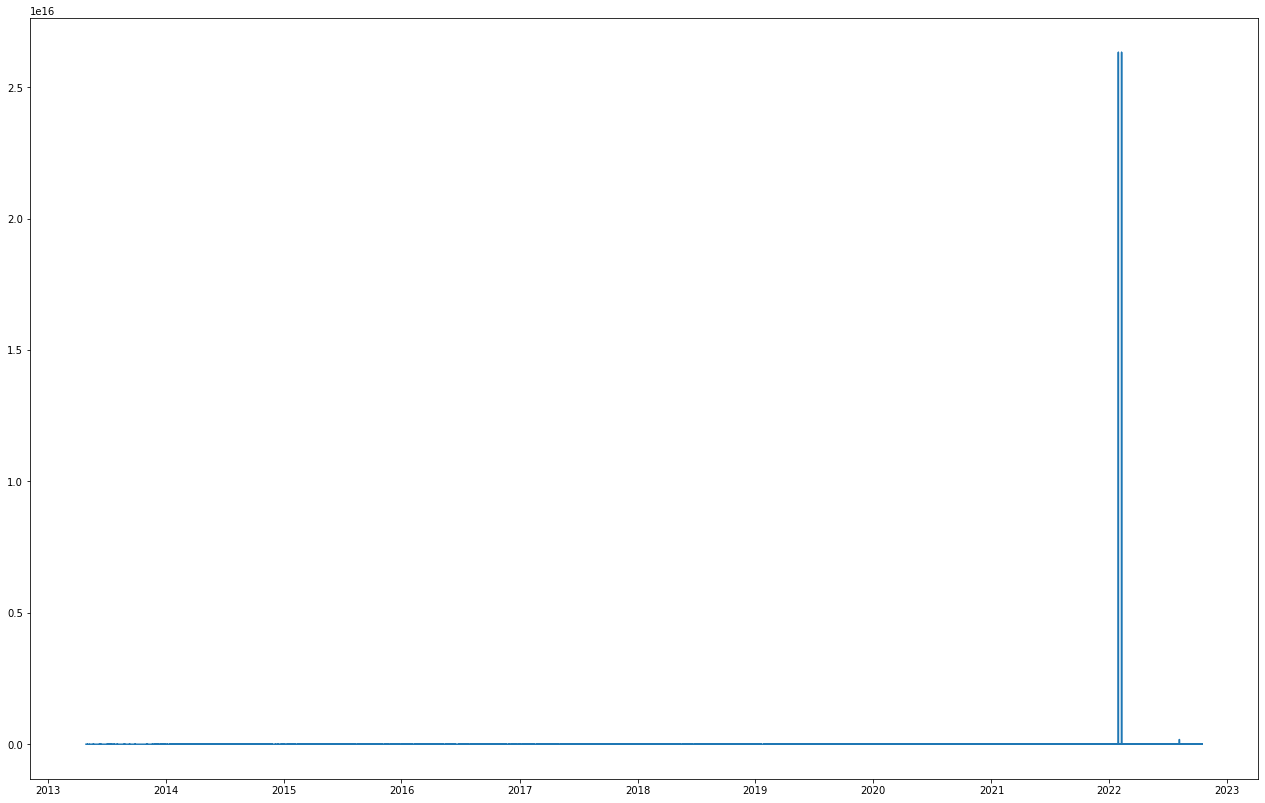

In [ ]:
plt.figure(figsize=(22,14))
plt.plot(new_df['pct_change'])

In [ ]:
def calclen(group):
  length = len(group)
  if length < 365:
    group['length'] = 0
  else:
    group['length'] = 1
  return group

# Data cleaning

Get rid of rows where pct_change is 0, since we need a return for each cryptocurrency

In [ ]:
new_df.reset_index(inplace=True)

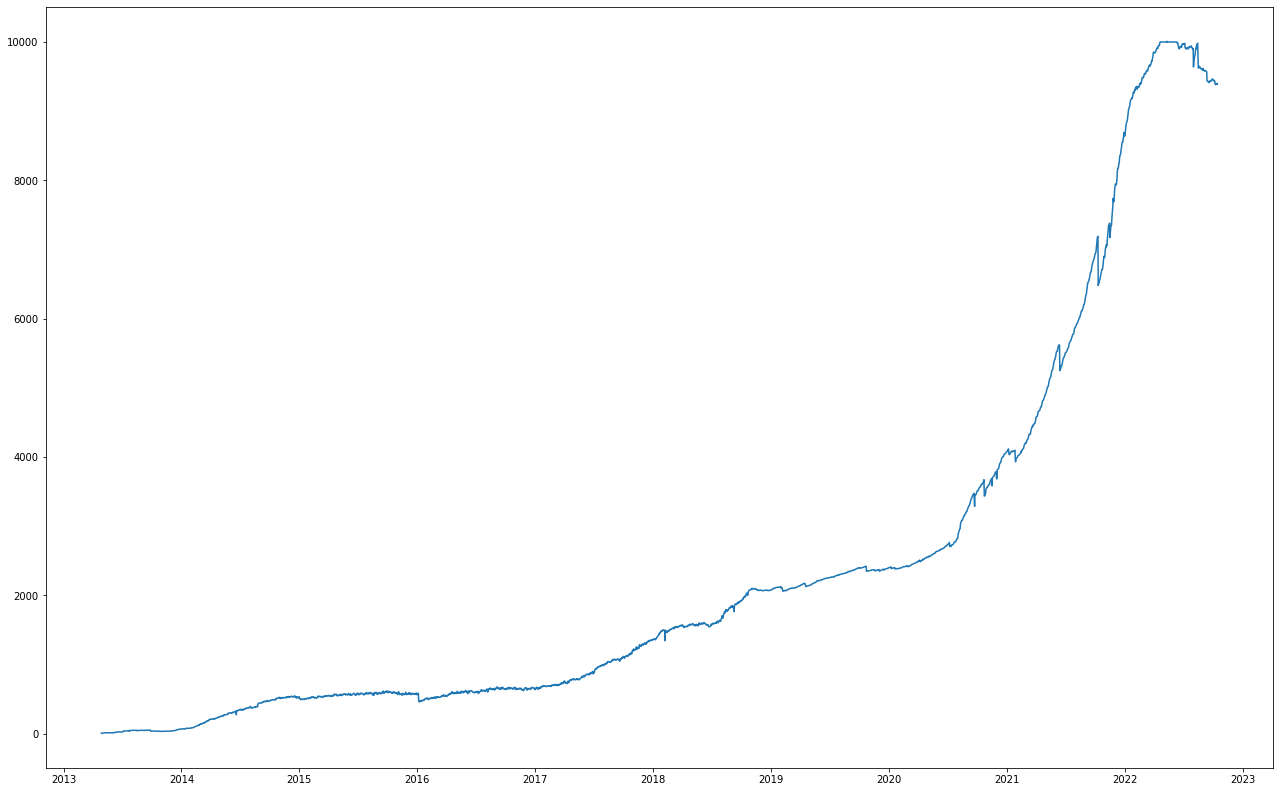

In [ ]:
plt.figure(figsize=(22,14))
plt.plot(new_df.groupby('date')['name_symbol'].count().to_frame())

In [ ]:
start = len(new_df['name_symbol'].unique())
start

18239

In [ ]:
new_df.isna().sum()

date                      0
name_symbol               0
price                     0
log_change            14628
pct_change            14628
volume                    0
circulating_supply        0
market_cap                0
Index_value               0
group_mkt_cap             0
Index_level               0
dtype: int64

In [ ]:
df = new_df[new_df['pct_change'].notna()]

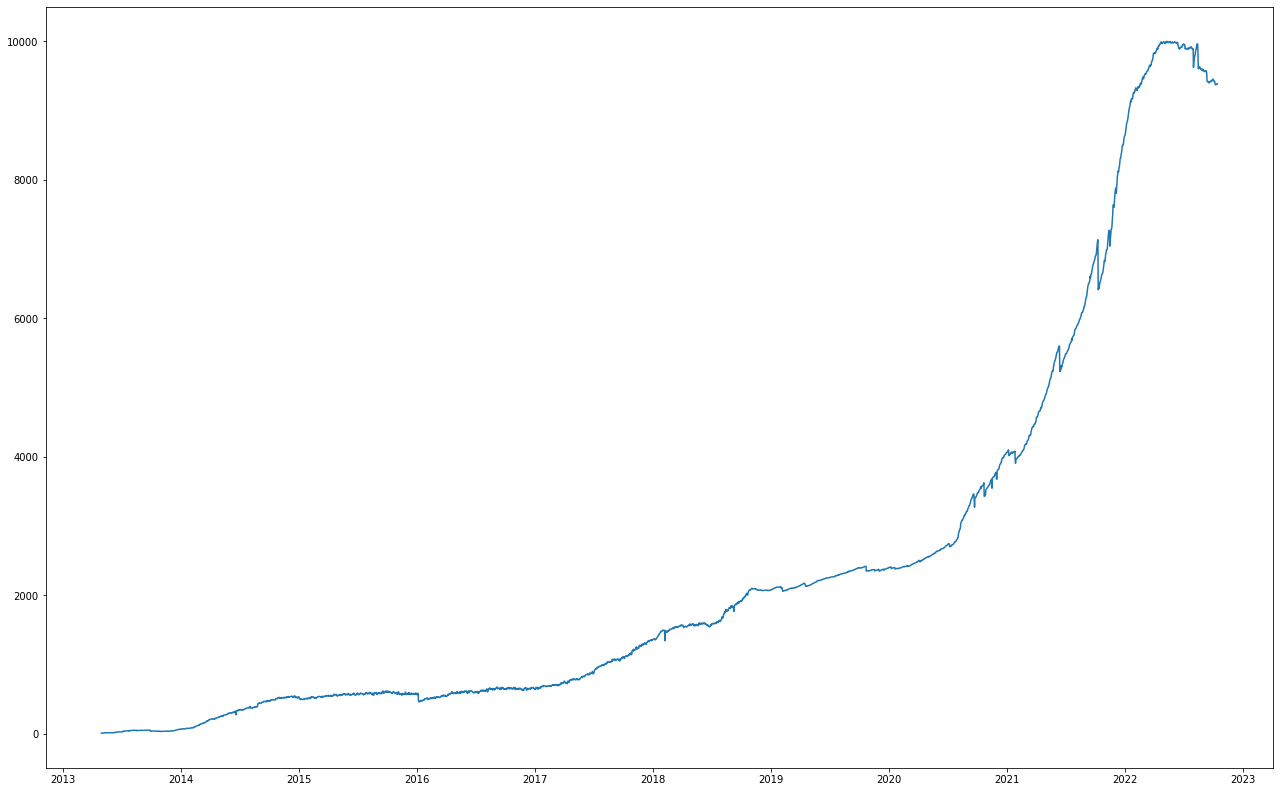

In [ ]:
plt.figure(figsize=(22,14))
plt.plot(df.groupby('date')['name_symbol'].count().to_frame())

In [ ]:
first_adj = len(df['name_symbol'].unique())
first_adj

18703

In [ ]:
print(f'Due to the adjustment {start - first_adj} were lost')

Due to the adjustment 99 were lost


### Adjusting for cryptocurrencies with less than 365 datapoints

In [ ]:
df = df.groupby('name_symbol').apply(calclen)

In [ ]:
df = df[df['length']==1]

In [ ]:
second_adj = len(df['name_symbol'].unique())
second_adj

7267

In [ ]:
print(f'Due to the adjustment {first_adj - second_adj} were lost')

Due to the adjustment 11436 were lost


The first time volume was calculated from CoinMarketCap was in late September 2013, thus the first month under consideration will be Oktober 2013

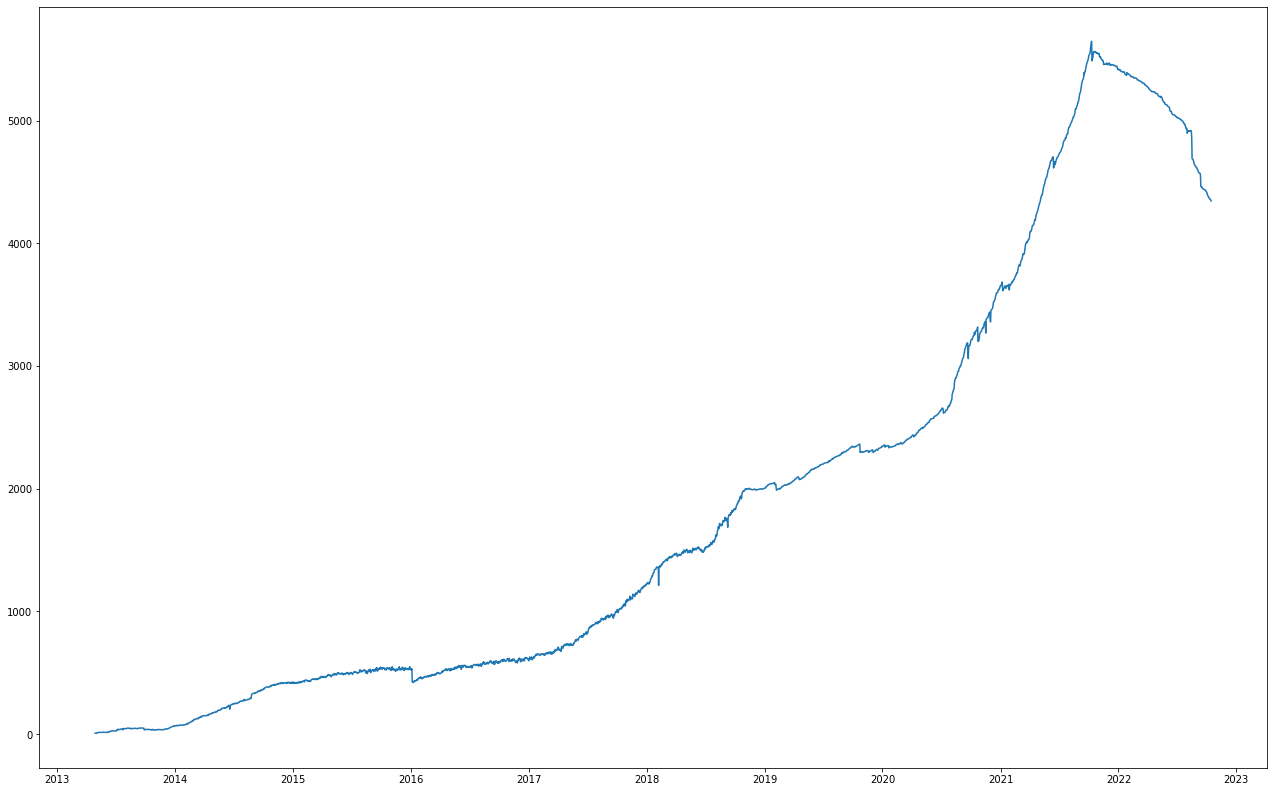

In [ ]:
plt.figure(figsize=(22,14))
plt.plot(df.groupby('date')['name_symbol'].count().to_frame())

In [ ]:
df.reset_index(inplace=True, drop=True)

In [ ]:
df[df['volume']>0].head(10)

,date,name_symbol,price,log_change,pct_change,volume,circulating_supply,market_cap,Index_value,group_mkt_cap,Index_level,length
4584,2013-10-01,DOUBLOONS DBL,0.005483,-0.002652,-0.002648,0.476495,7.620359e+05,4177.866425,22.905179,1.709002e+06,120505.029847,1
4596,2013-10-01,KRUGERCOIN KGC,0.000572,0.065885,0.068104,110.580557,1.523329e+07,8715.998518,4.987013,1.709002e+06,120505.029847,1
4628,2013-10-02,DOUBLOONS DBL,0.005468,-0.002659,-0.002655,0.595619,7.692081e+05,4205.989901,22.998133,1.465010e+06,104838.978323,1
4640,2013-10-02,KRUGERCOIN KGC,0.000609,0.061811,0.063762,138.225697,1.538808e+07,9365.953851,5.700589,1.465010e+06,104838.978323,1
4668,2013-10-03,CHNCOIN CNC,0.001739,-0.001489,-0.001488,3.647546,5.272880e+06,9167.478492,15.938665,1.592443e+06,113224.416606,1
4705,2013-10-04,CHNCOIN CNC,0.001736,-0.001491,-0.001490,7.295092,5.287885e+06,9179.869100,15.936427,1.666763e+06,117838.061528,1
4742,2013-10-05,CHNCOIN CNC,0.001733,-0.001493,-0.001492,10.942637,5.302891e+06,9192.181965,15.933991,1.659379e+06,117572.766317,1
4779,2013-10-06,CHNCOIN CNC,0.001731,-0.001496,-0.001494,14.590183,5.317896e+06,9204.417087,15.931356,1.668028e+06,117830.679179,1
4816,2013-10-07,CHNCOIN CNC,0.001728,-0.001498,-0.001497,18.237729,5.332902e+06,9216.574466,15.928523,1.637478e+06,116261.897069,1
5274,2013-10-19,SECURECOIN SRC,0.056237,0.177348,0.194046,103.164423,3.831120e+05,21545.154756,1211.639702,2.163272e+06,163153.056947,1


In [ ]:
df = df.iloc[4584:]

It only makes sense for the portfolio sorting when at least 30 cryptocurrencies are in one portfolio. Thus, the Data set will be cut to the date where more than 300 cryptocurrencies were tracked on one day

In [ ]:
curr_p_day = df.groupby('date')['name_symbol'].count().to_frame()

In [ ]:
curr_p_day[curr_p_day['name_symbol']>300]

,name_symbol
date,
2014-08-28,301
2014-08-29,303
2014-08-30,304
2014-08-31,307
2014-09-01,309
...,...
2022-10-11,4381
2022-10-12,4378
2022-10-13,4374


The first day where more than 300 currencies are tracked is in late August. Thus the data set will be cut there. Then the datapoints for each currency are calculated again and the dataset will be further cut if necessary

In [ ]:
third_adj = df[df['date']>'2014-08-31']
third_adj = third_adj.groupby('name_symbol').apply(calclen)

In [ ]:
df = third_adj[third_adj['length']==1]

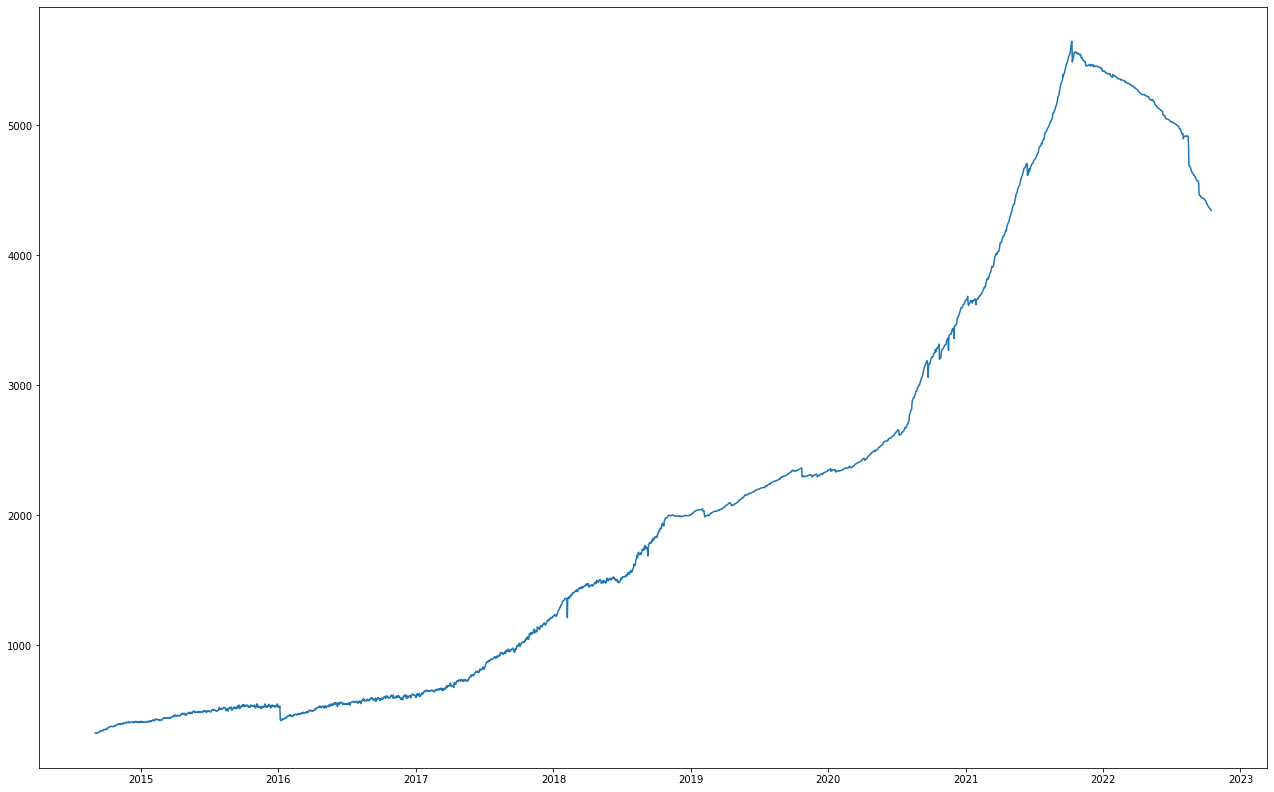

In [ ]:
plt.figure(figsize=(22,14))
plt.plot(df.groupby('date')['name_symbol'].count().to_frame())

since there are more than 300 coins tracked after 2014 no further adjustment will be made.

In [ ]:
third_adj = len(third_adj['name_symbol'].unique())

In [ ]:
print(f'Due to the adjustment {second_adj - third_adj} were lost')

Due to the adjustment 13 were lost


In [ ]:
df['pct_change'].max()

3310695498231.9683

In [ ]:
df[df['pct_change']==3310695498231.9683]

,date,name_symbol,price,log_change,pct_change,volume,circulating_supply,market_cap,Index_value,group_mkt_cap,Index_level,length
546326,2017-05-29,ETHEREUM-MOVIE-VENTURE EMV,0.308567,28.828179,3.310695e+12,705.016418,6566666.0,2.026258e+06,625237.145022,7.717144e+07,1.128459e+06,1


In [ ]:
df.reset_index(inplace=True, drop=True)

In [ ]:
df.to_csv('/drive/My Drive/Colab Notebooks/ADJ_Data.csv', index=False)

In [ ]:
df= pd.read_csv('/drive/My Drive/Colab Notebooks/ADJ_Data.csv')

TypeError: ignored

In [ ]:
index = df[['date', 'Index_level']]
index = index.drop_duplicates()

In [ ]:
index.reset_index(inplace=True, drop=True)

In [ ]:
index['pct_change'] = index['Index_level'].pct_change()

In [ ]:
index['pct_change'].nsmallest()

2113   -0.999984
2097   -0.999630
1028   -0.670763
2098   -0.486400
781    -0.447904
Name: pct_change, dtype: float64

In [ ]:
index.iloc[2113:2131]['Index_level'] = np.nan

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
index.iloc[2097:2102]['Index_level'] = np.nan

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
index.set_index('date', inplace=True)

In [ ]:
a = index.interpolate()

In [ ]:
a['pct_change'] = a['Index_level'].pct_change()

In [ ]:
a['pct_change'].nlargest()

date
2016-10-21    0.900298
2017-06-17    0.808943
2017-06-18    0.677996
2017-07-02    0.633576
2021-11-12    0.478682
Name: pct_change, dtype: float64

In [ ]:
a['pct_change'] += 1
a.iloc[0] = 1000

In [ ]:
a['cumprod'] = a['pct_change'].cumprod()

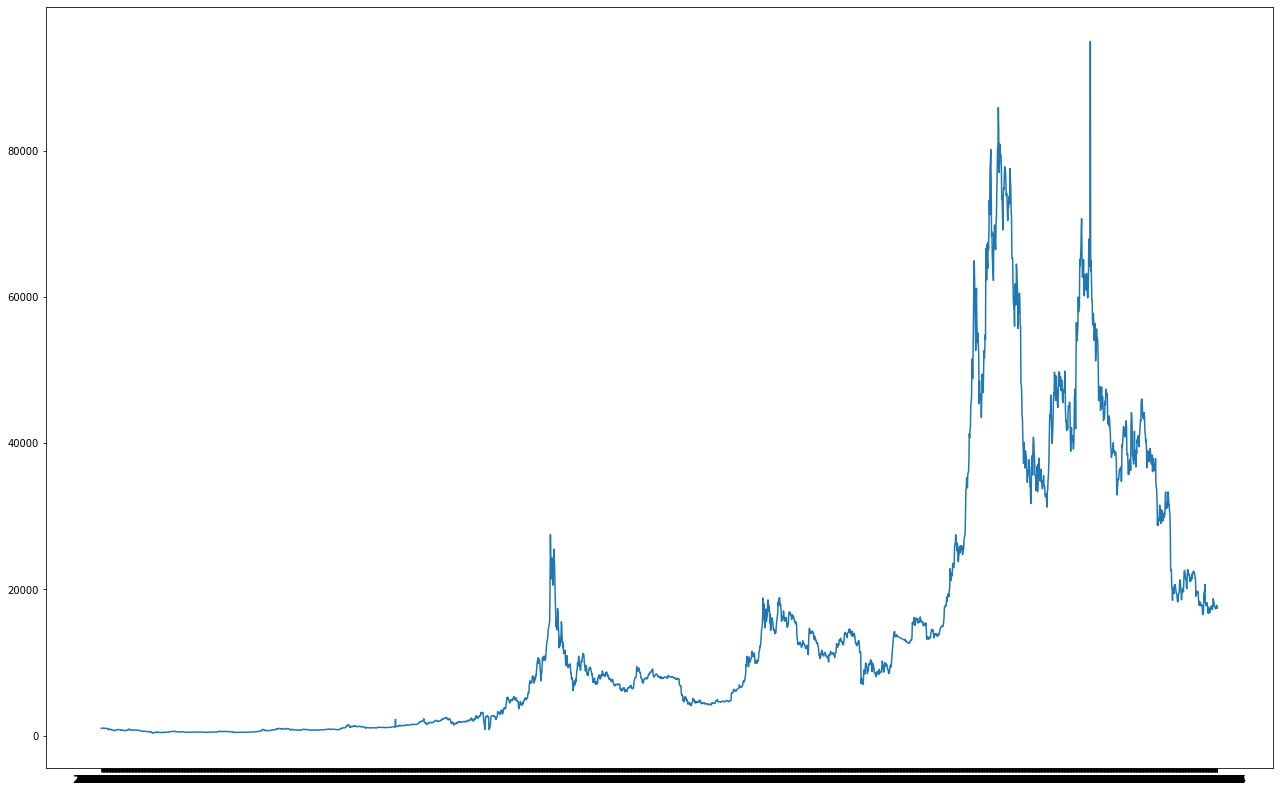

In [ ]:
plt.figure(figsize=(22,14))
plt.plot(a['cumprod'])

In [ ]:
index.index = pd.to_datetime(index.index)

In [ ]:
index_prizes = index['Index_level'].resample('M').last().pct_change().to_frame()

In [ ]:
index_prizes

,Index_level
date,
2014-09-30,NaN
2014-10-31,-0.121305
2014-11-30,0.082657
2014-12-31,-0.244683
2015-01-31,-0.296561
...,...
2022-06-30,-0.428069
2022-07-31,0.154355
2022-08-31,-0.178879


In [ ]:
index_prizes += 1

In [ ]:
index_prizes.iloc[0] = 1000

In [ ]:
index_prizes = index_prizes.cumprod()

In [ ]:
index_prizes

,Index_level
date,
2014-09-30,1000.000000
2014-10-31,878.694623
2014-11-30,951.324700
2014-12-31,718.551625
2015-01-31,505.456924
...,...
2022-06-30,23932.746342
2022-07-31,27626.885322
2022-08-31,22685.011886


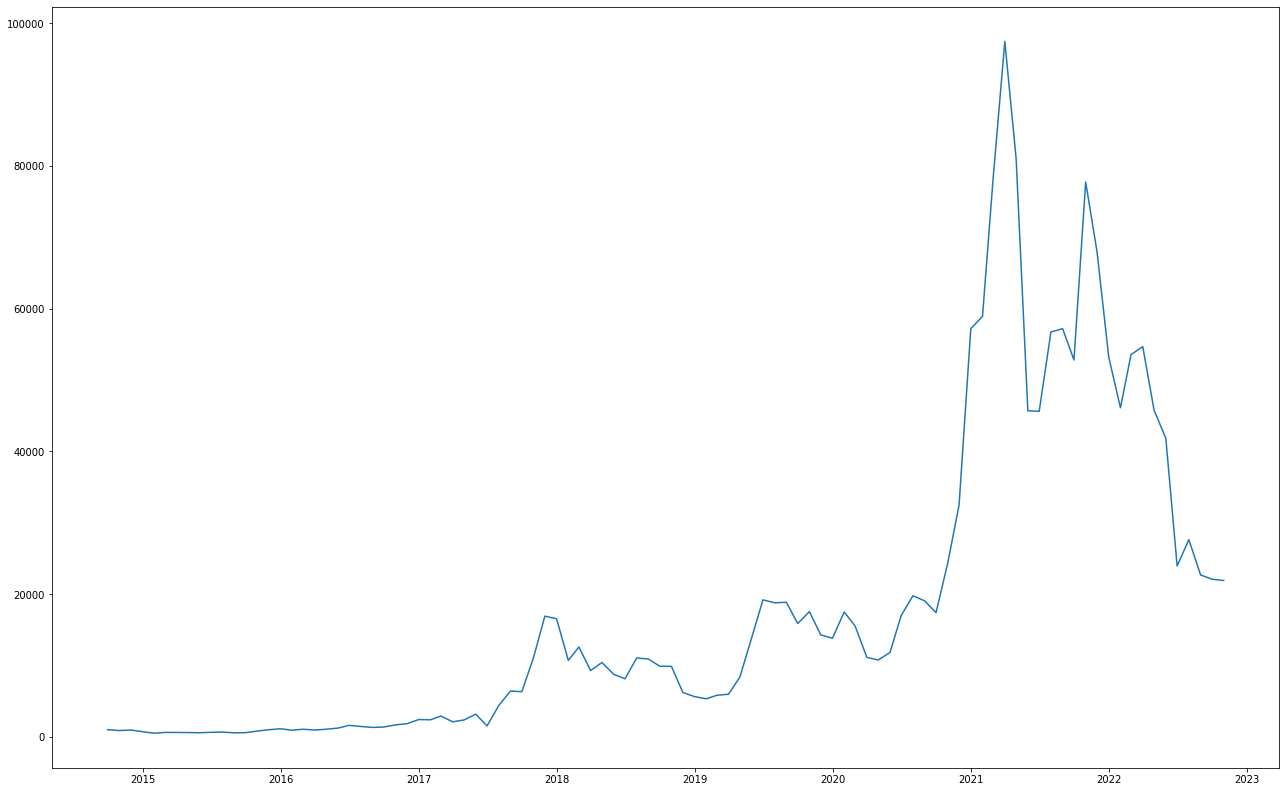

In [ ]:
plt.figure(figsize=(22,14))
plt.plot(index_prizes)

In [ ]:
df.columns

Index(['Unnamed: 0', 'date', 'name_symbol', 'price', 'log_change',
       'pct_change', 'volume', 'circulating_supply', 'market_cap',
       'Index_value', 'group_mkt_cap', 'Index_level', 'length'],
      dtype='object')

In [ ]:
df = df[['date', 'name_symbol', 'price', 'log_change',
       'pct_change', 'volume', 'circulating_supply', 'market_cap']]

In [ ]:
a

,Index_level,pct_change,cumprod
date,,,
2014-09-01,1.000000e+03,1000.000000,1000.000000
2014-09-02,4.416577e+05,1.007189,1007.188829
2014-09-03,4.405526e+05,0.997498,1004.668673
2014-09-04,4.513913e+05,1.024603,1029.386106
2014-09-05,4.449490e+05,0.985728,1014.694570
...,...,...,...
2022-10-11,7.599944e+06,0.997885,17331.472852
2022-10-12,7.647852e+06,1.006304,17440.726692
2022-10-13,7.810917e+06,1.021322,17812.591666


In [ ]:
index_prizes.to_csv('/drive/My Drive/Colab Notebooks/monthly_index.csv')
a.to_csv('/drive/My Drive/Colab Notebooks/daily_index.csv')

In [ ]:
def calcTrendFactor(group):
  try:
    index = range(len(group))
    prices = group['price']
    prices.reset_index(inplace=True,drop=True)
    W_MA = [3, 5, 10, 20, 50, 100, 200, 400, 600, 800, 1000]

    W_MA = [x for x in W_MA if x < len(group)]
    
    # Get the window of series
    # of observations of specified window size
    MA = pd.DataFrame(index=index, columns=list([f'MA_{i}' for i in W_MA]))
    for window in W_MA:
      windows = prices.rolling(window)
      
      # Create a series of moving
      # averages of each window
      moving_averages = windows.mean()

      MA[f'MA_{window}'] = moving_averages


    #Set up regression
    r_C = group['log_change']
    r_C.reset_index(inplace=True,drop=True)
    A = MA.div(prices, axis=0)

    A = sm.add_constant(A)
    A.rename(columns = {"const":"Intercept"}, inplace = True)

    model = RollingOLS(r_C, A, window=365, min_nobs=30, expanding=True)

    result = model.fit()
    betas = result.params

    betas = betas.iloc[:,:-1].sum(axis=1)
    betas = betas.rolling(365).sum().div(365)

    final = A.mul(betas, axis=0)
    final = final.sum(axis=1)
    final.index = group.index
    group['Trend'] = final
  except:
    group['Trend']=''
  return group

In [ ]:
df = df.groupby('name_symbol').apply(calcTrendFactor)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/rolling.py:265: RuntimeWarning: divide by zero encountered in log
  llf = -np.log(ssr) * nobs2  # concentrated likelihood


In [ ]:
df

,date,name_symbol,price,log_change,pct_change,volume,circulating_supply,market_cap,Trend
0,2014-09-01,42-COIN 42,1305.628174,-0.014811,-0.014702,456.053955,1.200000e+01,1.566754e+04,0.000000
1,2014-09-01,AEROCOIN AM,0.024923,-0.174463,-0.160092,16400.152344,7.094836e+06,1.768257e+05,0.000000
2,2014-09-01,AIDEN ADN,0.000404,0.054570,0.056086,117.092796,1.463940e+07,5.909153e+03,0.000000
3,2014-09-01,ALIENCOIN ALN,0.001049,0.136476,0.146227,4801.775391,2.463245e+07,2.584095e+04,0.000000
4,2014-09-01,ANIMECOIN ANI,0.000005,-0.006055,-0.006036,0.427391,1.930062e+09,9.165461e+03,0.000000
...,...,...,...,...,...,...,...,...,...
5873363,2022-10-15,ZURCOIN ZUR,0.000306,-0.058356,-0.056686,0.000000,0.000000e+00,0.000000e+00,344220.323930
5873364,2022-10-15,ZUSD ZUSD,0.999113,-0.000882,-0.000882,17444.750000,1.472237e+06,1.470931e+06,9.914898
5873365,2022-10-15,ZYNECOIN ZYN,0.202383,0.000888,0.000889,39817.820000,3.271319e+07,6.620580e+06,0.672672
5873366,2022-10-15,ZYRO ZYRO,0.004552,-0.025634,-0.025308,216057.830000,0.000000e+00,0.000000e+00,2.564058


In [ ]:
a.reset_index(inplace=True)

In [ ]:
a['Index_level'].iloc[0] = 438566.0961

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
b = a[['date', 'Index_level']]

In [ ]:
df = df.merge(b, on= ['date'])

In [ ]:
df.columns

Index(['date', 'name_symbol', 'price', 'log_change', 'pct_change', 'volume',
       'circulating_supply', 'market_cap', 'Trend', 'Index', 'Index_level'],
      dtype='object')

In [ ]:
df = df[['date', 'name_symbol', 'price', 'log_change', 'pct_change', 'volume',
       'circulating_supply', 'market_cap', 'Trend', 'Index_level']]

In [ ]:
df['log_change_I'] = np.log(df['pct_change_I'] +1)

Since the first beta is calculated after 250 datapoints, the first 250 datapoints do not show a beta, thus these rows have to be dropped 

In [ ]:
df = df[df['Beta'].notna()]

In [ ]:
df.reset_index(inplace=True, drop=True)

In [ ]:
df.to_csv('/drive/My Drive/Colab Notebooks/With_Beta_Trend.csv')

In [ ]:
len(df['name_symbol'].unique())

6963

In [ ]:
df = pd.read_csv('/drive/My Drive/Colab Notebooks/With_Beta_Trend.csv')

In [ ]:
df

,Unnamed: 0,date,name_symbol,price,log_change,pct_change,volume,circulating_supply,market_cap,Trend,Index_level,Beta
0,0,2015-03-19,42-COIN 42,1194.018188,0.097148,0.102024,1383.412842,9.178677e-01,1.095951e+03,0.000000,2.249707e+05,1.808643e-07
1,1,2015-03-19,AEROCOIN AM,0.007819,0.027793,0.028182,0.132606,1.203190e+07,9.407564e+04,0.000000,2.249707e+05,-7.072575e-07
2,2,2015-03-19,AIDEN ADN,0.000052,-0.454189,-0.365037,7.597792,1.463940e+07,7.634185e+02,0.000000,2.249707e+05,3.096715e-08
3,3,2015-03-19,ALIENCOIN ALN,0.000130,0.077690,0.080787,5.617543,2.472609e+07,3.223553e+03,0.000000,2.249707e+05,2.640052e-07
4,4,2015-03-19,ANONCOIN ANC,0.094458,-0.042583,-0.041689,787.120911,1.628289e+06,1.538057e+05,0.000000,2.249707e+05,1.033840e-07
...,...,...,...,...,...,...,...,...,...,...,...,...
4487726,4487726,2022-10-15,ZURCOIN ZUR,0.000306,-0.058356,-0.056686,0.000000,0.000000e+00,0.000000e+00,344220.323930,7.645238e+06,8.686044e-08
4487727,4487727,2022-10-15,ZUSD ZUSD,0.999113,-0.000882,-0.000882,17444.750000,1.472237e+06,1.470931e+06,9.914898,7.645238e+06,4.200053e-12
4487728,4487728,2022-10-15,ZYNECOIN ZYN,0.202383,0.000888,0.000889,39817.820000,3.271319e+07,6.620580e+06,0.672672,7.645238e+06,-5.678117e-10
4487729,4487729,2022-10-15,ZYRO ZYRO,0.004552,-0.025634,-0.025308,216057.830000,0.000000e+00,0.000000e+00,2.564058,7.645238e+06,3.248330e-09


In [ ]:
a = pd.read_csv('/drive/My Drive/Colab Notebooks/daily_index.csv')

In [ ]:
a

,date,Index_level,pct_change,cumprod
0,2014-09-01,1.000000e+03,1000.000000,1000.000000
1,2014-09-02,4.416577e+05,1.007189,1007.188829
2,2014-09-03,4.405526e+05,0.997498,1004.668673
3,2014-09-04,4.513913e+05,1.024603,1029.386106
4,2014-09-05,4.449490e+05,0.985728,1014.694570
...,...,...,...,...
2956,2022-10-11,7.599944e+06,0.997885,17331.472852
2957,2022-10-12,7.647852e+06,1.006304,17440.726692
2958,2022-10-13,7.810917e+06,1.021322,17812.591666
2959,2022-10-14,7.691451e+06,0.984705,17540.153643


In [ ]:
a['Index_level'].iloc[0] = 438566.0961

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
a['pct_change_I'] = a['Index_level'].pct_change()

In [ ]:
a['log_change_I'] = np.log(a['pct_change_I'] + 1)

In [ ]:
a['pct_change_I'].max()

0.9002980022203984

In [ ]:
a = a[['date', 'log_change_I', 'pct_change_I', 'cumprod']]

In [ ]:
b = a[['date', 'log_change_I', 'pct_change_I']]

In [ ]:
df = df.merge(b, on= ['date'])

In [ ]:
df

,Unnamed: 0,date,name_symbol,price,log_change,pct_change,volume,circulating_supply,market_cap,Trend,Index_level,Beta,log_change_I,pct_change_I
0,0,2015-03-19,42-COIN 42,1194.018188,0.097148,0.102024,1383.412842,9.178677e-01,1.095951e+03,0.000000,2.249707e+05,1.808643e-07,0.019500,0.019691
1,1,2015-03-19,AEROCOIN AM,0.007819,0.027793,0.028182,0.132606,1.203190e+07,9.407564e+04,0.000000,2.249707e+05,-7.072575e-07,0.019500,0.019691
2,2,2015-03-19,AIDEN ADN,0.000052,-0.454189,-0.365037,7.597792,1.463940e+07,7.634185e+02,0.000000,2.249707e+05,3.096715e-08,0.019500,0.019691
3,3,2015-03-19,ALIENCOIN ALN,0.000130,0.077690,0.080787,5.617543,2.472609e+07,3.223553e+03,0.000000,2.249707e+05,2.640052e-07,0.019500,0.019691
4,4,2015-03-19,ANONCOIN ANC,0.094458,-0.042583,-0.041689,787.120911,1.628289e+06,1.538057e+05,0.000000,2.249707e+05,1.033840e-07,0.019500,0.019691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4487726,4487726,2022-10-15,ZURCOIN ZUR,0.000306,-0.058356,-0.056686,0.000000,0.000000e+00,0.000000e+00,344220.323930,7.645238e+06,8.686044e-08,-0.006027,-0.006008
4487727,4487727,2022-10-15,ZUSD ZUSD,0.999113,-0.000882,-0.000882,17444.750000,1.472237e+06,1.470931e+06,9.914898,7.645238e+06,4.200053e-12,-0.006027,-0.006008
4487728,4487728,2022-10-15,ZYNECOIN ZYN,0.202383,0.000888,0.000889,39817.820000,3.271319e+07,6.620580e+06,0.672672,7.645238e+06,-5.678117e-10,-0.006027,-0.006008
4487729,4487729,2022-10-15,ZYRO ZYRO,0.004552,-0.025634,-0.025308,216057.830000,0.000000e+00,0.000000e+00,2.564058,7.645238e+06,3.248330e-09,-0.006027,-0.006008


In [ ]:
df = df[['date', 'name_symbol', 'price', 'log_change',
       'pct_change_CC', 'volume', 'circulating_supply', 'market_cap', 'Trend',
       'Beta', 'log_change_I', 'pct_change_I']]

KeyError: ignored

In [ ]:
df.rename(columns={'pct_change_x':'pct_change_CC'}, inplace=True)

In [ ]:
def calcMOMFactorLoading(group):
  group['Momentum'] = (group['log_change']
                       .rolling(335, min_periods=200)
                       .sum())
  return group

In [ ]:
def calcBeta(group):
    """
    Returns the Beta for each group
    """
    group['Beta'] = (group['log_change']
                     .rolling(365, min_periods=200)
                     .cov(group['log_change_I']) / 
                     group['log_change_I']
                     .rolling(365,  min_periods=200).var())
    return group

In [ ]:
df = df.groupby(['name_symbol']).apply(calcBeta)

In [ ]:
df = df.groupby('name_symbol').apply(calcMOMFactorLoading)

In [ ]:
df['date'] = pd.to_datetime(df['date'])

In [ ]:
df

,Unnamed: 0,date,name_symbol,price,log_change,pct_change,volume,circulating_supply,market_cap,Trend,Index_level,Beta,log_change_I,pct_change_I
0,0,2015-03-19,42-COIN 42,1194.018188,0.097148,0.102024,1383.412842,9.178677e-01,1.095951e+03,0.000000,2.249707e+05,1.808643e-07,0.019500,0.019691
1,1,2015-03-19,AEROCOIN AM,0.007819,0.027793,0.028182,0.132606,1.203190e+07,9.407564e+04,0.000000,2.249707e+05,-7.072575e-07,0.019500,0.019691
2,2,2015-03-19,AIDEN ADN,0.000052,-0.454189,-0.365037,7.597792,1.463940e+07,7.634185e+02,0.000000,2.249707e+05,3.096715e-08,0.019500,0.019691
3,3,2015-03-19,ALIENCOIN ALN,0.000130,0.077690,0.080787,5.617543,2.472609e+07,3.223553e+03,0.000000,2.249707e+05,2.640052e-07,0.019500,0.019691
4,4,2015-03-19,ANONCOIN ANC,0.094458,-0.042583,-0.041689,787.120911,1.628289e+06,1.538057e+05,0.000000,2.249707e+05,1.033840e-07,0.019500,0.019691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4487726,4487726,2022-10-15,ZURCOIN ZUR,0.000306,-0.058356,-0.056686,0.000000,0.000000e+00,0.000000e+00,344220.323930,7.645238e+06,8.686044e-08,-0.006027,-0.006008
4487727,4487727,2022-10-15,ZUSD ZUSD,0.999113,-0.000882,-0.000882,17444.750000,1.472237e+06,1.470931e+06,9.914898,7.645238e+06,4.200053e-12,-0.006027,-0.006008
4487728,4487728,2022-10-15,ZYNECOIN ZYN,0.202383,0.000888,0.000889,39817.820000,3.271319e+07,6.620580e+06,0.672672,7.645238e+06,-5.678117e-10,-0.006027,-0.006008
4487729,4487729,2022-10-15,ZYRO ZYRO,0.004552,-0.025634,-0.025308,216057.830000,0.000000e+00,0.000000e+00,2.564058,7.645238e+06,3.248330e-09,-0.006027,-0.006008


In [ ]:
prices = df[['date', 'name_symbol', 'price']]
prices = pd.pivot_table(prices, index='date', columns='name_symbol',values='price')
prices.replace(to_replace=np.inf, value=np.nan, inplace=True)
prices.replace(to_replace=-np.inf, value=np.nan, inplace=True)
prices.interpolate(limit_direction='both',
                  limit_area='inside',
                  method='time',
                  limit=5,
                  inplace=True,)
prices.columns.name = None
prices.reset_index(inplace=True)

In [ ]:
prices

,date,007COIN 007,01COIN ZOC,0CASH ZCH,0CHAIN ZCN,0X ZRX,0X-NODES BIOS,0XBTC 0xBTC,0XCERT ZXC,1-UP 1-UP,...,ZUM-TOKEN ZUM,ZUMCOIN ZUM,ZUPLO ZLP,ZURCOIN ZUR,ZUSD ZUSD,ZUZ-PROTOCOL ZUZ,ZYNECOIN ZYN,ZYRO ZYRO,ZYTARA-DOLLAR ZUSD,ZYX ZYX
0,2015-03-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-03-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-03-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-03-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-03-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2757,2022-10-11,NaN,0.000295,NaN,0.141145,0.251710,0.043619,0.132212,NaN,0.010592,...,0.000008,0.000019,0.001280,0.000320,0.997243,NaN,0.193832,0.004631,NaN,0.013236
2758,2022-10-12,NaN,0.000297,NaN,0.188910,0.252597,0.043637,0.123284,NaN,0.011117,...,0.000008,0.000019,0.001295,0.000337,0.999757,NaN,0.201657,0.004741,NaN,0.012909
2759,2022-10-13,NaN,0.000368,NaN,0.180597,0.247428,0.043637,0.165089,NaN,0.010506,...,0.000008,0.000019,0.001288,0.000309,0.997980,NaN,0.197175,0.004693,NaN,0.012949
2760,2022-10-14,NaN,0.000288,NaN,0.177502,0.244222,0.043637,0.201062,NaN,0.010250,...,0.000008,0.000019,0.001297,0.000324,0.999995,NaN,0.202203,0.004670,NaN,0.012870


In [ ]:
prices2 = prices.copy()

# Adjustment for Survivor-ship bias

In [ ]:
prices2.reset_index(inplace=True, drop=True)

In [ ]:
for header, column in prices2.items():
  if header == 'date':
    continue
  else:
    i = column.last_valid_index()
    if i == (len(df) - 1):
      continue
    else:
      prices2.at[i+1, header] = prices[header].iloc[i] * 0.7

In [ ]:
prices2= prices2.iloc[:-1,:]

In [ ]:
prices2

,date,007COIN 007,01COIN ZOC,0CASH ZCH,0CHAIN ZCN,0X ZRX,0X-NODES BIOS,0XBTC 0xBTC,0XCERT ZXC,1-UP 1-UP,...,ZUM-TOKEN ZUM,ZUMCOIN ZUM,ZUPLO ZLP,ZURCOIN ZUR,ZUSD ZUSD,ZUZ-PROTOCOL ZUZ,ZYNECOIN ZYN,ZYRO ZYRO,ZYTARA-DOLLAR ZUSD,ZYX ZYX
0,2015-03-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-03-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-03-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-03-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-03-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2757,2022-10-11,NaN,0.000295,NaN,0.141145,0.251710,0.043619,0.132212,NaN,0.010592,...,0.000008,0.000019,0.001280,0.000320,0.997243,NaN,0.193832,0.004631,NaN,0.013236
2758,2022-10-12,NaN,0.000297,NaN,0.188910,0.252597,0.043637,0.123284,NaN,0.011117,...,0.000008,0.000019,0.001295,0.000337,0.999757,NaN,0.201657,0.004741,NaN,0.012909
2759,2022-10-13,NaN,0.000368,NaN,0.180597,0.247428,0.043637,0.165089,NaN,0.010506,...,0.000008,0.000019,0.001288,0.000309,0.997980,NaN,0.197175,0.004693,NaN,0.012949
2760,2022-10-14,NaN,0.000288,NaN,0.177502,0.244222,0.043637,0.201062,NaN,0.010250,...,0.000008,0.000019,0.001297,0.000324,0.999995,NaN,0.202203,0.004670,NaN,0.012870


In [ ]:
prices.set_index('date', inplace=True)

In [ ]:
#return for the previous month
monthly_prices2 = prices.resample('M').last()

ret_M_t = pd.DataFrame()

ret_M_t['return_t'] = (monthly_prices2
                           .pct_change(1)
                           .stack()
                           .mul(100)
                            )

ret_M_t = (ret_M_t
         .swaplevel()
         .dropna())

ret_M_t.reset_index(inplace=True)
ret_M_t.index = ret_M_t['date']
ret_M_t.rename(columns = {'level_0':'name_symbol'}, inplace = True)
ret_M_t = ret_M_t[['name_symbol', 'return_t']]
ret_M_t.replace(0, np.nan, inplace=True)

In [ ]:
#return for the following month
monthly_prices = prices.resample('M').last()

ret_M_t_1 = pd.DataFrame()

ret_M_t_1['return_t1'] = (monthly_prices
                           .pct_change(1)
                           .shift(-1)
                           .stack()
                           .mul(100)
                           )

ret_M_t_1 = (ret_M_t_1
         .swaplevel()
         .dropna())

ret_M_t_1.reset_index(inplace=True)
ret_M_t_1.index = ret_M_t_1['date']
ret_M_t_1.rename(columns = {'level_0':'name_symbol'}, inplace = True)
ret_M_t_1 = ret_M_t_1[['name_symbol', 'return_t1']]
ret_M_t_1.replace(0, np.nan, inplace=True)

Get the risk free rate from the Fama French Dataset

In [ ]:
import pandas_datareader.data as web

In [ ]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start='2000')[0]
factor_data.index = factor_data.index.to_timestamp()
factor_data = (factor_data
               .resample('M')
               .last())
factor_data.index.name = 'date'
factor_data

,Mkt-RF,SMB,HML,RMW,CMA,RF
date,,,,,,
2000-01-31,-4.74,4.44,-1.91,-6.31,4.75,0.41
2000-02-29,2.45,18.34,-9.70,-18.73,-0.36,0.43
2000-03-31,5.20,-15.35,8.17,11.82,-1.65,0.47
2000-04-30,-6.40,-5.01,7.26,7.66,5.65,0.46
2000-05-31,-4.42,-3.84,4.81,4.17,1.30,0.50
...,...,...,...,...,...,...
2022-04-30,-9.46,-0.40,6.19,3.63,5.92,0.01
2022-05-31,-0.34,-0.06,8.41,1.44,3.98,0.03
2022-06-30,-8.43,1.30,-5.97,1.85,-4.70,0.06


In [ ]:
mergeddf = pd.merge(ret_M_t,factor_data,how='left',left_on='date', right_on='date')
mergeddf = mergeddf[['name_symbol', 'return_t', 'RF']].copy()
mergeddf['ExRET_t'] = mergeddf['return_t'] - mergeddf['RF']

In [ ]:
mergeddf

,name_symbol,return_t,RF,ExRET_t
date,,,,
2015-04-30,42-COIN 42,-13.752538,0.0,-13.752538
2015-04-30,AEROCOIN AM,-24.973828,0.0,-24.973828
2015-04-30,AIDEN ADN,-65.855630,0.0,-65.855630
2015-04-30,ALIENCOIN ALN,13.857140,0.0,13.857140
2015-04-30,ANONCOIN ANC,-30.057514,0.0,-30.057514
...,...,...,...,...
2022-10-31,ZUZ-PROTOCOL ZUZ,NaN,NaN,NaN
2022-10-31,ZYNECOIN ZYN,-6.027015,NaN,NaN
2022-10-31,ZYRO ZYRO,-4.211469,NaN,NaN


In [ ]:
mergeddf = pd.merge(mergeddf, 
                    ret_M_t_1, 
                    how='left',
                    on=['date', 'name_symbol'])
mergeddf['ExRET_t1'] = mergeddf['return_t1'] - mergeddf['RF']

In [ ]:
pct_ch = prices.pct_change()
pct_ch = pct_ch.interpolate()

In [ ]:
monthly_lot_change = (
                      pct_ch
                      .unstack()
                      .reset_index()
                      .set_index('date')
                      .rename(columns={'level_0': 'name_symbol',
                                       0: 'value'})
                      .groupby([pd.Grouper(freq='M'), 'name_symbol'])
                      .value.apply(lambda _s: _s.nlargest(5).mean())
                      .unstack('name_symbol')
                      )

In [ ]:
Lottery = pd.DataFrame()
Lottery['Lot'] = (
                  monthly_lot_change
                  .stack()
                  .mul(100)
                  )

Lottery = (
          Lottery
         .swaplevel()
         .dropna()
         .reset_index()
         .set_index('date')
         .rename(columns={'level_0':'name_symbol'})
         .replace(to_replace=0, 
                  value=np.nan)
         )

Lottery = Lottery[['name_symbol', 'Lot']]

In [ ]:
mergeddf = pd.merge(mergeddf, 
                    Lottery, 
                    how='left',
                    on=['date', 'name_symbol'])

In [ ]:
mergeddf = pd.merge(mergeddf, 
                    df[['date','name_symbol', 'market_cap']], 
                    how='left',
                    on=['date', 'name_symbol'])

In [ ]:
df['RV_d'] = df['pct_change_CC']*100

In [ ]:
RV = df[['date', 'name_symbol', 'RV_d']]
RV = pd.pivot_table(RV, index='date', columns='name_symbol',values='RV_d')
RV.replace(to_replace=np.inf, value=np.nan, inplace=True)
RV.replace(to_replace=-np.inf, value=np.nan, inplace=True)
RV.interpolate(limit_direction='both',
                  limit_area='inside',
                  method='time',
                  limit=5,
                  inplace=True,)
RV.columns.name = None
RV.reset_index(inplace=True)

In [ ]:
RV.set_index('date', inplace=True)

In [ ]:
RV /= 100

In [ ]:
monthly_RV_change = (
                      RV
                      .unstack()
                      .reset_index()
                      .set_index('date')
                      .rename(columns={'level_0': 'name_symbol',
                                       0: 'value'})
                      .groupby([pd.Grouper(freq='M'), 'name_symbol'])
                      .value.apply(lambda _s: np.sqrt(np.sum(_s**2)))
                      .unstack('name_symbol')
                      )

In [ ]:
Volatility = pd.DataFrame()
Volatility['RV'] = (
                  monthly_RV_change
                  .stack()
                  .mul(100)
                  )

Volatility = (
          Volatility
         .swaplevel()
         .dropna()
         .reset_index()
         .set_index('date')
         .rename(columns={'level_0':'name_symbol'})
         .replace(to_replace=0, 
                  value=np.nan)
         )

Volatility = Volatility[['name_symbol', 'RV']]

In [ ]:
mergeddf = pd.merge(mergeddf, 
                    Volatility, 
                    how='left', 
                    on=['date', 'name_symbol'])

In [ ]:
mergeddf = pd.merge(mergeddf, 
                    df[['date', 'name_symbol', 'price']], 
                    how='left', 
                    on=['date', 'name_symbol'])

In [ ]:
volume = df[['date', 'name_symbol', 'volume']]
volume = pd.pivot_table(volume, index='date', columns='name_symbol',values='volume')
volume.replace(to_replace=np.inf, value=np.nan, inplace=True)
volume.replace(to_replace=-np.inf, value=np.nan, inplace=True)
volume.interpolate(limit_direction='both',
                  limit_area='inside',
                  method='time',
                  limit=5,
                  inplace=True,)
volume.columns.name = None
volume.reset_index(inplace=True)

In [ ]:
volume.set_index('date', inplace=True)

monthly_volume = volume.resample('M').mean()

volume_M = pd.DataFrame()
volume_M['av_Vol'] = (
                  monthly_volume
                  .abs()
                  .stack()
                  )

volume_M = (
          volume_M
         .swaplevel()
         .dropna()
         .reset_index()
         .set_index('date')
         .rename(columns={'level_0':'name_symbol'})
         .replace(to_replace=0, 
                  value=np.nan)
         )

volume_M = volume_M[['name_symbol', 'av_Vol']]

In [ ]:
mergeddf = pd.merge(mergeddf, 
                    volume_M, 
                    how='left', 
                    on=['date', 'name_symbol'])

In [ ]:
mergeddf = pd.merge(mergeddf, 
                    df[['date', 'name_symbol', 'Beta']], 
                    how='left', 
                    on=['date', 'name_symbol'])

In [ ]:
mergeddf = pd.merge(mergeddf, 
                    df[['date','name_symbol', 'Trend']], 
                    how='left', 
                    on=['date', 'name_symbol'])

In [ ]:
mergeddf = pd.merge(mergeddf, 
                    df[['date','name_symbol', 'Momentum']], 
                    how='left', 
                    on=['date', 'name_symbol'])

In [ ]:
mergeddf.groupby('date')['name_symbol'].count().unique()

array([ 288,  346,  370,  386,  399,  418,  433,  443,  462,  476,  494,
        510,  522,  544,  552,  559,  573,  585,  597,  617,  629,  647,
        664,  677,  692,  713,  732,  741,  756,  787,  805,  836,  869,
        897,  951, 1000, 1043, 1097, 1167, 1224, 1281, 1375, 1454, 1519,
       1590, 1642, 1696, 1778, 1874, 1986, 2087, 2138, 2173, 2206, 2260,
       2291, 2345, 2383, 2409, 2458, 2539, 2606, 2643, 2662, 2688, 2717,
       2737, 2755, 2790, 2825, 2866, 2916, 3020, 4042, 4225, 4431, 4621,
       4772, 4996, 5262, 5562, 5809, 6029, 6213, 6536, 6902, 6963])

In [ ]:
mergeddf

,date,name_symbol,return_t,RF,ExRET_t,return_t1,ExRET_t1,Lot,market_cap,RV,price,av_Vol,Beta,Trend,Momentum
0,2015-04-30,42-COIN 42,-13.752538,0.0,-13.752538,-5.162970,-5.162970,4.986025,860.046125,19.431829,937.004456,166.924037,NaN,0.0,NaN
1,2015-04-30,AEROCOIN AM,-24.973828,0.0,-24.973828,-13.428420,-13.428420,30.928650,33130.023094,100.779444,0.002749,222.151704,NaN,0.0,NaN
2,2015-04-30,AIDEN ADN,-65.855630,0.0,-65.855630,167.101149,167.101149,6.060911,1159.585673,64.097360,0.000079,0.715882,NaN,0.0,NaN
3,2015-04-30,ALIENCOIN ALN,13.857140,0.0,13.857140,59.324711,59.324711,99.005201,3151.052942,443.478614,0.000127,19.159692,NaN,0.0,NaN
4,2015-04-30,ANONCOIN ANC,-30.057514,0.0,-30.057514,190.881834,190.881834,11.027998,85388.696507,41.476321,0.051046,909.685498,NaN,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205420,2022-10-31,ZUZ-PROTOCOL ZUZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
205421,2022-10-31,ZYNECOIN ZYN,-6.027015,NaN,NaN,NaN,NaN,5.890283,NaN,22.914454,NaN,13688.233333,NaN,NaN,NaN
205422,2022-10-31,ZYRO ZYRO,-4.211469,NaN,NaN,NaN,NaN,2.964867,NaN,10.826072,NaN,434972.294000,NaN,NaN,NaN
205423,2022-10-31,ZYTARA-DOLLAR ZUSD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
final_df = mergeddf.dropna()

In [ ]:
final_df.to_csv('/drive/My Drive/Colab Notebooks/Factor_df_withoutNAN.csv',index=False)

In [ ]:
final_df.set_index('date', inplace=True)

# Step Two

In [ ]:
a = pd.read_csv('/drive/My Drive/Colab Notebooks/monthly_index.csv')

In [ ]:
a.set_index('date', inplace=True)

In [ ]:
a['pct_change_M'] = a['Index_level'].pct_change()

In [ ]:
final_df = pd.read_csv('/drive/My Drive/Colab Notebooks/Factor_df_withoutNAN.csv')

In [ ]:
final_df = pd.merge(final_df,a, how='left', on=['date'])

In [ ]:
final_df

,date,name_symbol,return_t,RF,ExRET_t,return_t1,ExRET_t1,Lot,market_cap,RV,price,av_Vol,Beta,Trend,Momentum,Index_level,pct_change_M
0,2015-10-31,42-COIN 42,-11.781431,0.00,-11.781431,80.697345,80.697345,12.519619,2.334011e+04,50.125226,466.222321,509.229909,0.983218,0.000000,-0.843269,803.638516,0.370959
1,2015-10-31,ACOIN ACOIN,-52.351287,0.00,-52.351287,102.459591,102.459591,15.465800,2.145913e+03,69.400829,0.001884,19.323677,0.848298,0.000000,-1.483129,803.638516,0.370959
2,2015-10-31,AEROCOIN AM,42.438419,0.00,42.438419,0.239654,0.239654,21.606643,6.105434e+03,66.749892,0.000504,37.797856,-0.047860,0.000000,-2.713113,803.638516,0.370959
3,2015-10-31,AIDEN ADN,-24.349198,0.00,-24.349198,4.929166,4.929166,33.549235,5.516760e+03,123.337596,0.000377,16.265676,0.610433,0.000000,1.523550,803.638516,0.370959
4,2015-10-31,ALIENCOIN ALN,-10.124494,0.00,-10.124494,13.498617,13.498617,18.584453,2.200501e+03,67.685987,0.000089,22.963971,0.963408,0.000000,-0.304109,803.638516,0.370959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92968,2022-08-31,ZURCOIN ZUR,-0.031139,0.19,-0.221139,-97.875269,-98.065269,0.007859,0.000000e+00,0.035942,0.010000,0.026774,-2.336519,8480.349614,-2.706649,22685.011886,-0.178879
92969,2022-08-31,ZUSD ZUSD,0.496031,0.19,0.306031,0.298586,0.108586,1.266405,1.468220e+06,4.569122,0.997271,25127.179032,0.014349,9.582086,-0.006006,22685.011886,-0.178879
92970,2022-08-31,ZYNECOIN ZYN,-30.690021,0.19,-30.880021,-9.593095,-9.783095,3.912372,7.792762e+06,21.950543,0.238215,33080.270000,-0.048320,0.657047,-0.161227,22685.011886,-0.178879
92971,2022-08-31,ZYRO ZYRO,-26.734389,0.19,-26.924389,10.891177,10.701177,5.155479,0.000000e+00,27.421100,0.004285,239845.283226,-0.581093,2.533387,-1.147820,22685.011886,-0.178879


# Functions

In [ ]:
def dfResetIndex(df):
    """
    Resets index each time a df is made
    """
    
    return df.reset_index(drop = True)

In [ ]:
def calcRf(df):
    """
    Returns Rf for FF
    """
    df = dfResetIndex(df)
    return round(df['RF'].iloc[1], 4)

In [ ]:
def calcMktPrem(df):
    """
    Returns Mkt Premium for FF
    """
    df = dfResetIndex(df)
    return round(df['pct_change_M'].iloc[1], 4)

In [ ]:
def calcReturn(df):
    """
    Gives return of individual security from portfolio
    """
    return round(df['ExRET_t1'].mean(), 4)

In [ ]:
#calculate the DMU / Reversal factor
def calcShortRev(df):
    """
    Returns DMU portfolio returns
    """
    #Define Quantile
    SQuantile = 0.1
    LQuantile = 0.9
    df['DMU'] = ''
    
    #Assigns stock size based on market cap
    df.DMU[df['ExRET_t'] <= df['ExRET_t'].quantile(SQuantile)] = 'SDMU'
    df.DMU[(df['ExRET_t'] > df['ExRET_t'].quantile(SQuantile)) & 
           (df['ExRET_t'] < df['ExRET_t'].quantile(LQuantile))] = 'MDMU'
    df.DMU[df['ExRET_t'] >= df['ExRET_t'].quantile(LQuantile)] = 'LDMU'
    
    #Calculates average return of stocks in portfolio subset based on size
    SmallValueReturn = df['ExRET_t1'].loc[df['DMU'] == 'SDMU'].mean()
    LargeValueReturn = df['ExRET_t1'].loc[df['DMU'] == 'LDMU'].mean()
    
    #Returns SMB based on definition
    DMU = np.subtract(float(SmallValueReturn), float(LargeValueReturn))
    return round(DMU, 4)

#calculate the DMU / Reversal factor
def calcShortRev_five(df):
    """
    Returns DMU portfolio returns
    """
    #Define Quantile
    SQuantile = 1/5
    LQuantile = 4/5
    df['DMU'] = ''
    
    #Assigns stock size based on market cap
    df.DMU[df['ExRET_t'] <= df['ExRET_t'].quantile(SQuantile)] = 'SDMU'
    df.DMU[(df['ExRET_t'] > df['ExRET_t'].quantile(SQuantile)) & 
           (df['ExRET_t'] < df['ExRET_t'].quantile(LQuantile))] = 'MDMU'
    df.DMU[df['ExRET_t'] >= df['ExRET_t'].quantile(LQuantile)] = 'LDMU'
    
    #Calculates average return of stocks in portfolio subset based on size
    SmallValueReturn = df['ExRET_t1'].loc[df['DMU'] == 'SDMU'].mean()
    LargeValueReturn = df['ExRET_t1'].loc[df['DMU'] == 'LDMU'].mean()
    
    #Returns SMB based on definition
    DMU = np.subtract(float(SmallValueReturn), float(LargeValueReturn))
    return round(DMU, 4)    

#calculate the DMU / Reversal factor
def calcShortRev_seven(df):
    """
    Returns DMU portfolio returns
    """
    #Define Quantile
    SQuantile = 1/7
    LQuantile = 6/7
    df['DMU'] = ''
    
    #Assigns stock size based on market cap
    df.DMU[df['ExRET_t'] <= df['ExRET_t'].quantile(SQuantile)] = 'SDMU'
    df.DMU[(df['ExRET_t'] > df['ExRET_t'].quantile(SQuantile)) & 
           (df['ExRET_t'] < df['ExRET_t'].quantile(LQuantile))] = 'MDMU'
    df.DMU[df['ExRET_t'] >= df['ExRET_t'].quantile(LQuantile)] = 'LDMU'
    
    #Calculates average return of stocks in portfolio subset based on size
    SmallValueReturn = df['ExRET_t1'].loc[df['DMU'] == 'SDMU'].mean()
    LargeValueReturn = df['ExRET_t1'].loc[df['DMU'] == 'LDMU'].mean()
    
    #Returns SMB based on definition
    DMU = np.subtract(float(SmallValueReturn), float(LargeValueReturn))
    return round(DMU, 4)

In [ ]:
#calculate the MOM / Reversal factor
def calcMOM(df):
    """
    Returns MOM portfolio returns
    """
    #Define Quantile
    SQuantile = 0.1
    LQuantile = 0.9
    df['MOM'] = ''
    
    #Assigns stock size based on market cap
    df.MOM[df['Momentum'] <= df['Momentum'].quantile(SQuantile)] = 'SMOM'
    df.MOM[(df['Momentum'] > df['Momentum'].quantile(SQuantile)) & 
           (df['Momentum'] < df['Momentum'].quantile(LQuantile))] = 'MMOM'
    df.MOM[df['Momentum'] >= df['Momentum'].quantile(LQuantile)] = 'LMOM'
    
    #Calculates average return of stocks in portfolio subset based on size
    SmallValueReturn = df['ExRET_t1'].loc[df['MOM'] == 'SMOM'].mean()
    LargeValueReturn = df['ExRET_t1'].loc[df['MOM'] == 'LMOM'].mean()
    
    #Returns SMB based on definition
    MOM = np.subtract(float(LargeValueReturn), float(SmallValueReturn))
    return round(MOM, 4)

#calculate the MOM / Reversal factor
def calcMOM_five(df):
    """
    Returns MOM portfolio returns
    """
    #Define Quantile
    SQuantile = 1/5
    LQuantile = 4/5
    df['MOM'] = ''
    
    #Assigns stock size based on market cap
    df.MOM[df['Momentum'] <= df['Momentum'].quantile(SQuantile)] = 'SMOM'
    df.MOM[(df['Momentum'] > df['Momentum'].quantile(SQuantile)) & 
           (df['Momentum'] < df['Momentum'].quantile(LQuantile))] = 'MMOM'
    df.MOM[df['Momentum'] >= df['Momentum'].quantile(LQuantile)] = 'LMOM'
    
    #Calculates average return of stocks in portfolio subset based on size
    SmallValueReturn = df['ExRET_t1'].loc[df['MOM'] == 'SMOM'].mean()
    LargeValueReturn = df['ExRET_t1'].loc[df['MOM'] == 'LMOM'].mean()
    
    #Returns SMB based on definition
    MOM = np.subtract(float(LargeValueReturn), float(SmallValueReturn))
    return round(MOM, 4)

#calculate the MOM / Reversal factor
def calcMOM_seven(df):
    """
    Returns MOM portfolio returns
    """
    #Define Quantile
    SQuantile = 1/7
    LQuantile = 6/7
    df['MOM'] = ''
    
    #Assigns stock size based on market cap
    df.MOM[df['Momentum'] <= df['Momentum'].quantile(SQuantile)] = 'SMOM'
    df.MOM[(df['Momentum'] > df['Momentum'].quantile(SQuantile)) & 
           (df['Momentum'] < df['Momentum'].quantile(LQuantile))] = 'MMOM'
    df.MOM[df['Momentum'] >= df['Momentum'].quantile(LQuantile)] = 'LMOM'
    
    #Calculates average return of stocks in portfolio subset based on size
    SmallValueReturn = df['ExRET_t1'].loc[df['MOM'] == 'SMOM'].mean()
    LargeValueReturn = df['ExRET_t1'].loc[df['MOM'] == 'LMOM'].mean()
    
    #Returns SMB based on definition
    MOM = np.subtract(float(LargeValueReturn), float(SmallValueReturn))
    return round(MOM, 4)

In [ ]:
#calculate the SizeB factor
def calcSizeB(df):
    """
    Returns SizeB portfolio returns
    """
    #Define Quantile
    SQuantile = 0.1
    LQuantile = 0.9
    df['SizeB_Ret'] = ''
    
    #Assigns stock size based on market cap
    df.SizeB_Ret[df['SizeB'] <= df['SizeB'].quantile(SQuantile)] = 'SSizeB'
    df.SizeB_Ret[(df['SizeB'] > df['SizeB'].quantile(SQuantile)) & 
             (df['SizeB'] < df['SizeB'].quantile(LQuantile))] = 'MSizeB'
    df.SizeB_Ret[df['SizeB'] >= df['SizeB'].quantile(LQuantile)] = 'LSizeB'
    
    #Calculates average return of stocks in portfolio subset based on size
    SmallValueReturn = df['ExRET_t1'].loc[df['SizeB_Ret'] == 'SSizeB'].mean()
    LargeValueReturn = df['ExRET_t1'].loc[df['SizeB_Ret'] == 'LSizeB'].mean()
    
    #Returns SMB based on definition
    SizeB_Ret = np.subtract(float(SmallValueReturn), float(LargeValueReturn))
    return round(SizeB_Ret, 4)

#calculate the SizeB factor
def calcSizeB_five(df):
    """
    Returns SizeB portfolio returns
    """
    #Define Quantile
    SQuantile = 1/5
    LQuantile = 4/5
    df['SizeB_Ret'] = ''
    
    #Assigns stock size based on market cap
    df.SizeB_Ret[df['SizeB'] <= df['SizeB'].quantile(SQuantile)] = 'SSizeB'
    df.SizeB_Ret[(df['SizeB'] > df['SizeB'].quantile(SQuantile)) & 
             (df['SizeB'] < df['SizeB'].quantile(LQuantile))] = 'MSizeB'
    df.SizeB_Ret[df['SizeB'] >= df['SizeB'].quantile(LQuantile)] = 'LSizeB'
    
    #Calculates average return of stocks in portfolio subset based on size
    SmallValueReturn = df['ExRET_t1'].loc[df['SizeB_Ret'] == 'SSizeB'].mean()
    LargeValueReturn = df['ExRET_t1'].loc[df['SizeB_Ret'] == 'LSizeB'].mean()
    
    #Returns SMB based on definition
    SizeB_Ret = np.subtract(float(SmallValueReturn), float(LargeValueReturn))
    return round(SizeB_Ret, 4)


#calculate the SizeB factor
def calcSizeB_seven(df):
    """
    Returns SizeB portfolio returns
    """
    #Define Quantile
    SQuantile = 1/7
    LQuantile = 6/7
    df['SizeB_Ret'] = ''
    
    #Assigns stock size based on market cap
    df.SizeB_Ret[df['SizeB'] <= df['SizeB'].quantile(SQuantile)] = 'SSizeB'
    df.SizeB_Ret[(df['SizeB'] > df['SizeB'].quantile(SQuantile)) & 
             (df['SizeB'] < df['SizeB'].quantile(LQuantile))] = 'MSizeB'
    df.SizeB_Ret[df['SizeB'] >= df['SizeB'].quantile(LQuantile)] = 'LSizeB'
    
    #Calculates average return of stocks in portfolio subset based on size
    SmallValueReturn = df['ExRET_t1'].loc[df['SizeB_Ret'] == 'SSizeB'].mean()
    LargeValueReturn = df['ExRET_t1'].loc[df['SizeB_Ret'] == 'LSizeB'].mean()
    
    #Returns SMB based on definition
    SizeB_Ret = np.subtract(float(SmallValueReturn), float(LargeValueReturn))
    return round(SizeB_Ret, 4)

In [ ]:
#calculate the SizeMS factor
def calcSizeMS(df):
    """
    Returns SizeMS portfolio returns
    """
    #Define Quantile
    SQuantile = 0.1
    LQuantile = 0.9
    df['SizeMS_Ret'] = ''
    
    #Assigns stock size based on market cap
    df.SizeMS_Ret[df['SizeMS'] <= df['SizeMS'].quantile(SQuantile)] = 'SSizeMS'
    df.SizeMS_Ret[(df['SizeMS'] > df['SizeMS'].quantile(SQuantile)) & 
              (df['SizeMS'] < df['SizeMS'].quantile(LQuantile))] = 'MSizeMS'
    df.SizeMS_Ret[df['SizeMS'] >= df['SizeMS'].quantile(LQuantile)] = 'LSizeMS'
    
    #Calculates average return of stocks in portfolio subset based on size
    SmallValueReturn = df['ExRET_t1'].loc[df['SizeMS_Ret'] == 'SSizeMS'].mean()
    LargeValueReturn = df['ExRET_t1'].loc[df['SizeMS_Ret'] == 'LSizeMS'].mean()
    
    #Returns SMB based on definition
    SizeMS_Ret = np.subtract(float(LargeValueReturn), float(SmallValueReturn))
    return round(SizeMS_Ret, 4)

In [ ]:
def calcLogVol(df):
    """
    Returns VOL portfolio returns
    """
    #Define Quantile
    SQuantile = 0.1
    LQuantile = 0.9
    df['LogVol_Ret'] = ''
    
    #Assigns stock size based on market cap
    df.LogVol_Ret[df['LogVol'] <= df['LogVol'].quantile(SQuantile)] = 'SVol'
    (df.LogVol_Ret[(df['LogVol'] > df['LogVol'].quantile(SQuantile)) & 
            (df['LogVol'] < df['LogVol'].quantile(LQuantile))]) = 'MVol'
    df.LogVol_Ret[df['LogVol'] >= df['LogVol'].quantile(LQuantile)] = 'LVOL'
    
    #Calculates average return of stocks in portfolio subset based on size
    SmallValueReturn = (df['ExRET_t1']
                        .loc[df['LogVol_Ret'] == 'SVol']
                        .mean())
    
    LargeValueReturn = (df['ExRET_t1']
                        .loc[df['LogVol_Ret'] == 'LVOL']
                        .mean())
    
    #Returns SMB based on definition
    LogVol_Ret = np.subtract(float(LargeValueReturn), float(SmallValueReturn))
    return round(LogVol_Ret, 4)

def calcLogVol_five(df):
    """
    Returns VOL portfolio returns
    """
    #Define Quantile
    SQuantile = 1/5
    LQuantile = 4/5
    df['LogVol_Ret'] = ''
    
    #Assigns stock size based on market cap
    df.LogVol_Ret[df['LogVol'] <= df['LogVol'].quantile(SQuantile)] = 'SVol'
    (df.LogVol_Ret[(df['LogVol'] > df['LogVol'].quantile(SQuantile)) & 
            (df['LogVol'] < df['LogVol'].quantile(LQuantile))]) = 'MVol'
    df.LogVol_Ret[df['LogVol'] >= df['LogVol'].quantile(LQuantile)] = 'LVOL'
    
    #Calculates average return of stocks in portfolio subset based on size
    SmallValueReturn = (df['ExRET_t1']
                        .loc[df['LogVol_Ret'] == 'SVol']
                        .mean())
    
    LargeValueReturn = (df['ExRET_t1']
                        .loc[df['LogVol_Ret'] == 'LVOL']
                        .mean())
    
    #Returns SMB based on definition
    LogVol_Ret = np.subtract(float(LargeValueReturn), float(SmallValueReturn))
    return round(LogVol_Ret, 4)


def calcLogVol_seven(df):
    """
    Returns VOL portfolio returns
    """
    #Define Quantile
    SQuantile = 1/7
    LQuantile = 6/7
    df['LogVol_Ret'] = ''
    
    #Assigns stock size based on market cap
    df.LogVol_Ret[df['LogVol'] <= df['LogVol'].quantile(SQuantile)] = 'SVol'
    (df.LogVol_Ret[(df['LogVol'] > df['LogVol'].quantile(SQuantile)) & 
            (df['LogVol'] < df['LogVol'].quantile(LQuantile))]) = 'MVol'
    df.LogVol_Ret[df['LogVol'] >= df['LogVol'].quantile(LQuantile)] = 'LVOL'
    
    #Calculates average return of stocks in portfolio subset based on size
    SmallValueReturn = (df['ExRET_t1']
                        .loc[df['LogVol_Ret'] == 'SVol']
                        .mean())
    
    LargeValueReturn = (df['ExRET_t1']
                        .loc[df['LogVol_Ret'] == 'LVOL']
                        .mean())
    
    #Returns SMB based on definition
    LogVol_Ret = np.subtract(float(LargeValueReturn), float(SmallValueReturn))
    return round(LogVol_Ret, 4)

In [ ]:
def calcLogVolAdj(df):
    """
    Returns VOL portfolio returns
    """
    #Define Quantile
    SQuantile = 0.1
    LQuantile = 0.9
    df['LogVolAdj_Ret'] = ''
    
    #Assigns stock size based on market cap
    df.LogVolAdj_Ret[df['LogVolAdj'] <= df['LogVolAdj'].quantile(SQuantile)] = 'SVol'
    (df.LogVolAdj_Ret[(df['LogVolAdj'] > df['LogVolAdj'].quantile(SQuantile)) & 
            (df['LogVolAdj'] < df['LogVolAdj'].quantile(LQuantile))]) = 'MVol'
    df.LogVolAdj_Ret[df['LogVolAdj'] >= df['LogVolAdj'].quantile(LQuantile)] = 'LVOL'
    
    #Calculates average return of stocks in portfolio subset based on size
    SmallValueReturn = (df['ExRET_t1']
                        .loc[df['LogVolAdj_Ret'] == 'SVol']
                        .mean())
    
    LargeValueReturn = (df['ExRET_t1']
                        .loc[df['LogVolAdj_Ret'] == 'LVOL']
                        .mean())
    
    #Returns SMB based on definition
    LogVolAdj_Ret = np.subtract(float(LargeValueReturn), float(SmallValueReturn))
    return round(LogVolAdj_Ret, 4)


def calcLogVolAdj_five(df):
    """
    Returns VOL portfolio returns
    """
    #Define Quantile
    SQuantile = 1/5
    LQuantile = 4/5
    df['LogVolAdj_Ret'] = ''
    
    #Assigns stock size based on market cap
    df.LogVolAdj_Ret[df['LogVolAdj'] <= df['LogVolAdj'].quantile(SQuantile)] = 'SVol'
    (df.LogVolAdj_Ret[(df['LogVolAdj'] > df['LogVolAdj'].quantile(SQuantile)) & 
            (df['LogVolAdj'] < df['LogVolAdj'].quantile(LQuantile))]) = 'MVol'
    df.LogVolAdj_Ret[df['LogVolAdj'] >= df['LogVolAdj'].quantile(LQuantile)] = 'LVOL'
    
    #Calculates average return of stocks in portfolio subset based on size
    SmallValueReturn = (df['ExRET_t1']
                        .loc[df['LogVolAdj_Ret'] == 'SVol']
                        .mean())
    
    LargeValueReturn = (df['ExRET_t1']
                        .loc[df['LogVolAdj_Ret'] == 'LVOL']
                        .mean())
    
    #Returns SMB based on definition
    LogVolAdj_Ret = np.subtract(float(LargeValueReturn), float(SmallValueReturn))
    return round(LogVolAdj_Ret, 4)

def calcLogVolAdj_seven(df):
    """
    Returns VOL portfolio returns
    """
    #Define Quantile
    SQuantile = 1/7
    LQuantile = 6/7
    df['LogVolAdj_Ret'] = ''
    
    #Assigns stock size based on market cap
    df.LogVolAdj_Ret[df['LogVolAdj'] <= df['LogVolAdj'].quantile(SQuantile)] = 'SVol'
    (df.LogVolAdj_Ret[(df['LogVolAdj'] > df['LogVolAdj'].quantile(SQuantile)) & 
            (df['LogVolAdj'] < df['LogVolAdj'].quantile(LQuantile))]) = 'MVol'
    df.LogVolAdj_Ret[df['LogVolAdj'] >= df['LogVolAdj'].quantile(LQuantile)] = 'LVOL'
    
    #Calculates average return of stocks in portfolio subset based on size
    SmallValueReturn = (df['ExRET_t1']
                        .loc[df['LogVolAdj_Ret'] == 'SVol']
                        .mean())
    
    LargeValueReturn = (df['ExRET_t1']
                        .loc[df['LogVolAdj_Ret'] == 'LVOL']
                        .mean())
    
    #Returns SMB based on definition
    LogVolAdj_Ret = np.subtract(float(LargeValueReturn), float(SmallValueReturn))
    return round(LogVolAdj_Ret, 4)

In [ ]:
def calcBeta(df):
    """
    Returns Beta portfolio returns
    """
    #Define Quantile
    SQuantile = 0.1
    LQuantile = 0.9
    df['Beta_Ret'] = '' 
    
    #Assigns stock size based on market cap
    df.Beta_Ret[df['Beta'] <= df['Beta'].quantile(SQuantile)] = 'SBeta'
    (df.Beta_Ret[(df['Beta'] > df['Beta'].quantile(SQuantile)) & 
             (df['Beta'] < df['Beta'].quantile(LQuantile))]) = 'MBeta'
    df.Beta_Ret[df['Beta'] >= df['Beta'].quantile(LQuantile)] = 'LBeta'
    
    #Calculates average return of stocks in portfolio subset based on size
    SmallValueReturn = (df['ExRET_t1']
                        .loc[df['Beta_Ret'] == 'SBeta']
                        .mean())
    
    LargeValueReturn = (df['ExRET_t1']
                        .loc[df['Beta_Ret'] == 'LBeta']
                        .mean())
    
    #Returns SMB based on definition
    Beta_Ret = np.subtract(float(SmallValueReturn), float(LargeValueReturn))
    return round(Beta_Ret, 4)

def calcBeta_five(df):
    """
    Returns Beta portfolio returns
    """
    #Define Quantile
    SQuantile = 1/5
    LQuantile = 4/5
    df['Beta_Ret'] = '' 
    
    #Assigns stock size based on market cap
    df.Beta_Ret[df['Beta'] <= df['Beta'].quantile(SQuantile)] = 'SBeta'
    (df.Beta_Ret[(df['Beta'] > df['Beta'].quantile(SQuantile)) & 
             (df['Beta'] < df['Beta'].quantile(LQuantile))]) = 'MBeta'
    df.Beta_Ret[df['Beta'] >= df['Beta'].quantile(LQuantile)] = 'LBeta'
    
    #Calculates average return of stocks in portfolio subset based on size
    SmallValueReturn = (df['ExRET_t1']
                        .loc[df['Beta_Ret'] == 'SBeta']
                        .mean())
    
    LargeValueReturn = (df['ExRET_t1']
                        .loc[df['Beta_Ret'] == 'LBeta']
                        .mean())
    
    #Returns SMB based on definition
    Beta_Ret = np.subtract(float(SmallValueReturn), float(LargeValueReturn))
    return round(Beta_Ret, 4)

def calcBeta_seven(df):
    """
    Returns Beta portfolio returns
    """
    #Define Quantile
    SQuantile = 1/7
    LQuantile = 6/7
    df['Beta_Ret'] = '' 
    
    #Assigns stock size based on market cap
    df.Beta_Ret[df['Beta'] <= df['Beta'].quantile(SQuantile)] = 'SBeta'
    (df.Beta_Ret[(df['Beta'] > df['Beta'].quantile(SQuantile)) & 
             (df['Beta'] < df['Beta'].quantile(LQuantile))]) = 'MBeta'
    df.Beta_Ret[df['Beta'] >= df['Beta'].quantile(LQuantile)] = 'LBeta'
    
    #Calculates average return of stocks in portfolio subset based on size
    SmallValueReturn = (df['ExRET_t1']
                        .loc[df['Beta_Ret'] == 'SBeta']
                        .mean())
    
    LargeValueReturn = (df['ExRET_t1']
                        .loc[df['Beta_Ret'] == 'LBeta']
                        .mean())
    
    #Returns SMB based on definition
    Beta_Ret = np.subtract(float(SmallValueReturn), float(LargeValueReturn))
    return round(Beta_Ret, 4)

In [ ]:
def calcLot(df):
    """
    Returns Lottery portfolio returns
    Lot is defined as the mean of the 5 largest return days in the month
    """
    #Define Quantile
    SQuantile = 0.1
    LQuantile = 0.9
    df['Lot_Ret'] = ''
    
    #Assigns stock size based on market cap
    df.Lot_Ret[df['Lot'] <= df['Lot'].quantile(SQuantile)] = 'SLot'
    df.Lot_Ret[(df['Lot'] > df['Lot'].quantile(SQuantile)) & 
           (df['Lot'] < df['Lot'].quantile(LQuantile))] = 'MLot'
    df.Lot_Ret[df['Lot'] >= df['Lot'].quantile(LQuantile)] = 'LLot'
    
    #Calculates average return of stocks in portfolio subset based on size
    SmallValueReturn = (df['ExRET_t1']
                        .loc[df['Lot_Ret'] == 'SLot']
                        .mean())
    
    LargeValueReturn = (df['ExRET_t1']
                        .loc[df['Lot_Ret'] == 'LLot']
                        .mean())
    
    #Returns SMB based on definition
    Lot_Ret = np.subtract(LargeValueReturn, SmallValueReturn)
    return round(Lot_Ret, 4)

def calcLot_five(df):
    """
    Returns Lottery portfolio returns
    Lot is defined as the mean of the 5 largest return days in the month
    """
    #Define Quantile
    SQuantile = 1/5
    LQuantile = 4/5
    df['Lot_Ret'] = ''
    
    #Assigns stock size based on market cap
    df.Lot_Ret[df['Lot'] <= df['Lot'].quantile(SQuantile)] = 'SLot'
    df.Lot_Ret[(df['Lot'] > df['Lot'].quantile(SQuantile)) & 
           (df['Lot'] < df['Lot'].quantile(LQuantile))] = 'MLot'
    df.Lot_Ret[df['Lot'] >= df['Lot'].quantile(LQuantile)] = 'LLot'
    
    #Calculates average return of stocks in portfolio subset based on size
    SmallValueReturn = (df['ExRET_t1']
                        .loc[df['Lot_Ret'] == 'SLot']
                        .mean())
    
    LargeValueReturn = (df['ExRET_t1']
                        .loc[df['Lot_Ret'] == 'LLot']
                        .mean())
    
    #Returns SMB based on definition
    Lot_Ret = np.subtract(LargeValueReturn, SmallValueReturn)
    return round(Lot_Ret, 4)

def calcLot_seven(df):
    """
    Returns Lottery portfolio returns
    Lot is defined as the mean of the 5 largest return days in the month
    """
    #Define Quantile
    SQuantile = 1/7
    LQuantile = 6/7
    df['Lot_Ret'] = ''
    
    #Assigns stock size based on market cap
    df.Lot_Ret[df['Lot'] <= df['Lot'].quantile(SQuantile)] = 'SLot'
    df.Lot_Ret[(df['Lot'] > df['Lot'].quantile(SQuantile)) & 
           (df['Lot'] < df['Lot'].quantile(LQuantile))] = 'MLot'
    df.Lot_Ret[df['Lot'] >= df['Lot'].quantile(LQuantile)] = 'LLot'
    
    #Calculates average return of stocks in portfolio subset based on size
    SmallValueReturn = (df['ExRET_t1']
                        .loc[df['Lot_Ret'] == 'SLot']
                        .mean())
    
    LargeValueReturn = (df['ExRET_t1']
                        .loc[df['Lot_Ret'] == 'LLot']
                        .mean())
    
    #Returns SMB based on definition
    Lot_Ret = np.subtract(LargeValueReturn, SmallValueReturn)
    return round(Lot_Ret, 4)

In [ ]:
def calcTrend(df):
    """
    Returns Trend
    """
    #Define Quantile
    SQuantile = 0.1
    LQuantile = 0.9
    df['Trend_Ret'] = ''
    
    #Assigns stock size based on market cap
    df.Trend_Ret[df['Trend'] <= df['Trend'].quantile(SQuantile)] = 'STrend'
    df.Trend_Ret[(df['Trend'] > df['Trend'].quantile(SQuantile)) & 
           (df['Trend'] < df['Trend'].quantile(LQuantile))] = 'MTrend'
    df.Trend_Ret[df['Trend'] >= df['Trend'].quantile(LQuantile)] = 'LTrend'
    
    #Calculates average return of stocks in portfolio subset based on size
    SmallValueReturn = (df['ExRET_t1']
                        .loc[df['Trend_Ret'] == 'STrend']
                        .mean())
    
    LargeValueReturn = (df['ExRET_t1']
                        .loc[df['Trend_Ret'] == 'LTrend']
                        .mean())
    
    #Returns SMB based on definition
    Trend_Ret = np.subtract(LargeValueReturn, SmallValueReturn)
    return round(Trend_Ret, 4)

def calcTrend_five(df):
    """
    Returns Trend
    """
    #Define Quantile
    SQuantile = 1/5
    LQuantile = 4/5
    df['Trend_Ret'] = ''
    
    #Assigns stock size based on market cap
    df.Trend_Ret[df['Trend'] <= df['Trend'].quantile(SQuantile)] = 'STrend'
    df.Trend_Ret[(df['Trend'] > df['Trend'].quantile(SQuantile)) & 
           (df['Trend'] < df['Trend'].quantile(LQuantile))] = 'MTrend'
    df.Trend_Ret[df['Trend'] >= df['Trend'].quantile(LQuantile)] = 'LTrend'
    
    #Calculates average return of stocks in portfolio subset based on size
    SmallValueReturn = (df['ExRET_t1']
                        .loc[df['Trend_Ret'] == 'STrend']
                        .mean())
    
    LargeValueReturn = (df['ExRET_t1']
                        .loc[df['Trend_Ret'] == 'LTrend']
                        .mean())
    
    #Returns SMB based on definition
    Trend_Ret = np.subtract(LargeValueReturn, SmallValueReturn)
    return round(Trend_Ret, 4)

def calcTrend_seven(df):
    """
    Returns Trend
    """
    #Define Quantile
    SQuantile = 1/7
    LQuantile = 6/7
    df['Trend_Ret'] = ''
    
    #Assigns stock size based on market cap
    df.Trend_Ret[df['Trend'] <= df['Trend'].quantile(SQuantile)] = 'STrend'
    df.Trend_Ret[(df['Trend'] > df['Trend'].quantile(SQuantile)) & 
           (df['Trend'] < df['Trend'].quantile(LQuantile))] = 'MTrend'
    df.Trend_Ret[df['Trend'] >= df['Trend'].quantile(LQuantile)] = 'LTrend'
    
    #Calculates average return of stocks in portfolio subset based on size
    SmallValueReturn = (df['ExRET_t1']
                        .loc[df['Trend_Ret'] == 'STrend']
                        .mean())
    
    LargeValueReturn = (df['ExRET_t1']
                        .loc[df['Trend_Ret'] == 'LTrend']
                        .mean())
    
    #Returns SMB based on definition
    Trend_Ret = np.subtract(LargeValueReturn, SmallValueReturn)
    return round(Trend_Ret, 4)

In [ ]:
def calcVola(df):
    """
    Returns RV portfolio returns
    """
    #Define Quantile
    SQuantile = 0.1
    LQuantile = 0.9
    df['Vola_Ret'] = ''
    
    #Assigns stock size based on market cap
    df.Vola_Ret[df['RV'] <= df['RV'].quantile(SQuantile)] = 'SRV'
    df.Vola_Ret[(df['RV'] > df['RV'].quantile(SQuantile)) & 
           (df['RV'] < df['RV'].quantile(LQuantile))] = 'MRV'
    df.Vola_Ret[df['RV'] >= df['RV'].quantile(LQuantile)] = 'LRV'
    
    #Calculates average return of stocks in portfolio subset based on size
    SmallValueReturn = (df['ExRET_t1']
                        .loc[df['Vola_Ret'] == 'SRV']
                        .mean())
    
    LargeValueReturn = (df['ExRET_t1']
                        .loc[df['Vola_Ret'] == 'LRV']
                        .mean())
    
    #Returns SMB based on definition
    Vola_Ret = np.subtract(LargeValueReturn, SmallValueReturn)
    return round(Vola_Ret, 4)

def calcVola_five(df):
    """
    Returns RV portfolio returns
    """
    #Define Quantile
    SQuantile = 1/5
    LQuantile = 4/5
    df['Vola_Ret'] = ''
    
    #Assigns stock size based on market cap
    df.Vola_Ret[df['RV'] <= df['RV'].quantile(SQuantile)] = 'SRV'
    df.Vola_Ret[(df['RV'] > df['RV'].quantile(SQuantile)) & 
           (df['RV'] < df['RV'].quantile(LQuantile))] = 'MRV'
    df.Vola_Ret[df['RV'] >= df['RV'].quantile(LQuantile)] = 'LRV'
    
    #Calculates average return of stocks in portfolio subset based on size
    SmallValueReturn = (df['ExRET_t1']
                        .loc[df['Vola_Ret'] == 'SRV']
                        .mean())
    
    LargeValueReturn = (df['ExRET_t1']
                        .loc[df['Vola_Ret'] == 'LRV']
                        .mean())
    
    #Returns SMB based on definition
    Vola_Ret = np.subtract(LargeValueReturn, SmallValueReturn)
    return round(Vola_Ret, 4)

def calcVola_seven(df):
    """
    Returns RV portfolio returns
    """
    #Define Quantile
    SQuantile = 1/7
    LQuantile = 6/7
    df['Vola_Ret'] = ''
    
    #Assigns stock size based on market cap
    df.Vola_Ret[df['RV'] <= df['RV'].quantile(SQuantile)] = 'SRV'
    df.Vola_Ret[(df['RV'] > df['RV'].quantile(SQuantile)) & 
           (df['RV'] < df['RV'].quantile(LQuantile))] = 'MRV'
    df.Vola_Ret[df['RV'] >= df['RV'].quantile(LQuantile)] = 'LRV'
    
    #Calculates average return of stocks in portfolio subset based on size
    SmallValueReturn = (df['ExRET_t1']
                        .loc[df['Vola_Ret'] == 'SRV']
                        .mean())
    
    LargeValueReturn = (df['ExRET_t1']
                        .loc[df['Vola_Ret'] == 'LRV']
                        .mean())
    
    #Returns SMB based on definition
    Vola_Ret = np.subtract(LargeValueReturn, SmallValueReturn)
    return round(Vola_Ret, 4)

In [ ]:
# calculate the SMB factor
def calcFFSMB(df):
    """
    Returns SMB portfolio returns
    """
    #Define Quantile
    #portfolio boarders either 5, 7, 10
    SQuantile = 0.1
    BQuantile = 0.9
    df['FFSMB'] = ''
    df['SMBSize'] = ''
    #Step 1 sort for market_cap the top 90% are the Big ones
    #the lower 10% are the small ones
    (df.SMBSize[df['market_cap'] <= df['market_cap']
                .quantile(SQuantile)]) = 'SMALL'
    
    (df.SMBSize[(df['market_cap'] > df['market_cap'].quantile(SQuantile)) 
    & 
                (df['market_cap'] < df['market_cap'].quantile(BQuantile))]) = 'MID'
    
    (df.SMBSize[df['market_cap'] >= df['market_cap']
                .quantile(BQuantile)]) = 'BIG'

    """
    Step 2
    Sort the SMALLs and BIGs into Up, Medium and Down
    """
    DQuantile = 0.3
    UQuantile = 0.7

    df['SMBReturn'] = ''
    #Assigns stock size based on market cap
    (df.SMBReturn[df['ExRET_t'] <= df['ExRET_t']
           .quantile(DQuantile)]) = 'DOWN'
    
    (df.SMBReturn[(df['ExRET_t'] > df['ExRET_t']
                   .quantile(DQuantile))
     & 
                  (df['ExRET_t'] < df['ExRET_t']
                   .quantile(UQuantile))]) = 'MEDIUM'
    
    (df.SMBReturn[df['ExRET_t'] >= df['ExRET_t']
            .quantile(UQuantile)]) = 'UP'
    
    #Calculates average return of stocks in portfolio subset based on size
    SD = (df['ExRET_t1']
          .loc[(df['SMBSize'] == 'SMALL') & (df['SMBReturn'] == 'DOWN')]
          .mean())
    SM = (df['ExRET_t1']
          .loc[(df['SMBSize'] == 'SMALL') & (df['SMBReturn'] == 'MEDIUM')]
          .mean())
    SU = (df['ExRET_t1']
          .loc[(df['SMBSize'] == 'SMALL') & (df['SMBReturn'] == 'UP')]
          .mean())
    BD = (df['ExRET_t1']
          .loc[(df['SMBSize'] == 'BIG') & (df['SMBReturn'] == 'DOWN')]
          .mean())
    BM = (df['ExRET_t1']
          .loc[(df['SMBSize'] == 'BIG') & (df['SMBReturn'] == 'MEDIUM')]
          .mean())
    BU = (df['ExRET_t1']
          .loc[(df['SMBSize'] == 'BIG') & (df['SMBReturn'] == 'UP')]
          .mean())
    #Returns SMB based on definition
    FFSMB = 1/3*(SU + SM + SD) - 1/3*(BU + BM + BD)
    return round(FFSMB, 4)

In [ ]:
# calculate the DMU factor
def calcFFDMU(df):
    """
    Returns DMU portfolio returns
    """
    #Define Quantile
    #portfolio boarders either 5, 7, 10
    SQuantile = 0.1
    BQuantile = 0.9
    df['FFDMU'] = ''
    df['DMUSize'] = ''
    #Step 1 sort for market_cap the top 90% are the Big ones
    #the lower 10% are the small ones
    (df.DMUSize[df['market_cap'] <= df['market_cap']
                .quantile(SQuantile)]) = 'SMALL'
    
    (df.DMUSize[(df['market_cap'] > df['market_cap']
                 .quantile(SQuantile)) 
    & 
                (df['market_cap'] < df['market_cap']
                 .quantile(BQuantile))]) = 'MID'
    
    (df.DMUSize[df['market_cap'] >= df['market_cap']
                .quantile(BQuantile)]) = 'BIG'

    """
    Step 2
    Sort the SMALLs and BIGs into Up, Medium and Down
    """ 
    DQuantile = 0.3
    UQuantile = 0.7

    df['DMUReturn'] = ''
    #Assigns stock size based on market cap
    (df.DMUReturn[df['ExRET_t'] <= df['ExRET_t']
           .quantile(DQuantile)]) = 'DOWN'
    
    (df.DMUReturn[(df['ExRET_t'] > df['ExRET_t']
                   .quantile(DQuantile))
     & 
                  (df['ExRET_t'] < df['ExRET_t']
                   .quantile(UQuantile))]) = 'MEDIUM'
    
    (df.DMUReturn[df['ExRET_t'] >= df['ExRET_t']
            .quantile(UQuantile)]) = 'UP'
    
    #Calculates average return of stocks in portfolio subset based on size
    SD = (df['ExRET_t1']
          .loc[(df['DMUSize'] == 'SMALL') & (df['DMUReturn'] == 'DOWN')]
          .mean())
    SU = (df['ExRET_t1']
          .loc[(df['DMUSize'] == 'SMALL') & (df['DMUReturn'] == 'UP')]
          .mean())
    BD = (df['ExRET_t1']
          .loc[(df['DMUSize'] == 'BIG') & (df['DMUReturn'] == 'DOWN')]
          .mean())
    BU = (df['ExRET_t1']
          .loc[(df['DMUSize'] == 'BIG') & (df['DMUReturn'] == 'UP')]
          .mean())
    
    #Returns DMU based on definition
    FFDMU = 0.5*(BD + SD) - 0.5*(BU + SU)
    return round(FFDMU, 4)

In [ ]:
# calculate the MOM factor according to FF -> paper of LIU, TSYVINSKI and WU
def calcFFMOM(df):
    """
    Returns MOM portfolio returns
    """
    #Define Quantile
    #portfolio boarders either 5, 7, 10
    SQuantile = 0.1
    BQuantile = 0.9
    df['FFMOM'] = ''
    df['MOMSize'] = ''
    #Step 1 sort for market_cap the top 90% are the Big ones
    #the lower 10% are the small ones
    (df.MOMSize[df['market_cap'] <= df['market_cap']
                .quantile(SQuantile)]) = 'SMALL'
    
    (df.MOMSize[(df['market_cap'] > df['market_cap']
                 .quantile(SQuantile)) 
    & 
                (df['market_cap'] < df['market_cap']
                 .quantile(BQuantile))]) = 'MID'
    
    (df.MOMSize[df['market_cap'] >= df['market_cap']
                .quantile(BQuantile)]) = 'BIG'

    """
    Step 2
    Sort the SMALLs and BIGs into Up, Medium and Down
    """
    DQuantile = 0.3
    UQuantile = 0.7

    df['MOMReturn'] = ''
    #Assigns stock size based on market cap
    (df.MOMReturn[df['Momentum'] <= df['Momentum']
           .quantile(DQuantile)]) = 'DOWN'
    
    (df.MOMReturn[(df['Momentum'] > df['Momentum']
                   .quantile(DQuantile))
     & 
                  (df['Momentum'] < df['Momentum']
                   .quantile(UQuantile))]) = 'MEDIUM'
    
    (df.MOMReturn[df['Momentum'] >= df['Momentum']
            .quantile(UQuantile)]) = 'UP'
    
    #Calculates average return of stocks in portfolio subset based on size
    SD = (df['ExRET_t1']
          .loc[(df['MOMSize'] == 'SMALL') & (df['MOMReturn'] == 'DOWN')]
          .mean())
    SU = (df['ExRET_t1']
          .loc[(df['MOMSize'] == 'SMALL') & (df['MOMReturn'] == 'UP')]
          .mean())
    BD = (df['ExRET_t1']
          .loc[(df['MOMSize'] == 'BIG') & (df['MOMReturn'] == 'DOWN')]
          .mean())
    BU = (df['ExRET_t1']
          .loc[(df['MOMSize'] == 'BIG') & (df['MOMReturn'] == 'UP')]
          .mean())
    
    #Returns MOM based on definition
    FFMOM = 0.5*(BU + SU) - 0.5*(BD + SD)
    return round(FFMOM, 4)

In [ ]:
# calculate the MOM factor according to FF -> paper of LIU, TSYVINSKI and WU
def calcFFVOL(df):
    """
    Returns MOM portfolio returns
    """
    #Define Quantile
    #portfolio boarders either 5, 7, 10
    SQuantile = 0.1
    BQuantile = 0.9
    df['FFVOL'] = ''
    df['MOMSize'] = ''
    #Step 1 sort for market_cap the top 90% are the Big ones
    #the lower 10% are the small ones
    (df.MOMSize[df['market_cap'] <= df['market_cap']
                .quantile(SQuantile)]) = 'SMALL'
    
    (df.MOMSize[(df['market_cap'] > df['market_cap']
                 .quantile(SQuantile)) 
    & 
                (df['market_cap'] < df['market_cap']
                 .quantile(BQuantile))]) = 'MID'
    
    (df.MOMSize[df['market_cap'] >= df['market_cap']
                .quantile(BQuantile)]) = 'BIG'

    """
    Step 2
    Sort the SMALLs and BIGs into Up, Medium and Down
    """
    DQuantile = 0.3
    UQuantile = 0.7

    df['VolRet'] = ''
    #Assigns stock size based on market cap
    (df.VolRet[df['LogVol'] <= df['LogVol']
           .quantile(DQuantile)]) = 'DOWN'
    
    (df.VolRet[(df['LogVol'] > df['LogVol']
                   .quantile(DQuantile))
     & 
                  (df['LogVol'] < df['LogVol']
                   .quantile(UQuantile))]) = 'MEDIUM'
    
    (df.VolRet[df['LogVol'] >= df['LogVol']
            .quantile(UQuantile)]) = 'UP'
    
    #Calculates average return of stocks in portfolio subset based on size
    SD = (df['ExRET_t1']
          .loc[(df['MOMSize'] == 'SMALL') & (df['VolRet'] == 'DOWN')]
          .mean())
    SU = (df['ExRET_t1']
          .loc[(df['MOMSize'] == 'SMALL') & (df['VolRet'] == 'UP')]
          .mean())
    BD = (df['ExRET_t1']
          .loc[(df['MOMSize'] == 'BIG') & (df['VolRet'] == 'DOWN')]
          .mean())
    BU = (df['ExRET_t1']
          .loc[(df['MOMSize'] == 'BIG') & (df['VolRet'] == 'UP')]
          .mean())
    
    #Returns MOM based on definition
    FFVOL = 0.5*(BU + SU) - 0.5*(BD + SD)
    return round(FFVOL, 4)

In [ ]:
# gets called by grouping for the year month or day
def get_port_breakpoints(group):
    """
    Returns a DataFrame with the portfolio breakpoints
    """
    #Sort the groups into percentiles
    percentiles = 10

    portfolios = [10,20,30,40,50,60,70,80,90,100]
    range = list(np
                 .arange(.1, 1.1, .1)
                 .round(1))
    #REV
    qs, bins = pd.qcut(group['ExRET_t'], 
                       range, 
                       retbins=True)
    group['x_percentile'] = 1 + pd.qcut(group['ExRET_t'], 
                                        q=percentiles, 
                                        labels=False)
    ExRET_t = pd.concat([pd.Series(bins, 
                                 index=portfolios)])
    
    #BETA
    qs, bins = pd.qcut(group['Beta'], 
                       range, 
                       retbins=True)
    group['x_percentile'] = 1 + pd.qcut(group['Beta'], 
                                        q=percentiles, 
                                        labels=False)
    Beta = pd.concat([pd.Series(bins,
                                index=portfolios)])
    
    #SMB
    qs, bins = pd.qcut(group['SizeB'], 
                       range, 
                       retbins=True)
    group['x_percentile'] = 1 + pd.qcut(group['SizeB'], 
                                        q=percentiles, 
                                        labels=False)
    SizeB = pd.concat([pd.Series(bins, 
                                index=portfolios)])
    
    
    #DVOL
    qs, bins = pd.qcut(group['LogVol'], 
                       range, 
                       retbins=True)
    group['x_percentile'] = 1 + pd.qcut(group['LogVol'], 
                                        q=percentiles, 
                                        labels=False)
    LogVol = pd.concat([pd.Series(bins, 
                                index=portfolios)])
    
    #DVOLADJ
    qs, bins = pd.qcut(group['LogVolAdj'], 
                       range, 
                       retbins=True)
    group['x_percentile'] = 1 + pd.qcut(group['LogVolAdj'], 
                                        q=percentiles, 
                                        labels=False)
    LogVolAdj = pd.concat([pd.Series(bins, 
                                index=portfolios)])
    
    #TREND
    qs, bins = pd.qcut(group['Trend'], 
                       range, 
                       retbins=True)
    group['x_percentile'] = 1 + pd.qcut(group['Trend'], 
                                        q=percentiles, 
                                        labels=False)
    Trend = pd.concat([pd.Series(bins, 
                                index=portfolios)])
    
    #LOT
    qs, bins = pd.qcut(group['Lot'], 
                       range, 
                       retbins=True)
    group['x_percentile'] = 1 + pd.qcut(group['Lot'], 
                                        q=percentiles, 
                                        labels=False)
    Lot = pd.concat([pd.Series(bins, 
                                index=portfolios)])

    #VOLA
    qs, bins = pd.qcut(group['RV'], 
                       range, 
                       retbins=True)
    group['x_percentile'] = 1 + pd.qcut(group['RV'], 
                                        q=percentiles, 
                                        labels=False)
    RV = pd.concat([pd.Series(bins, 
                                index=portfolios)])

    #Momentum
    qs, bins = pd.qcut(group['Momentum'], 
                       range, 
                       retbins=True)
    group['x_percentile'] = 1 + pd.qcut(group['Momentum'], 
                                        q=percentiles, 
                                        labels=False)
    Momentum = pd.concat([pd.Series(bins, 
                                index=portfolios)])
    
    return pd.DataFrame({'ExRET_t': ExRET_t, 
                         'Beta':Beta, 
                         'SizeB':SizeB,
                         'LogVol':LogVol,
                         'LogVolAdj':LogVolAdj,
                         'Trend':Trend,
                         'Lot':Lot,
                         'RV':RV,
                         'Momentum':Momentum
                         })

In [ ]:
# gets called by grouping for the year month or day
def get_group_percentile(group):
    """
    Returns the group with the portfolio breakpoints
    """
    percentiles = 5
    #Sort the groups into percentiles
    #ExRET
    qs, bins = pd.qcut(group['ExRET'], 
                       list(np.arange(.2, 1.2, .2).round(1)), 
                       retbins=True)
    
    group['1MTrend_percentile'] = 1 + pd.qcut(group['ExRET'], 
                                            q=percentiles, 
                                            labels=False)

    #Beta
    qs, bins = pd.qcut(group['Beta'], 
                       list(np.arange(.2, 1.2, .2).round(1)), 
                       retbins=True)
    
    group['beta_percentile'] = 1 + pd.qcut(group['Beta'], 
                                           q=percentiles, 
                                           labels=False)

    #Size
    qs, bins = pd.qcut(group['size'], 
                       list(np.arange(.2, 1.2, .2).round(1)), 
                       retbins=True)
    
    group['Size_percentile'] = 1 + pd.qcut(group['size'], 
                                           q=percentiles, 
                                           labels=False)
    return group

In [ ]:
'''
winsorizes the series to the quantiles set in the function
This function could be extended, so that the quantile borders are
an additional input, when calling the function
'''
def winsorize_series(s):
    return s.clip(lower=s.quantile(0.01, interpolation='lower'), 
                  upper=s.quantile(0.99, interpolation='higher'))


def winsorize_df(df):
    return df.apply(winsorize_series, axis=0)

In [ ]:
'''
Usually the describe function by python does not show the skewness and kurtosis
'''
def describex(data):
    data = pd.DataFrame(data)
    stats = data.describe(percentiles=[.05, .25, .75, .95])
    skewness = round(data.skew(),4)
    kurtosis = round(data.kurtosis(),4)
    skewness_df = pd.DataFrame({'Skew':skewness}).T
    kurtosis_df = pd.DataFrame({'Kurt':kurtosis}).T
    return stats.append([kurtosis_df,skewness_df])

In [ ]:
# Make sure you only have columns which contain 
def calcCorr(df):
  columns=list(df.columns)
  index=list(df.columns)
  c1 = df.corr(method='pearson')                                                                        
  c2 = df.corr(method='spearman')                                                       
  corr_df = pd.DataFrame((np.tril(c1) + np.triu(c2)), 
                         index=index, 
                         columns=columns).replace(to_replace=2, value=1)
  return corr_df

In [ ]:
def formatter(x):
    return str(x) if x >= 0 else f'({abs(x)})'

def latexformatter(df):
  for col in df.columns:
    if df[col][1] == str:
      continue
    else:
      df[col] = df[col].apply(formatter)
  return df

In [ ]:
#Standardize Data
def standardize_data(df):
    column_names = list(df.columns)
    x = StandardScaler().fit_transform(df.values)
    result = pd.DataFrame(data = x, columns = column_names)
    result.index = df.index
    return result

In [ ]:
#Calcuate PCA
def PCA_analysis(df, type, standardize = True):
    if standardize == True:
        data = standardize_data(df)
    else:
        data = df
    pca = PCA(n_components = 3)
    principalComponents = pca.fit_transform(data)
    principalDf = pd.DataFrame(data = principalComponents
             , columns = [type + '_level', type + '_slope', type+ '_curvature'])
    principalDf.index = df.index
    return principalDf

In [ ]:
#Merge Datasets
def merge_datasets(ylds_df, exp_df, tp_df, exchange = True, exchange_rates_df = None):
    if exchange == True:
        data_frames = [ylds_df, exp_df, tp_df, exchange_rates_df]
    else:
        data_frames = [ylds_df, exp_df, tp_df]
    result = reduce(lambda  left,right: pd.merge(left,right,left_index = True, right_index = True,
                                                how='outer'), data_frames)
    return result


In [ ]:
#Calculate Rate returns
def calculate_returns(df_input, country_name, nlag = 1):
    df = df_input.copy()
    remaining_data = df.iloc[:,:-1]
    remaining_data.drop(remaining_data.index[(-1*nlag):], inplace = True)
    begin_data = df[country_name][:(-1*nlag)]
    end_data = df[country_name][nlag:]
    dates = list(begin_data.index)
    begin_data.reset_index(drop = True, inplace = True)
    end_data.reset_index(drop = True, inplace = True)
    returns = ((begin_data-end_data)/end_data)*100
    result = {'dates': dates, 'er_return': returns}
    result = pd.DataFrame.from_dict(result)
    result.set_index('dates', inplace = True)
    final_result = pd.merge(remaining_data, result, left_index=True, right_index = True, how = 'inner')
    return final_result

In [ ]:
#Calcuate YLDS, EXP, and TP Differential with US
def calculate_differential(df, US_df, type = 'forex'):

    data = df.iloc[:,:-1]
    US_data = US_df.copy()
    result = data.subtract(US_data, axis = 'index')
    if type == 'forex':
        result.columns = ['ylds_level_diff','ylds_slope_diff','ylds_curvature_diff','exp_level_diff',
                                'exp_slope_diff','exp_curvature_diff',
                                'tp_level_diff', 'tp_slope_diff',
                                'tp_curvature_diff']
        final_result = pd.merge(result, df, left_index=True, right_index = True, how = 'outer')
        return final_result
    else:
        result.columns = ['ylds_level_diff','ylds_slope_diff','ylds_curvature_diff','shortRun_interest_diff','exp_level_diff',
                                'exp_slope_diff','exp_curvature_diff',
                                'tp_level_diff', 'tp_slope_diff',
                                'tp_curvature_diff']
        final_result = pd.merge(result, df, left_index=True, right_index = True, how = 'outer')
        return final_result

# Observations

In [ ]:
final_df

,date,name_symbol,return_t,RF,ExRET_t,return_t1,ExRET_t1,Lot,market_cap,RV,price,av_Vol,Beta,Trend,Momentum,Index_level,pct_change_M
0,2015-10-31,42-COIN 42,-11.781431,0.00,-11.781431,80.697345,80.697345,12.519619,2.334011e+04,50.125226,466.222321,509.229909,0.983218,0.000000,-0.843269,803.638516,0.370959
1,2015-10-31,ACOIN ACOIN,-52.351287,0.00,-52.351287,102.459591,102.459591,15.465800,2.145913e+03,69.400829,0.001884,19.323677,0.848298,0.000000,-1.483129,803.638516,0.370959
2,2015-10-31,AEROCOIN AM,42.438419,0.00,42.438419,0.239654,0.239654,21.606643,6.105434e+03,66.749892,0.000504,37.797856,-0.047860,0.000000,-2.713113,803.638516,0.370959
3,2015-10-31,AIDEN ADN,-24.349198,0.00,-24.349198,4.929166,4.929166,33.549235,5.516760e+03,123.337596,0.000377,16.265676,0.610433,0.000000,1.523550,803.638516,0.370959
4,2015-10-31,ALIENCOIN ALN,-10.124494,0.00,-10.124494,13.498617,13.498617,18.584453,2.200501e+03,67.685987,0.000089,22.963971,0.963408,0.000000,-0.304109,803.638516,0.370959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92968,2022-08-31,ZURCOIN ZUR,-0.031139,0.19,-0.221139,-97.875269,-98.065269,0.007859,0.000000e+00,0.035942,0.010000,0.026774,-2.336519,8480.349614,-2.706649,22685.011886,-0.178879
92969,2022-08-31,ZUSD ZUSD,0.496031,0.19,0.306031,0.298586,0.108586,1.266405,1.468220e+06,4.569122,0.997271,25127.179032,0.014349,9.582086,-0.006006,22685.011886,-0.178879
92970,2022-08-31,ZYNECOIN ZYN,-30.690021,0.19,-30.880021,-9.593095,-9.783095,3.912372,7.792762e+06,21.950543,0.238215,33080.270000,-0.048320,0.657047,-0.161227,22685.011886,-0.178879
92971,2022-08-31,ZYRO ZYRO,-26.734389,0.19,-26.924389,10.891177,10.701177,5.155479,0.000000e+00,27.421100,0.004285,239845.283226,-0.581093,2.533387,-1.147820,22685.011886,-0.178879


In [ ]:
final_df['ExRET_t1'] /= 100

In [ ]:
final_df['SizeB'] = np.log(final_df['market_cap'])
final_df['SizeMS'] = np.log(final_df['price'])
final_df['LogVol'] = np.log(final_df['av_Vol'])
final_df['LogVolAdj'] = np.log((final_df['av_Vol']*(1/final_df['price'])))

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
final_df.replace(to_replace=-np.inf, value=0, inplace=True)

In [ ]:
final_df

,date,name_symbol,return_t,RF,ExRET_t,return_t1,ExRET_t1,Lot,market_cap,RV,...,av_Vol,Beta,Trend,Momentum,Index_level,pct_change_M,SizeB,SizeMS,LogVol,LogVolAdj
0,2015-10-31,42-COIN 42,-11.781431,0.00,-11.781431,80.697345,0.806973,12.519619,2.334011e+04,50.125226,...,509.229909,0.983218,0.000000,-0.843269,803.638516,0.370959,10.057929,6.144663,6.232900,0.088237
1,2015-10-31,ACOIN ACOIN,-52.351287,0.00,-52.351287,102.459591,1.024596,15.465800,2.145913e+03,69.400829,...,19.323677,0.848298,0.000000,-1.483129,803.638516,0.370959,7.671320,-6.274243,2.961331,9.235575
2,2015-10-31,AEROCOIN AM,42.438419,0.00,42.438419,0.239654,0.002397,21.606643,6.105434e+03,66.749892,...,37.797856,-0.047860,0.000000,-2.713113,803.638516,0.370959,8.716935,-7.592122,3.632252,11.224375
3,2015-10-31,AIDEN ADN,-24.349198,0.00,-24.349198,4.929166,0.049292,33.549235,5.516760e+03,123.337596,...,16.265676,0.610433,0.000000,1.523550,803.638516,0.370959,8.615546,-7.883681,2.789057,10.672738
4,2015-10-31,ALIENCOIN ALN,-10.124494,0.00,-10.124494,13.498617,0.134986,18.584453,2.200501e+03,67.685987,...,22.963971,0.963408,0.000000,-0.304109,803.638516,0.370959,7.696440,-9.326929,3.133927,12.460856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92968,2022-08-31,ZURCOIN ZUR,-0.031139,0.19,-0.221139,-97.875269,-0.980653,0.007859,0.000000e+00,0.035942,...,0.026774,-2.336519,8480.349614,-2.706649,22685.011886,-0.178879,0.000000,-4.605154,-3.620317,0.984837
92969,2022-08-31,ZUSD ZUSD,0.496031,0.19,0.306031,0.298586,0.001086,1.266405,1.468220e+06,4.569122,...,25127.179032,0.014349,9.582086,-0.006006,22685.011886,-0.178879,14.199561,-0.002732,10.131705,10.134438
92970,2022-08-31,ZYNECOIN ZYN,-30.690021,0.19,-30.880021,-9.593095,-0.097831,3.912372,7.792762e+06,21.950543,...,33080.270000,-0.048320,0.657047,-0.161227,22685.011886,-0.178879,15.868706,-1.434583,10.406692,11.841275
92971,2022-08-31,ZYRO ZYRO,-26.734389,0.19,-26.924389,10.891177,0.107012,5.155479,0.000000e+00,27.421100,...,239845.283226,-0.581093,2.533387,-1.147820,22685.011886,-0.178879,0.000000,-5.452540,12.387749,17.840290


#### This df will not be winsorized

In [ ]:
not_win = final_df[['date', 'ExRET_t', 'ExRET_t1', 'Lot', 'RV', 'price',
       'market_cap', 'Beta', 'Trend', 'av_Vol', 'Index_level', 'pct_change_M',
       'SizeB', 'SizeMS', 'LogVol', 'LogVolAdj', 'Momentum']].copy()

#### This df will be winsorized

In [ ]:
win = final_df[['date','ExRET_t', 'ExRET_t1', 'Lot', 'RV', 'price',
       'market_cap', 'Beta', 'Trend', 'av_Vol', 'Index_level', 'pct_change_M',
       'SizeB', 'SizeMS', 'LogVol', 'LogVolAdj', 'Momentum']].copy()

## Wisorize the excess returns

In [ ]:
#win.reset_index(inplace=True)
win['year_month'] = win['date'].astype(str).str[:7]

In [ ]:
win['ExRET_t1'] = win.groupby('year_month')['ExRET_t1'].apply(winsorize_series)

In [ ]:
win['ExRET_t'] /= 100

In [ ]:
a = win.copy()
a['ExRET_t'] = a['ExRET_t'].clip(lower=a['ExRET_t'].quantile(0.0000001, interpolation='lower'), 
                  upper=a['ExRET_t'].quantile(0.99999999, interpolation='higher'))

In [ ]:
a['log_ret'] = np.log(a['ExRET_t']+1)

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
a['date'] = pd.to_datetime(a['date'])

In [ ]:
def winsorize_series(s):
    return s.clip(lower=s.quantile(0.005, interpolation='lower'), 
                  upper=s.quantile(0.995, interpolation='higher'))


def winsorize_df(df):
    return df.apply(winsorize_series, axis=0)

In [ ]:
final_df.columns

Index(['date', 'name_symbol', 'return_t', 'RF', 'ExRET_t', 'return_t1',
       'ExRET_t1', 'Lot', 'market_cap', 'RV', 'price', 'av_Vol', 'Beta',
       'Trend', 'Momentum', 'Index_level', 'pct_change_M', 'SizeB', 'SizeMS',
       'LogVol', 'LogVolAdj'],
      dtype='object')

In [ ]:
final_df

,date,name_symbol,return_t,RF,ExRET_t,return_t1,ExRET_t1,Lot,market_cap,RV,...,av_Vol,Beta,Trend,Momentum,Index_level,pct_change_M,SizeB,SizeMS,LogVol,LogVolAdj
0,2015-10-31,42-COIN 42,-11.781431,0.00,-11.781431,80.697345,0.806973,12.519619,2.334011e+04,50.125226,...,509.229909,0.983218,0.000000,-0.843269,803.638516,0.370959,10.057929,6.144663,6.232900,0.088237
1,2015-10-31,ACOIN ACOIN,-52.351287,0.00,-52.351287,102.459591,1.024596,15.465800,2.145913e+03,69.400829,...,19.323677,0.848298,0.000000,-1.483129,803.638516,0.370959,7.671320,-6.274243,2.961331,9.235575
2,2015-10-31,AEROCOIN AM,42.438419,0.00,42.438419,0.239654,0.002397,21.606643,6.105434e+03,66.749892,...,37.797856,-0.047860,0.000000,-2.713113,803.638516,0.370959,8.716935,-7.592122,3.632252,11.224375
3,2015-10-31,AIDEN ADN,-24.349198,0.00,-24.349198,4.929166,0.049292,33.549235,5.516760e+03,123.337596,...,16.265676,0.610433,0.000000,1.523550,803.638516,0.370959,8.615546,-7.883681,2.789057,10.672738
4,2015-10-31,ALIENCOIN ALN,-10.124494,0.00,-10.124494,13.498617,0.134986,18.584453,2.200501e+03,67.685987,...,22.963971,0.963408,0.000000,-0.304109,803.638516,0.370959,7.696440,-9.326929,3.133927,12.460856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92968,2022-08-31,ZURCOIN ZUR,-0.031139,0.19,-0.221139,-97.875269,-0.980653,0.007859,0.000000e+00,0.035942,...,0.026774,-2.336519,8480.349614,-2.706649,22685.011886,-0.178879,0.000000,-4.605154,-3.620317,0.984837
92969,2022-08-31,ZUSD ZUSD,0.496031,0.19,0.306031,0.298586,0.001086,1.266405,1.468220e+06,4.569122,...,25127.179032,0.014349,9.582086,-0.006006,22685.011886,-0.178879,14.199561,-0.002732,10.131705,10.134438
92970,2022-08-31,ZYNECOIN ZYN,-30.690021,0.19,-30.880021,-9.593095,-0.097831,3.912372,7.792762e+06,21.950543,...,33080.270000,-0.048320,0.657047,-0.161227,22685.011886,-0.178879,15.868706,-1.434583,10.406692,11.841275
92971,2022-08-31,ZYRO ZYRO,-26.734389,0.19,-26.924389,10.891177,0.107012,5.155479,0.000000e+00,27.421100,...,239845.283226,-0.581093,2.533387,-1.147820,22685.011886,-0.178879,0.000000,-5.452540,12.387749,17.840290


In [ ]:
prices = final_df[['date', 'name_symbol', 'ExRET_t']]
prices['date'] = pd.to_datetime(prices['date'])
prices = pd.pivot_table(data=prices, index='date', values='ExRET_t', columns='name_symbol')
# prices = prices.pct_change()
# prices = prices.interpolate()
#prices = winsorize_df(prices)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
final_df['ExRET_t'] /= 100

In [ ]:
prices.max().nlargest(100).to_frame()[0]

name_symbol
MOONLIGHT-TOKEN MOONLIGHT                4.403083e+11
MOONWOLF WOLF                            3.528851e+07
USDP USDP                                1.603212e+07
BABY-SHIBA-INU BABYSHIBAINU              1.818338e+05
INNOVATIVE-BIORESEARCH-CLASSIC INNBCL    1.753421e+05
                                             ...     
FINANCIAL-INVESTMENT-TOKEN FIT           4.488319e+01
ETHEREUMX ETX                            4.465896e+01
BIRDCHAIN BIRD                           4.447198e+01
URANUS URAC                              4.435623e+01
FREYRCHAIN FREC                          4.386743e+01
Name: 0, Length: 100, dtype: float64

In [ ]:
plo = prices[prices != prices.max().nlargest(100).to_frame()[0]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  """Entry point for launching an IPython kernel.


In [ ]:
for i in range(len(final_df)):
  if final_df['ExRET_t'].iloc[i]< -0.999999:
    final_df['ExRET_t'].iloc[i] = -0.999999

In [ ]:
test_plot = final_df[['date', 'ExRET_t', 'name_symbol']]

In [ ]:
test_plot['ExRET_t']

0       -0.117814
1       -0.523513
2        0.424384
3       -0.243492
4       -0.101245
           ...   
92968   -0.002211
92969    0.003060
92970   -0.308800
92971   -0.269244
92972   -0.153179
Name: ExRET_t, Length: 92973, dtype: float64

In [ ]:
test_plot.set_index('date', inplace=True)
test_plot['ExRET_t'].nsmallest(len(test_plot)-30).to_frame()

,ExRET_t
date,
2016-08-31,-0.999999
2022-01-31,-0.999999
2022-04-30,-0.999999
2022-04-30,-0.999999
2022-05-31,-0.999999
...,...
2022-02-28,423.942939
2020-09-30,487.215320
2020-09-30,531.725929


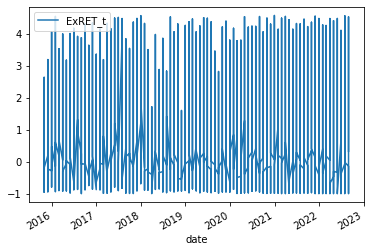

In [ ]:
z = test_plot['ExRET_t'].nsmallest(len(test_plot)- 1000).to_frame()
z.index = pd.to_datetime(z.index)
#z = np.log(z+1)
z.plot()

In [ ]:
import numpy as np
import pandas as pd
df = pd.DataFrame(np.random.randint(0,1000,size=(1000, 1)), columns=list('A'))
df[df['A'] != df['A'].nlargest()]

In [ ]:
df['A'].nsmallest(len(df)-10)

584      0
261      2
817      2
853      2
76       4
      ... 
42     994
523    994
866    994
979    994
775    995
Name: A, Length: 990, dtype: int64

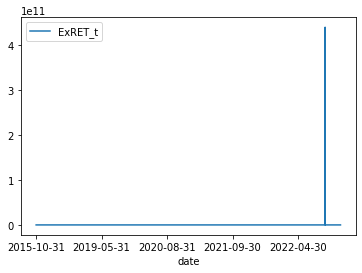

In [ ]:
test_plot.set_index('date', inplace=True)
test_plot.plot()

Text(0.5, 54.05224596215565, 'Date')

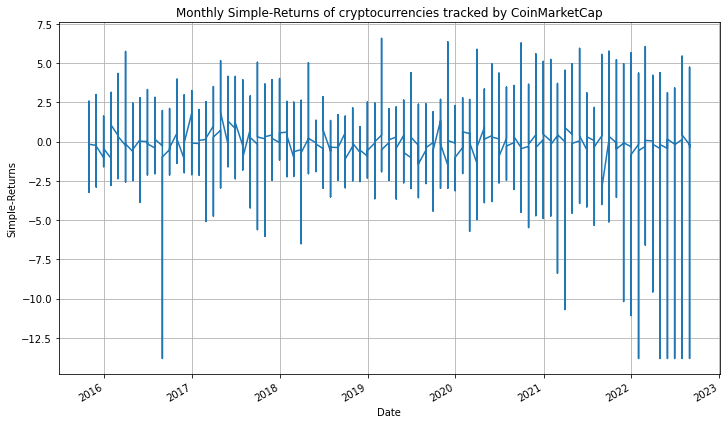

In [ ]:
#a.set_index('date', inplace=True)
#plt.plot(a['log_ret'])

z.plot(legend=0, figsize=(10,6), grid=True, title='Monthly Simple-Returns of cryptocurrencies tracked by CoinMarketCap')
plt.tight_layout()
plt.ylabel('Simple-Returns')
plt.xlabel('Date')
#plt.savefig('/drive/My Drive/Colab Notebooks/Monthly_pct_returns3.png', dpi=100)

In [ ]:
log_prices = np.log(plo+1)

Text(0.5, 33.0, 'Date')

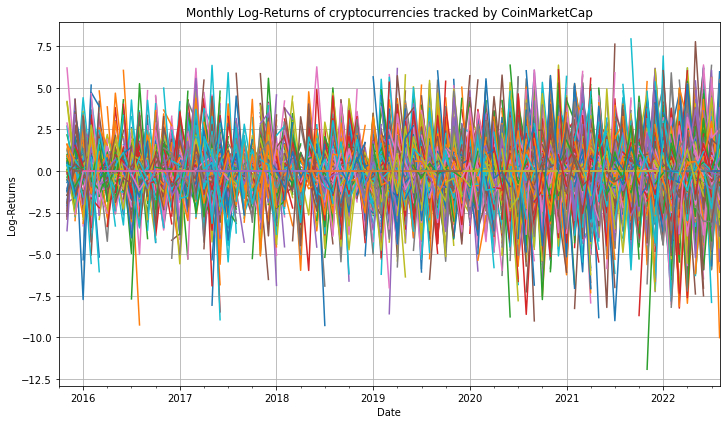

In [ ]:
log_prices.plot(legend=0, figsize=(10,6), grid=True, title='Monthly Log-Returns of cryptocurrencies tracked by CoinMarketCap')
plt.tight_layout()
plt.ylabel('Log-Returns')
plt.xlabel('Date')
#plt.savefig('/drive/My Drive/Colab Notebooks/Monthly_log_returns3.png', dpi=100)

## Continue

In [ ]:
not_win.reset_index(inplace=True)
not_win['year_month'] = not_win['date'].astype(str).str[:7]

In [ ]:
dates = list(not_win['year_month'].unique())

F_Ret_not_win = pd.DataFrame(columns =
                  ['year_month',
                   'Return',
                   'MktPrem',
                   'FFSMB',
                   'FFDMU',
                   'FFMOM',
                   #'FFVOL',
                   #'MOMcu',
                   'DMU',
                   'MOM',
                   'SizeB',
                   #'SizeMS',
                   'LogVol',
                   'LogVolAdj',
                   'Beta',
                   'Trend',
                   'Lot',
                   'Vola'
                  ])
F_Ret_not_winIndex = 0 
for i in dates:
    F_Ret_not_win.loc[F_Ret_not_winIndex] = [i, 
                    calcReturn(not_win.loc[not_win['year_month'] == i]),  
                    calcMktPrem(not_win.loc[not_win['year_month'] == i]), 
                    calcFFSMB(not_win.loc[not_win['year_month'] == i]), 
                    calcFFDMU(not_win.loc[not_win['year_month'] == i]),
                    calcFFMOM(not_win.loc[not_win['year_month'] == i]),
                    #calcFFVOL(not_win.loc[not_win['year_month'] == i]), 
                    #calcMOMcu(not_win.loc[not_win['year_month'] == i]), 
                    calcShortRev(not_win.loc[not_win['year_month'] == i]), 
                    calcMOM(not_win.loc[not_win['year_month'] == i]), 
                    calcSizeB(not_win.loc[not_win['year_month'] == i]),
                    #calcSizeMS(not_win.loc[not_win['year_month'] == i]), 
                    calcLogVol(not_win.loc[not_win['year_month'] == i]), 
                    calcLogVolAdj(not_win.loc[not_win['year_month'] == i]), 
                    calcBeta(not_win.loc[not_win['year_month'] == i]), 
                    calcTrend(not_win.loc[not_win['year_month'] == i]),
                    calcLot(not_win.loc[not_win['year_month']==i]),
                    calcVola(not_win.loc[not_win['year_month']==i])
                   ]
    F_Ret_not_winIndex += 1
F_Ret_not_win['year_month'] = F_Ret_not_win['year_month']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

In [ ]:
F_Ret_not_win.mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


Return        196.946481
MktPrem         0.086105
FFSMB         449.435637
FFDMU         448.692540
FFMOM        -740.392313
DMU          1277.456148
MOM         -1925.732900
SizeB         485.455114
LogVol         -2.424957
LogVolAdj    1946.039030
Beta          662.467841
Trend       -1948.546515
Lot          -642.702667
Vola           -0.761340
dtype: float64

In [ ]:
dates = list(win['year_month'].unique())

F_Ret_win = pd.DataFrame(columns =
                  ['year_month',
                   'Return',
                   'MktPrem',
                   'FFSMB',
                   'FFDMU',
                   'FFMOM',
                   #'FFVOL',
                   #'MOMcu',
                   'DMU',
                   'MOM',
                   'SizeB',
                   #'SizeMS',
                   'LogVol',
                   'LogVolAdj',
                   'Beta',
                   'Trend',
                   'Lot',
                   'Vola'
                  ])
F_Ret_winIndex = 0 
for i in dates:
    F_Ret_win.loc[F_Ret_winIndex] = [i, 
                    calcReturn(win.loc[win['year_month'] == i]),  
                    calcMktPrem(win.loc[win['year_month'] == i]), 
                    calcFFSMB(win.loc[win['year_month'] == i]), 
                    calcFFDMU(win.loc[win['year_month'] == i]),
                    calcFFMOM(win.loc[win['year_month'] == i]),
                    #calcFFVOL(win.loc[win['year_month'] == i]), 
                    #calcMOMcu(win.loc[win['year_month'] == i]), 
                    calcShortRev(win.loc[win['year_month'] == i]), 
                    calcMOM(win.loc[win['year_month'] == i]), 
                    calcSizeB(win.loc[win['year_month'] == i]),
                    #calcSizeMS(win.loc[win['year_month'] == i]), 
                    calcLogVol(win.loc[win['year_month'] == i]), 
                    calcLogVolAdj(win.loc[win['year_month'] == i]), 
                    calcBeta(win.loc[win['year_month'] == i]), 
                    calcTrend(win.loc[win['year_month'] == i]),
                    calcLot(win.loc[win['year_month']==i]),
                    calcVola(win.loc[win['year_month']==i])
                   ]
    F_Ret_winIndex += 1
F_Ret_win['year_month'] = F_Ret_win['year_month']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

In [ ]:
hist_not_win = F_Ret_not_win[['MktPrem', 'DMU', 'MOM', 'SizeB', 'LogVol', 'LogVolAdj', 'Beta', 'Trend', 'Lot', 'Vola']].dropna()

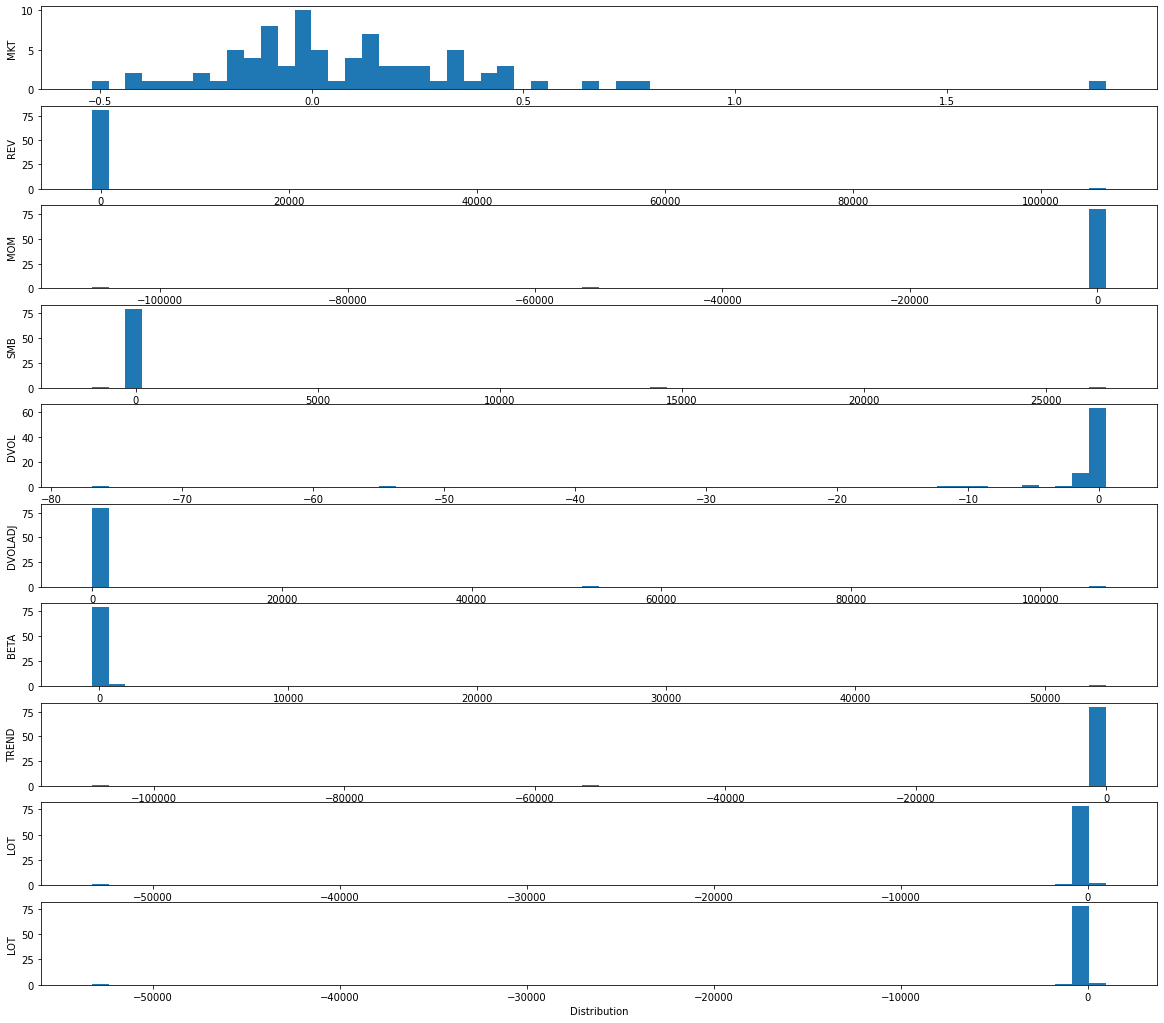

In [ ]:
fig = plt.figure(figsize=(20,18))
ax1 = fig.add_subplot(10, 1, 1)
ax2 = fig.add_subplot(10, 1, 2)
ax3 = fig.add_subplot(10, 1, 3)
ax4 = fig.add_subplot(10, 1, 4)
ax5 = fig.add_subplot(10, 1, 5)
ax6 = fig.add_subplot(10, 1, 6)
ax7 = fig.add_subplot(10, 1, 7)
ax8 = fig.add_subplot(10, 1, 8)
ax9 = fig.add_subplot(10, 1, 9)
ax10 = fig.add_subplot(10, 1, 10)

n, bins, patches = ax1.hist(hist_not_win['MktPrem'], bins=60)
ax1.set_xlabel('Distribution')
ax1.set_ylabel('MKT')

n, bins, patches = ax2.hist(hist_not_win['DMU'], bins=60)
ax2.set_xlabel('Distribution')
ax2.set_ylabel('REV')

n, bins, patches = ax3.hist(hist_not_win['MOM'],bins=60)
ax3.set_xlabel('Distribution')
ax3.set_ylabel('MOM')

n, bins, patches = ax4.hist(hist_not_win['SizeB'],bins=60)
ax4.set_xlabel('Distribution')
ax4.set_ylabel('SMB')

n, bins, patches = ax5.hist(hist_not_win['LogVol'],bins=60)
ax5.set_xlabel('Distribution')
ax5.set_ylabel('DVOL')

n, bins, patches = ax6.hist(hist_not_win['LogVolAdj'],bins=60)
ax6.set_xlabel('Distribution')
ax6.set_ylabel('DVOLADJ')

n, bins, patches = ax7.hist(hist_not_win['Beta'],bins=60)
ax7.set_xlabel('Distribution')
ax7.set_ylabel('BETA')

n, bins, patches = ax8.hist(hist_not_win['Trend'],bins=60)
ax8.set_xlabel('Distribution')
ax8.set_ylabel('TREND')

n, bins, patches = ax9.hist(hist_not_win['Lot'],bins=60)
ax9.set_xlabel('Distribution')
ax9.set_ylabel('LOT')

n, bins, patches = ax10.hist(hist_not_win['Vola'],bins=60)
ax10.set_xlabel('Distribution')
ax10.set_ylabel('Vola')

plt.savefig('/drive/My Drive/Colab Notebooks/Returns_not_winsorized.png', dpi=300)

In [ ]:
hist_win = F_Ret_win[['MktPrem', 'DMU', 'MOM', 'SizeB', 'LogVol', 'LogVolAdj', 'Beta', 'Trend', 'Lot', 'Vola']].dropna()

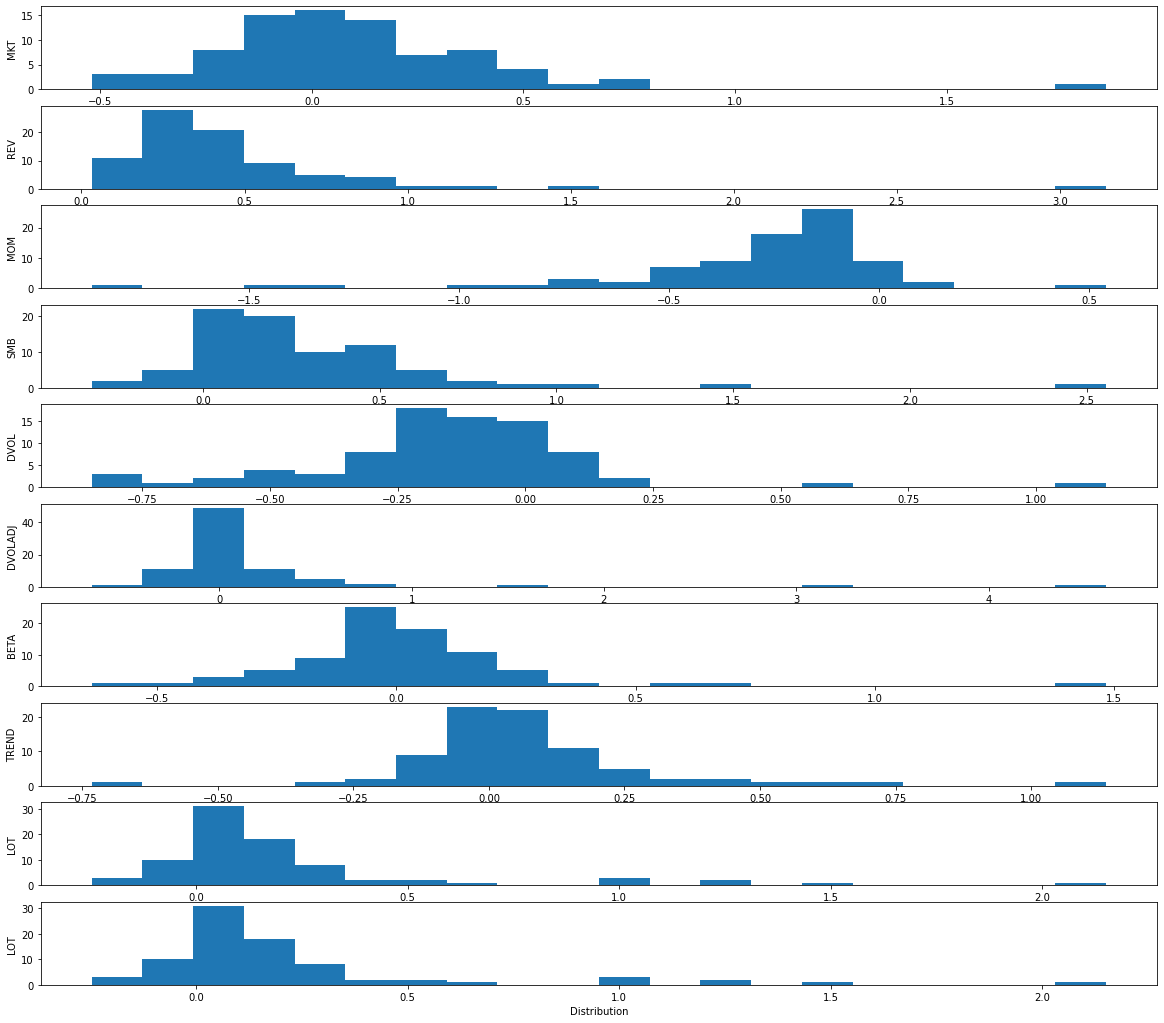

In [ ]:
fig = plt.figure(figsize=(20,18))
ax1 = fig.add_subplot(10, 1, 1)
ax2 = fig.add_subplot(10, 1, 2)
ax3 = fig.add_subplot(10, 1, 3)
ax4 = fig.add_subplot(10, 1, 4)
ax5 = fig.add_subplot(10, 1, 5)
ax6 = fig.add_subplot(10, 1, 6)
ax7 = fig.add_subplot(10, 1, 7)
ax8 = fig.add_subplot(10, 1, 8)
ax9 = fig.add_subplot(10, 1, 9)
ax10 = fig.add_subplot(10, 1, 10)

n, bins, patches = ax1.hist(hist_win['MktPrem'], bins=20)
ax1.set_xlabel('Distribution')
ax1.set_ylabel('MKT')

n, bins, patches = ax2.hist(hist_win['DMU'], bins=20)
ax2.set_xlabel('Distribution')
ax2.set_ylabel('REV')

n, bins, patches = ax3.hist(hist_win['MOM'],bins=20)
ax3.set_xlabel('Distribution')
ax3.set_ylabel('MOM')

n, bins, patches = ax4.hist(hist_win['SizeB'],bins=20)
ax4.set_xlabel('Distribution')
ax4.set_ylabel('SMB')

n, bins, patches = ax5.hist(hist_win['LogVol'],bins=20)
ax5.set_xlabel('Distribution')
ax5.set_ylabel('DVOL')

n, bins, patches = ax6.hist(hist_win['LogVolAdj'],bins=20)
ax6.set_xlabel('Distribution')
ax6.set_ylabel('DVOLADJ')

n, bins, patches = ax7.hist(hist_win['Beta'],bins=20)
ax7.set_xlabel('Distribution')
ax7.set_ylabel('BETA')

n, bins, patches = ax8.hist(hist_win['Trend'],bins=20)
ax8.set_xlabel('Distribution')
ax8.set_ylabel('TREND')

n, bins, patches = ax9.hist(hist_win['Lot'],bins=20)
ax9.set_xlabel('Distribution')
ax9.set_ylabel('LOT')

n, bins, patches = ax10.hist(hist_win['Vola'],bins=20)
ax10.set_xlabel('Distribution')
ax10.set_ylabel('Vola')

plt.savefig('/drive/My Drive/Colab Notebooks/Returns_winsorized.png', dpi=300)

In [ ]:
F_Ret_win.set_index('year_month', inplace=True)

In [ ]:
F_Ret_not_win.head(10)

,year_month,Return,MktPrem,FFSMB,FFDMU,FFMOM,DMU,MOM,SizeB,LogVol,LogVolAdj,Beta,Trend,Lot,Vola
0,2015-10,0.1387,0.3710,0.6409,1.1916,-0.8499,1.1713,-0.7357,0.8052,-0.6646,0.1970,-0.1677,NaN,0.7920,0.9713
1,2015-11,0.0902,0.2310,-0.0665,0.2225,-0.1487,0.4101,-0.3181,-0.0991,-0.0421,-0.2500,0.0368,0.0743,-0.0096,-0.0004
2,2015-12,0.3658,0.1405,0.7952,-0.0693,-0.5815,0.6294,0.0985,0.7578,0.1507,0.5896,0.5872,0.1826,0.5142,0.7811
3,2016-01,0.8716,-0.1752,3.2416,2.8509,-2.4698,0.2880,-0.4299,3.7497,-3.0523,0.6745,-0.6311,0.6900,0.9867,0.8414
4,2016-02,1.5495,0.1415,7.9277,0.1855,25.1244,0.3506,10.1765,11.5126,-10.9551,10.6805,-0.1643,1.2924,10.7796,11.1823
5,2016-03,0.0426,-0.1070,0.7996,0.1289,-0.6107,0.2242,-0.2677,0.8476,-0.9568,-0.0606,-0.2353,0.1476,0.4079,0.4570
6,2016-04,-0.0133,0.1218,0.4951,-0.1002,-0.3084,0.2640,-0.1872,0.5059,-0.2959,-0.0776,-0.0338,0.1431,0.1789,0.1495
7,2016-05,0.3416,0.1448,-0.2042,0.0357,-0.1968,0.1472,-0.3098,-0.2320,0.0939,-0.3583,0.0715,0.2617,0.0266,-0.1828
8,2016-06,0.2780,0.3160,0.4503,0.5739,-0.3812,0.9568,-0.5198,0.7522,-0.2569,-0.0767,-0.1220,0.3224,0.5576,0.5791
9,2016-07,0.1292,-0.0966,0.1606,0.1045,-0.0876,0.8323,-0.6772,0.1036,-0.0107,-0.2938,0.0786,-0.1812,0.2796,0.4507


In [ ]:
not_win[not_win['year_month']=='2017-03']['ExRET_t1'].nlargest()

5708    171.649809
5881    126.856354
5709    110.817872
5735     20.743111
5769      9.369900
Name: ExRET_t1, dtype: float64

In [ ]:
win[win['year_month']=='2017-03']['ExRET_t1'].nlargest()

5708    20.743111
5709    20.743111
5735    20.743111
5881    20.743111
5769     9.369900
Name: ExRET_t1, dtype: float64

In [ ]:
describex(F_Ret_not_win[['year_month', 'Return', 'MktPrem', 'DMU', 'MOM', 'SizeB', 'LogVol', 'LogVolAdj', 'Beta', 'Trend', 'Lot','Vola']].dropna()*100).T.round(3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


,count,mean,std,min,5%,25%,50%,75%,95%,max,Kurt,Skew
Return,82.0,19934.658,131676.231,-40.74,-22.334,7.468,32.055,86.395,1016.071,1073647.20,54.469,7.230
MktPrem,82.0,8.263,32.753,-51.99,-34.892,-9.570,1.445,22.825,51.923,187.64,10.154,2.164
DMU,82.0,129302.060,1181082.799,-97440.19,-15.624,23.610,44.125,118.375,375.928,10693593.64,81.986,9.054
MOM,82.0,-194920.848,1316868.365,-10733205.27,-1344.447,-125.982,-42.870,-14.940,65.016,97409.06,54.477,-7.230
SizeB,82.0,49136.548,334165.949,-120915.13,-4.299,26.598,46.700,139.080,4320.485,2665338.09,51.030,7.015
LogVol,82.0,-244.642,1042.146,-7691.21,-856.148,-61.365,-25.250,-8.515,11.991,56.15,39.750,-6.191
LogVolAdj,82.0,196976.881,1312577.530,-7660.41,-116.268,-11.792,2.195,89.432,4708.859,10693406.15,54.356,7.223
Beta,82.0,67054.876,588225.690,-39620.44,-226.183,-15.785,2.000,48.887,518.273,5326321.21,81.846,9.043
Trend,82.0,-194854.651,1308859.864,-10653940.85,-111.466,-9.690,4.275,25.360,146.340,1591.31,54.239,-7.216
Lot,82.0,-65055.016,588432.349,-5326284.42,-73.992,8.152,26.950,126.152,565.603,97469.56,81.853,-9.043


In [ ]:
latexformatter(describex(F_Ret_not_win[['year_month', 'Return', 'MktPrem', 'DMU', 'MOM', 'SizeB', 'LogVol', 'LogVolAdj', 'Beta', 'Trend', 'Lot','Vola']].dropna()*100).T.round(3)).to_latex()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


'\\begin{tabular}{lllllllllllll}\n\\toprule\n{} & count &          mean &          std &            min &          5\\% &        25\\% &      50\\% &      75\\% &       95\\% &          max &    Kurt &     Skew \\\\\n\\midrule\nReturn    &  82.0 &     19934.658 &   131676.231 &        (40.74) &    (22.334) &      7.468 &   32.055 &   86.395 &  1016.071 &    1073647.2 &  54.469 &     7.23 \\\\\nMktPrem   &  82.0 &         8.263 &       32.753 &        (51.99) &    (34.892) &     (9.57) &    1.445 &   22.825 &    51.923 &       187.64 &  10.154 &    2.164 \\\\\nDMU       &  82.0 &     129302.06 &  1181082.799 &     (97440.19) &    (15.624) &      23.61 &   44.125 &  118.375 &   375.928 &  10693593.64 &  81.986 &    9.054 \\\\\nMOM       &  82.0 &  (194920.848) &  1316868.365 &  (10733205.27) &  (1344.447) &  (125.982) &  (42.87) &  (14.94) &    65.016 &     97409.06 &  54.477 &   (7.23) \\\\\nSizeB     &  82.0 &     49136.548 &   334165.949 &    (120915.13) &     (4.299) &     26.598 &  

In [ ]:
describex(F_Ret_win[['Return', 'MktPrem', 'DMU', 'MOM', 'SizeB', 'LogVol', 'LogVolAdj', 'Beta', 'Trend', 'Lot','Vola']].dropna()*100).T.round(3)

,count,mean,std,min,5%,25%,50%,75%,95%,max,Kurt,Skew
Return,82.0,18.794,43.465,-42.96,-24.239,-5.555,9.700,28.905,114.238,209.28,5.569,2.063
MktPrem,82.0,8.263,32.753,-51.99,-34.892,-9.570,1.445,22.825,51.923,187.64,10.154,2.164
DMU,82.0,44.082,39.955,3.13,10.713,23.365,34.695,56.822,93.384,314.28,25.619,4.213
MOM,82.0,-28.684,33.821,-187.38,-87.989,-37.510,-22.710,-8.765,4.451,54.04,7.421,-2.151
SizeB,82.0,29.060,38.302,-31.48,-9.544,7.230,21.225,44.420,74.536,255.52,15.221,3.087
LogVol,82.0,-15.474,27.698,-84.90,-63.554,-25.455,-13.855,-1.225,12.295,113.71,5.850,0.755
LogVolAdj,82.0,14.073,67.977,-66.33,-22.970,-11.440,-3.395,12.718,66.357,461.20,27.976,4.910
Beta,82.0,1.169,25.815,-63.74,-32.622,-9.840,-2.265,8.475,29.685,148.45,13.064,2.357
Trend,82.0,7.039,22.905,-73.24,-15.112,-3.480,2.965,14.062,45.345,113.82,7.100,1.246
Lot,82.0,21.504,38.010,-24.69,-9.552,3.298,9.870,22.745,103.743,215.16,9.466,2.811


In [ ]:
latexformatter(describex(F_Ret_win[['Return', 'MktPrem', 'DMU', 'MOM', 'SizeB', 'LogVol', 'LogVolAdj', 'Beta', 'Trend', 'Lot','Vola']].dropna()*100).T.round(3)).to_latex()

'\\begin{tabular}{lllllllllllll}\n\\toprule\n{} & count &      mean &     std &       min &        5\\% &       25\\% &       50\\% &      75\\% &      95\\% &     max &    Kurt &     Skew \\\\\n\\midrule\nReturn    &  82.0 &    18.794 &  43.465 &   (42.96) &  (24.239) &   (5.555) &       9.7 &   28.905 &  114.238 &  209.28 &   5.569 &    2.063 \\\\\nMktPrem   &  82.0 &     8.263 &  32.753 &   (51.99) &  (34.892) &    (9.57) &     1.445 &   22.825 &   51.923 &  187.64 &  10.154 &    2.164 \\\\\nDMU       &  82.0 &    44.082 &  39.955 &      3.13 &    10.713 &    23.365 &    34.695 &   56.822 &   93.384 &  314.28 &  25.619 &    4.213 \\\\\nMOM       &  82.0 &  (28.684) &  33.821 &  (187.38) &  (87.989) &   (37.51) &   (22.71) &  (8.765) &    4.451 &   54.04 &   7.421 &  (2.151) \\\\\nSizeB     &  82.0 &     29.06 &  38.302 &   (31.48) &   (9.544) &      7.23 &    21.225 &    44.42 &   74.536 &  255.52 &  15.221 &    3.087 \\\\\nLogVol    &  82.0 &  (15.474) &  27.698 &    (84.9) &  (63.

In [ ]:
F_Ret = F_Ret_win[['Return', 'MktPrem', 'DMU', 'MOM', 'SizeB', 'LogVol', 'LogVolAdj', 'Beta', 'Trend', 'Lot','Vola']].dropna()

In [ ]:
calcCorr(F_Ret)

,Return,MktPrem,DMU,MOM,SizeB,LogVol,LogVolAdj,Beta,Trend,Lot,Vola
Return,1.000000,0.317748,0.594141,-0.401813,0.384489,0.025130,0.481040,-0.128994,0.292433,0.693052,0.721851
MktPrem,0.303114,1.000000,0.217913,-0.047659,0.086885,0.090759,0.176295,0.054440,0.235315,0.398409,0.369676
DMU,0.704338,0.247034,1.000000,-0.585848,0.363550,-0.009110,0.308143,0.022736,0.197278,0.490444,0.563115
MOM,-0.577994,-0.009557,-0.527924,1.000000,-0.437819,0.184326,-0.029201,0.132596,-0.174432,-0.380679,-0.429634
SizeB,0.423006,-0.015754,0.186325,-0.538824,1.000000,-0.634447,0.057668,-0.133620,0.196777,0.451970,0.532238
LogVol,0.176148,0.062024,0.406194,0.025613,-0.456452,1.000000,0.327527,-0.046419,0.042163,-0.130627,-0.209512
LogVolAdj,0.784902,0.191759,0.733367,-0.470815,0.129060,0.371902,1.000000,0.018546,0.190760,0.389162,0.412987
Beta,0.123125,-0.036931,-0.032967,-0.287091,0.288736,-0.071963,0.083012,1.000000,0.011047,-0.252721,-0.194525
Trend,0.514131,0.165369,0.537780,-0.208789,0.130295,0.255276,0.625215,0.041799,1.000000,0.220362,0.281006
Lot,0.813761,0.309781,0.719208,-0.477809,0.285675,0.148403,0.814038,-0.128625,0.435628,1.000000,0.929963


In [ ]:
latexformatter(calcCorr(F_Ret).round(4)).to_latex()

'\\begin{tabular}{llllllllllll}\n\\toprule\n{} &   Return &   MktPrem &       DMU &       MOM &     SizeB &    LogVol & LogVolAdj &      Beta &     Trend &       Lot &      Vola \\\\\n\\midrule\nReturn    &      1.0 &    0.3177 &    0.5941 &  (0.4018) &    0.3845 &    0.0251 &     0.481 &   (0.129) &    0.2924 &    0.6931 &    0.7219 \\\\\nMktPrem   &   0.3031 &       1.0 &    0.2179 &  (0.0477) &    0.0869 &    0.0908 &    0.1763 &    0.0544 &    0.2353 &    0.3984 &    0.3697 \\\\\nDMU       &   0.7043 &     0.247 &       1.0 &  (0.5858) &    0.3636 &  (0.0091) &    0.3081 &    0.0227 &    0.1973 &    0.4904 &    0.5631 \\\\\nMOM       &  (0.578) &  (0.0096) &  (0.5279) &       1.0 &  (0.4378) &    0.1843 &  (0.0292) &    0.1326 &  (0.1744) &  (0.3807) &  (0.4296) \\\\\nSizeB     &    0.423 &  (0.0158) &    0.1863 &  (0.5388) &       1.0 &  (0.6344) &    0.0577 &  (0.1336) &    0.1968 &     0.452 &    0.5322 \\\\\nLogVol    &   0.1761 &     0.062 &    0.4062 &    0.0256 &  (0.4565) &

In [ ]:
win['market_cap'] /= 1_000_000

In [ ]:
win.columns

Index(['date', 'ExRET_t', 'ExRET_t1', 'Lot', 'RV', 'price', 'market_cap',
       'Beta', 'Trend', 'av_Vol', 'Index_level', 'pct_change_M', 'SizeB',
       'SizeMS', 'LogVol', 'LogVolAdj', 'Momentum', 'year_month'],
      dtype='object')

# Momentum

In [ ]:
tests = win[win['Momentum'].notna()]
tests
indexname = 'MOM'
# calculate the SMB Returns
def SSMB(df):
    """
    Returns SMB portfolio returns
    """
    df['SMB'] = ''
    
    #list of bin labels from 1-10
    bin_labels = list(range(1,11,1))

    #cut the column into 10 equal portfolios
    df.SMB = pd.qcut(df['Momentum'], 
                     q=10, 
                     labels=bin_labels, 
                     duplicates='drop')
    
    #store the returns in a list
    helplist = []
    for bin in bin_labels:
      ret = round(df['ExRET_t1']
                  .loc[df['SMB'] == bin]
                  .mean()
                  ,4)
      beta = round(df['Beta']
                  .loc[df['SMB'] == bin]
                  .mean()
                  ,4)
      market_cap = round(df['market_cap']
                  .loc[df['SMB'] == bin]
                  .mean()
                  ,4)
      size = round(df['SizeB']
                  .loc[df['SMB'] == bin]
                  .mean()
                  ,4)
      helplist.append([ret, beta, market_cap, size])

    return helplist

# What to iterate through
dates = list(tests['year_month'].unique())

#new DataFrame
Port = pd.DataFrame(columns 
                    = ['year_month',
                       'Returns'])

#Call the function
PortIndex = 0
for i in dates:
  Port.loc[PortIndex] = [i,
                         SSMB(tests.loc[tests['year_month']==i])
                         ]
  PortIndex += 1

for col in range(10):
  Port[f'P_{(col+1)*10}'] = ''

for i in range(len(Port)):
  for ret in range(10):
    Port[f'P_{(ret+1)*10}'].iloc[i] = Port.iloc[i]['Returns'][ret]

Port = Port[['year_month',
             'P_10',
             'P_20',
             'P_30',
             'P_40',
             'P_50',
             'P_60',
             'P_70',
             'P_80',
             'P_90',
             'P_100']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
new_df = pd.DataFrame()
for col in Port.columns:
  if col == 'year_month':
    continue
  else:
    help = pd.DataFrame(Port[col].to_list(), 
                        columns=[f'{col}_Ret',
                                 f'{col}_Beta',
                                 f'{col}_market_cap', 
                                 f'{col}_Size'])
    new_df = pd.concat([new_df, help], axis=1)
new_df.index = Port['year_month']

In [ ]:
j = 4
k = 10
averages_MOM = pd.DataFrame()
for i in range(0,40,4):
  a = pd.DataFrame(new_df.median()[i:j].values, columns=[f'P_{k}'], index=['$r_{t+1}$','Beta','MktCap', 'Size'])
  averages_MOM = pd.concat([averages_MOM, a], axis=1)
  k+=10
  j+=4

averages_MOM.index.name = indexname
averages_MOM.iloc[0] *= 100

In [ ]:
averages_MOM.round(2)

,P_10,P_20,P_30,P_40,P_50,P_60,P_70,P_80,P_90,P_100
MOM,,,,,,,,,,
$r_{t+1}$,26.00,14.41,9.50,8.03,5.71,7.78,7.78,4.45,3.29,0.57
Beta,0.57,0.63,0.62,0.61,0.62,0.64,0.65,0.64,0.65,0.60
MktCap,0.84,2.07,5.38,13.45,31.01,56.55,160.34,252.08,258.83,199.67
Size,10.97,12.01,12.60,13.02,13.20,13.69,13.81,13.99,14.24,14.67


# Short Term Reversal

In [ ]:
tests = win[win['ExRET_t'].notna()]
tests
indexname = 'REV'
# calculate the SMB Returns
def SSMB(df):
    """
    Returns SMB portfolio returns
    """
    df['SMB'] = ''
    
    #list of bin labels from 1-10
    bin_labels = list(range(1,11,1))

    #cut the column into 10 equal portfolios
    df.SMB = pd.qcut(df['ExRET_t'], 
                     q=10, 
                     labels=bin_labels, 
                     duplicates='drop')
    
    #store the returns in a list
    helplist = []
    for bin in bin_labels:
      ret = round(df['ExRET_t1']
                  .loc[df['SMB'] == bin]
                  .mean()
                  ,4)
      beta = round(df['Beta']
                  .loc[df['SMB'] == bin]
                  .mean()
                  ,4)
      market_cap = round(df['market_cap']
                  .loc[df['SMB'] == bin]
                  .mean()
                  ,4)
      size = round(df['SizeB']
                  .loc[df['SMB'] == bin]
                  .mean()
                  ,4)
      helplist.append([ret, beta, market_cap, size])

    return helplist

# What to iterate through
dates = list(tests['year_month'].unique())

#new DataFrame
Port = pd.DataFrame(columns 
                    = ['year_month',
                       'Returns'])

#Call the function
PortIndex = 0
for i in dates:
  Port.loc[PortIndex] = [i,
                         SSMB(tests.loc[tests['year_month']==i])
                         ]
  PortIndex += 1

for col in range(10):
  Port[f'P_{(col+1)*10}'] = ''

for i in range(len(Port)):
  for ret in range(10):
    Port[f'P_{(ret+1)*10}'].iloc[i] = Port.iloc[i]['Returns'][ret]

Port = Port[['year_month',
             'P_10',
             'P_20',
             'P_30',
             'P_40',
             'P_50',
             'P_60',
             'P_70',
             'P_80',
             'P_90',
             'P_100']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
new_df = pd.DataFrame()
for col in Port.columns:
  if col == 'year_month':
    continue
  else:
    help = pd.DataFrame(Port[col].to_list(), 
                        columns=[f'{col}_Ret',
                                 f'{col}_Beta',
                                 f'{col}_market_cap', 
                                 f'{col}_Size'])
    new_df = pd.concat([new_df, help], axis=1)
new_df.index = Port['year_month']

In [ ]:
j = 4
k = 10
averages_REV = pd.DataFrame()
for i in range(0,40,4):
  a = pd.DataFrame(new_df.median()[i:j].values, columns=[f'P_{k}'], index=['$r_{t+1}$','Beta','MktCap', 'Size'])
  averages_REV = pd.concat([averages_REV, a], axis=1)
  k+=10
  j+=4

averages_REV.index.name = indexname
averages_REV.iloc[0] *= 100

In [ ]:
averages_REV.round(2)

,P_10,P_20,P_30,P_40,P_50,P_60,P_70,P_80,P_90,P_100
REV,,,,,,,,,,
$r_{t+1}$,33.58,16.24,8.30,4.35,5.70,9.09,6.09,6.58,4.16,-4.85
Beta,0.62,0.64,0.62,0.61,0.63,0.64,0.65,0.61,0.64,0.64
MktCap,2.21,8.00,37.70,73.59,133.06,151.15,127.98,179.35,77.97,21.85
Size,11.41,12.58,13.24,13.77,13.73,13.82,13.39,13.58,13.19,13.06


# Lottery Demand

In [ ]:
tests = win[win['Lot'].notna()]
tests
indexname = 'LOT'
# calculate the SMB Returns
def SSMB(df):
    """
    Returns SMB portfolio returns
    """
    df['SMB'] = ''
    
    #list of bin labels from 1-10
    bin_labels = list(range(1,11,1))

    #cut the column into 10 equal portfolios
    df.SMB = pd.qcut(df['Lot'], 
                     q=10, 
                     labels=bin_labels, 
                     duplicates='drop')
    
    #store the returns in a list
    helplist = []
    for bin in bin_labels:
      ret = round(df['ExRET_t1']
                  .loc[df['SMB'] == bin]
                  .mean()
                  ,4)
      beta = round(df['Beta']
                  .loc[df['SMB'] == bin]
                  .mean()
                  ,4)
      market_cap = round(df['market_cap']
                  .loc[df['SMB'] == bin]
                  .mean()
                  ,4)
      size = round(df['SizeB']
                  .loc[df['SMB'] == bin]
                  .mean()
                  ,4)
      helplist.append([ret, beta, market_cap, size])

    return helplist

# What to iterate through
dates = list(tests['year_month'].unique())

#new DataFrame
Port = pd.DataFrame(columns 
                    = ['year_month',
                       'Returns'])

#Call the function
PortIndex = 0
for i in dates:
  Port.loc[PortIndex] = [i,
                         SSMB(tests.loc[tests['year_month']==i])
                         ]
  PortIndex += 1

for col in range(10):
  Port[f'P_{(col+1)*10}'] = ''

for i in range(len(Port)):
  for ret in range(10):
    Port[f'P_{(ret+1)*10}'].iloc[i] = Port.iloc[i]['Returns'][ret]

Port = Port[['year_month',
             'P_10',
             'P_20',
             'P_30',
             'P_40',
             'P_50',
             'P_60',
             'P_70',
             'P_80',
             'P_90',
             'P_100']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
new_df = pd.DataFrame()
for col in Port.columns:
  if col == 'year_month':
    continue
  else:
    help = pd.DataFrame(Port[col].to_list(), 
                        columns=[f'{col}_Ret',
                                 f'{col}_Beta',
                                 f'{col}_market_cap', 
                                 f'{col}_Size'])
    new_df = pd.concat([new_df, help], axis=1)
new_df.index = Port['year_month']

In [ ]:
j = 4
k = 10
averages_Lot = pd.DataFrame()
for i in range(0,40,4):
  a = pd.DataFrame(new_df.median()[i:j].values, columns=[f'P_{k}'], index=['$r_{t+1}$','Beta','MktCap', 'Size'])
  averages_Lot = pd.concat([averages_Lot, a], axis=1)
  k+=10
  j+=4

averages_Lot.index.name = indexname
averages_Lot.iloc[0] *= 100
averages_Lot.round(2)

,P_10,P_20,P_30,P_40,P_50,P_60,P_70,P_80,P_90,P_100
LOT,,,,,,,,,,
$r_{t+1}$,7.72,5.27,3.23,5.51,9.02,7.53,4.89,9.35,11.84,17.17
Beta,0.50,0.61,0.63,0.65,0.64,0.66,0.65,0.67,0.65,0.62
MktCap,1302.97,245.79,76.08,45.86,25.21,10.67,4.01,3.19,1.88,1.20
Size,14.15,14.79,14.70,14.15,13.59,13.15,12.71,12.16,11.77,11.38


# VOLA

In [ ]:
tests = win[win['RV'].notna()]
tests
indexname = 'VOLA'
# calculate the SMB Returns
def SSMB(df):
    """
    Returns SMB portfolio returns
    """
    df['SMB'] = ''
    
    #list of bin labels from 1-10
    bin_labels = list(range(1,11,1))

    #cut the column into 10 equal portfolios
    df.SMB = pd.qcut(df['RV'], 
                     q=10, 
                     labels=bin_labels, 
                     duplicates='drop')
    
    #store the returns in a list
    helplist = []
    for bin in bin_labels:
      ret = round(df['ExRET_t1']
                  .loc[df['SMB'] == bin]
                  .mean()
                  ,4)
      beta = round(df['Beta']
                  .loc[df['SMB'] == bin]
                  .mean()
                  ,4)
      market_cap = round(df['market_cap']
                  .loc[df['SMB'] == bin]
                  .mean()
                  ,4)
      size = round(df['SizeB']
                  .loc[df['SMB'] == bin]
                  .mean()
                  ,4)
      helplist.append([ret, beta, market_cap, size])

    return helplist

# What to iterate through
dates = list(tests['year_month'].unique())

#new DataFrame
Port = pd.DataFrame(columns 
                    = ['year_month',
                       'Returns'])

#Call the function
PortIndex = 0
for i in dates:
  Port.loc[PortIndex] = [i,
                         SSMB(tests.loc[tests['year_month']==i])
                         ]
  PortIndex += 1

for col in range(10):
  Port[f'P_{(col+1)*10}'] = ''

for i in range(len(Port)):
  for ret in range(10):
    Port[f'P_{(ret+1)*10}'].iloc[i] = Port.iloc[i]['Returns'][ret]

Port = Port[['year_month',
             'P_10',
             'P_20',
             'P_30',
             'P_40',
             'P_50',
             'P_60',
             'P_70',
             'P_80',
             'P_90',
             'P_100']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
new_df = pd.DataFrame()
for col in Port.columns:
  if col == 'year_month':
    continue
  else:
    help = pd.DataFrame(Port[col].to_list(), 
                        columns=[f'{col}_Ret',
                                 f'{col}_Beta',
                                 f'{col}_market_cap', 
                                 f'{col}_Size'])
    new_df = pd.concat([new_df, help], axis=1)
new_df.index = Port['year_month']

In [ ]:
j = 4
k = 10
averages_VOLA = pd.DataFrame()
for i in range(0,40,4):
  a = pd.DataFrame(new_df.median()[i:j].values, columns=[f'P_{k}'], index=['$r_{t+1}$','Beta','MktCap', 'Size'])
  averages_VOLA = pd.concat([averages_VOLA, a], axis=1)
  k+=10
  j+=4

averages_VOLA.index.name = indexname
averages_VOLA.iloc[0] *= 100
averages_VOLA.round(2)

,P_10,P_20,P_30,P_40,P_50,P_60,P_70,P_80,P_90,P_100
VOLA,,,,,,,,,,
$r_{t+1}$,7.31,4.59,5.87,5.22,7.86,8.90,8.65,9.32,11.70,19.16
Beta,0.49,0.60,0.65,0.65,0.66,0.66,0.65,0.64,0.65,0.61
MktCap,1688.77,109.28,76.89,28.20,16.38,6.37,3.59,2.29,1.74,1.22
Size,14.95,15.22,14.61,14.05,13.39,12.98,12.56,11.93,11.66,11.36


# Beta

In [ ]:
tests = win[win['Beta'].notna()]
tests
indexname = 'Beta'
# calculate the SMB Returns
def SSMB(df):
    """
    Returns SMB portfolio returns
    """
    df['SMB'] = ''
    
    #list of bin labels from 1-10
    bin_labels = list(range(1,11,1))

    #cut the column into 10 equal portfolios
    df.SMB = pd.qcut(df['Beta'], 
                     q=10, 
                     labels=bin_labels, 
                     duplicates='drop')
    
    #store the returns in a list
    helplist = []
    for bin in bin_labels:
      ret = round(df['ExRET_t1']
                  .loc[df['SMB'] == bin]
                  .mean()
                  ,4)
      beta = round(df['Beta']
                  .loc[df['SMB'] == bin]
                  .mean()
                  ,4)
      market_cap = round(df['market_cap']
                  .loc[df['SMB'] == bin]
                  .mean()
                  ,4)
      size = round(df['SizeB']
                  .loc[df['SMB'] == bin]
                  .mean()
                  ,4)
      helplist.append([ret, beta, market_cap, size])

    return helplist

# What to iterate through
dates = list(tests['year_month'].unique())

#new DataFrame
Port = pd.DataFrame(columns 
                    = ['year_month',
                       'Returns'])

#Call the function
PortIndex = 0
for i in dates:
  Port.loc[PortIndex] = [i,
                         SSMB(tests.loc[tests['year_month']==i])
                         ]
  PortIndex += 1

for col in range(10):
  Port[f'P_{(col+1)*10}'] = ''

for i in range(len(Port)):
  for ret in range(10):
    Port[f'P_{(ret+1)*10}'].iloc[i] = Port.iloc[i]['Returns'][ret]

Port = Port[['year_month',
             'P_10',
             'P_20',
             'P_30',
             'P_40',
             'P_50',
             'P_60',
             'P_70',
             'P_80',
             'P_90',
             'P_100']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
new_df = pd.DataFrame()
for col in Port.columns:
  if col == 'year_month':
    continue
  else:
    help = pd.DataFrame(Port[col].to_list(), 
                        columns=[f'{col}_Ret',
                                 f'{col}_Beta',
                                 f'{col}_market_cap', 
                                 f'{col}_Size'])
    new_df = pd.concat([new_df, help], axis=1)
new_df.index = Port['year_month']

In [ ]:
j = 4
k = 10
averages_Beta = pd.DataFrame()
for i in range(0,40,4):
  a = pd.DataFrame(new_df.median()[i:j].values, columns=[f'P_{k}'], index=['$r_{t+1}$','Beta','MktCap', 'Size'])
  averages_Beta = pd.concat([averages_Beta, a], axis=1)
  k+=10
  j+=4

averages_Beta.index.name = indexname
averages_Beta.iloc[0] *= 100
averages_Beta.round(2)

,P_10,P_20,P_30,P_40,P_50,P_60,P_70,P_80,P_90,P_100
Beta,,,,,,,,,,
$r_{t+1}$,8.52,9.42,10.18,9.14,8.98,7.28,8.53,11.66,9.52,10.95
Beta,-0.07,0.29,0.44,0.54,0.63,0.70,0.77,0.83,0.93,1.23
MktCap,53.60,22.37,21.54,51.66,42.31,44.64,90.09,377.58,47.18,5.64
Size,12.20,12.42,13.39,13.54,13.99,13.92,13.68,13.19,12.93,11.79


# Size

In [ ]:
tests = win[win['SizeMS'] != 0]
tests
indexname = 'SMB'
# calculate the SMB Returns
def SSMB(df):
    """
    Returns SMB portfolio returns
    """
    df['SMB'] = ''
    
    #list of bin labels from 1-10
    bin_labels = list(range(1,11,1))

    #cut the column into 10 equal portfolios
    df.SMB = pd.qcut(df['SizeMS'], 
                     q=10, 
                     labels=bin_labels, 
                     duplicates='drop'
                     )
    
    #store the returns in a list
    helplist = []
    for bin in bin_labels:
      ret = round(df['ExRET_t1']
                  .loc[df['SMB'] == bin]
                  .mean()
                  ,4)
      beta = round(df['Beta']
                  .loc[df['SMB'] == bin]
                  .mean()
                  ,4)
      market_cap = round(df['market_cap']
                  .loc[df['SMB'] == bin]
                  .mean()
                  ,4)
      size = round(df['SizeB']
                  .loc[df['SMB'] == bin]
                  .mean()
                  ,4)
      helplist.append([ret, beta, market_cap, size])

    return helplist

# What to iterate through
dates = list(tests['year_month'].unique())

#new DataFrame
Port = pd.DataFrame(columns 
                    = ['year_month',
                       'Returns'])

#Call the function
PortIndex = 0
for i in dates:
  Port.loc[PortIndex] = [i,
                         SSMB(tests.loc[tests['year_month']==i])
                         ]
  PortIndex += 1

for col in range(10):
  Port[f'P_{(col+1)*10}'] = ''

for i in range(len(Port)):
  for ret in range(10):
    Port[f'P_{(ret+1)*10}'].iloc[i] = Port.iloc[i]['Returns'][ret]

Port = Port[['year_month',
             'P_10',
             'P_20',
             'P_30',
             'P_40',
             'P_50',
             'P_60',
             'P_70',
             'P_80',
             'P_90',
             'P_100']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
new_df = pd.DataFrame()
for col in Port.columns:
  if col == 'year_month':
    continue
  else:
    help = pd.DataFrame(Port[col].to_list(), 
                        columns=[f'{col}_Ret',
                                 f'{col}_Beta',
                                 f'{col}_market_cap', 
                                 f'{col}_Size'])
    new_df = pd.concat([new_df, help], axis=1)
new_df.index = Port['year_month']

In [ ]:
j = 4
k = 10
averages_SMB = pd.DataFrame()
for i in range(0,40,4):
  a = pd.DataFrame(new_df.median()[i:j].values, columns=[f'P_{k}'], index=['$r_{t+1}$','Beta','MktCap', 'Size'])
  averages_SMB = pd.concat([averages_SMB, a], axis=1)
  k+=10
  j+=4

averages_SMB.index.name = indexname
averages_SMB.iloc[0] *= 100
averages_SMB.round(2)

,P_10,P_20,P_30,P_40,P_50,P_60,P_70,P_80,P_90,P_100
SMB,,,,,,,,,,
$r_{t+1}$,16.56,13.16,9.35,8.25,8.80,6.36,5.46,3.04,3.65,-1.19
Beta,0.59,0.62,0.64,0.62,0.60,0.62,0.65,0.63,0.60,0.60
MktCap,1.14,1.46,2.66,3.89,6.02,8.30,22.28,53.95,128.35,2020.58
Size,11.17,11.30,11.89,12.20,12.73,13.22,13.89,14.74,15.50,16.77


# TREND

In [ ]:
win[win['Trend'] != 0]

,date,ExRET_t,ExRET_t1,Lot,RV,price,market_cap,Beta,Trend,av_Vol,Index_level,pct_change_M,SizeB,SizeMS,LogVol,LogVolAdj,Momentum,year_month
299,2015-11-30,13.498617,-0.403263,25.421404,83.749008,0.000101,0.002498,0.627957,-0.061563,8.723524,989.273839,0.230994,7.823061,-9.200309,2.166023,11.366332,-0.177489,2015-11
308,2015-11-30,12.427128,0.175058,28.173842,93.921580,0.000014,0.007400,1.162887,0.094364,14.678510,989.273839,0.230994,8.909217,-11.194251,2.686385,13.880635,0.907905,2015-11
310,2015-11-30,2.940805,-0.365635,9.908370,44.509120,0.001228,0.001322,0.326520,0.327501,2.163793,989.273839,0.230994,7.186650,-6.702018,0.771863,7.473881,0.546932,2015-11
312,2015-11-30,22.981212,-0.024881,10.189563,34.107758,0.000328,0.019878,0.215005,-2.977333,8.095576,989.273839,0.230994,9.897355,-8.021660,2.091318,10.112978,0.290268,2015-11
316,2015-11-30,4.957681,-0.102066,16.456355,56.804006,0.000868,0.002107,0.306532,1.201531,1.920551,989.273839,0.230994,7.652924,-7.049489,0.652612,7.702101,1.027688,2015-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92968,2022-08-31,-0.221139,-0.826910,0.007859,0.035942,0.010000,0.000000,-2.336519,8480.349614,0.026774,22685.011886,-0.178879,0.000000,-4.605154,-3.620317,0.984837,-2.706649,2022-08
92969,2022-08-31,0.306031,0.001086,1.266405,4.569122,0.997271,1.468220,0.014349,9.582086,25127.179032,22685.011886,-0.178879,14.199561,-0.002732,10.131705,10.134438,-0.006006,2022-08
92970,2022-08-31,-30.880021,-0.097831,3.912372,21.950543,0.238215,7.792762,-0.048320,0.657047,33080.270000,22685.011886,-0.178879,15.868706,-1.434583,10.406692,11.841275,-0.161227,2022-08
92971,2022-08-31,-26.924389,0.107012,5.155479,27.421100,0.004285,0.000000,-0.581093,2.533387,239845.283226,22685.011886,-0.178879,0.000000,-5.452540,12.387749,17.840290,-1.147820,2022-08


In [ ]:
tests = win[win['Trend'] != 0]
tests
indexname = 'SMB'
# calculate the SMB Returns
def SSMB(df):
    """
    Returns SMB portfolio returns
    """
    df['SMB'] = ''
    
    #list of bin labels from 1-10
    bin_labels = list(range(1,11,1))

    #cut the column into 10 equal portfolios
    df.SMB = pd.qcut(df['Trend'], 
                     q=10, 
                     labels=bin_labels, 
                     duplicates='drop'
                     )
    
    #store the returns in a list
    helplist = []
    for bin in bin_labels:
      ret = round(df['ExRET_t1']
                  .loc[df['SMB'] == bin]
                  .mean()
                  ,4)
      beta = round(df['Beta']
                  .loc[df['SMB'] == bin]
                  .mean()
                  ,4)
      market_cap = round(df['market_cap']
                  .loc[df['SMB'] == bin]
                  .mean()
                  ,4)
      size = round(df['SizeB']
                  .loc[df['SMB'] == bin]
                  .mean()
                  ,4)
      helplist.append([ret, beta, market_cap, size])

    return helplist

# What to iterate through
dates = list(tests['year_month'].unique())

#new DataFrame
Port = pd.DataFrame(columns 
                    = ['year_month',
                       'Returns'])

#Call the function
PortIndex = 0
for i in dates:
  Port.loc[PortIndex] = [i,
                         SSMB(tests.loc[tests['year_month']==i])
                         ]
  PortIndex += 1

for col in range(10):
  Port[f'P_{(col+1)*10}'] = ''

for i in range(len(Port)):
  for ret in range(10):
    Port[f'P_{(ret+1)*10}'].iloc[i] = Port.iloc[i]['Returns'][ret]

Port = Port[['year_month',
             'P_10',
             'P_20',
             'P_30',
             'P_40',
             'P_50',
             'P_60',
             'P_70',
             'P_80',
             'P_90',
             'P_100']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
new_df = pd.DataFrame()
for col in Port.columns:
  if col == 'year_month':
    continue
  else:
    help = pd.DataFrame(Port[col].to_list(), 
                        columns=[f'{col}_Ret',
                                 f'{col}_Beta',
                                 f'{col}_market_cap', 
                                 f'{col}_Size'])
    new_df = pd.concat([new_df, help], axis=1)
new_df.index = Port['year_month']

In [ ]:
j = 4
k = 10
averages_SMB = pd.DataFrame()
for i in range(0,40,4):
  a = pd.DataFrame(new_df.median()[i:j].values, columns=[f'P_{k}'], index=['$r_{t+1}$','Beta','MktCap', 'Size'])
  averages_SMB = pd.concat([averages_SMB, a], axis=1)
  k+=10
  j+=4

averages_SMB.index.name = indexname
averages_SMB.iloc[0] *= 100
averages_SMB.round(2)

,P_10,P_20,P_30,P_40,P_50,P_60,P_70,P_80,P_90,P_100
SMB,,,,,,,,,,
$r_{t+1}$,11.40,-3.70,8.14,-3.26,-0.20,0.45,0.52,3.17,2.22,6.72
Beta,0.59,0.58,0.56,0.64,0.62,0.59,0.62,0.61,0.63,0.60
MktCap,129.41,21.74,157.81,36.87,169.03,20.34,59.50,59.23,64.30,42.71
Size,13.28,12.72,13.28,13.27,13.17,12.90,13.52,13.46,12.90,12.92


# Log Volume

In [ ]:
tests = win[win['LogVol'] != 0]
tests
indexname = 'SMB'
# calculate the SMB Returns
def SSMB(df):
    """
    Returns SMB portfolio returns
    """
    df['SMB'] = ''
    
    #list of bin labels from 1-10
    bin_labels = list(range(1,11,1))

    #cut the column into 10 equal portfolios
    df.SMB = pd.qcut(df['LogVol'], 
                     q=10, 
                     labels=bin_labels, 
                     duplicates='drop'
                     )
    
    #store the returns in a list
    helplist = []
    for bin in bin_labels:
      ret = round(df['ExRET_t1']
                  .loc[df['SMB'] == bin]
                  .mean()
                  ,4)
      beta = round(df['Beta']
                  .loc[df['SMB'] == bin]
                  .mean()
                  ,4)
      market_cap = round(df['market_cap']
                  .loc[df['SMB'] == bin]
                  .mean()
                  ,4)
      size = round(df['SizeB']
                  .loc[df['SMB'] == bin]
                  .mean()
                  ,4)
      helplist.append([ret, beta, market_cap, size])

    return helplist

# What to iterate through
dates = list(tests['year_month'].unique())

#new DataFrame
Port = pd.DataFrame(columns 
                    = ['year_month',
                       'Returns'])

#Call the function
PortIndex = 0
for i in dates:
  Port.loc[PortIndex] = [i,
                         SSMB(tests.loc[tests['year_month']==i])
                         ]
  PortIndex += 1

for col in range(10):
  Port[f'P_{(col+1)*10}'] = ''

for i in range(len(Port)):
  for ret in range(10):
    Port[f'P_{(ret+1)*10}'].iloc[i] = Port.iloc[i]['Returns'][ret]

Port = Port[['year_month',
             'P_10',
             'P_20',
             'P_30',
             'P_40',
             'P_50',
             'P_60',
             'P_70',
             'P_80',
             'P_90',
             'P_100']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
new_df = pd.DataFrame()
for col in Port.columns:
  if col == 'year_month':
    continue
  else:
    help = pd.DataFrame(Port[col].to_list(), 
                        columns=[f'{col}_Ret',
                                 f'{col}_Beta',
                                 f'{col}_market_cap', 
                                 f'{col}_Size'])
    new_df = pd.concat([new_df, help], axis=1)
new_df.index = Port['year_month']

In [ ]:
j = 4
k = 10
averages_LogVol = pd.DataFrame()
for i in range(0,40,4):
  a = pd.DataFrame(new_df.median()[i:j].values, columns=[f'P_{k}'], index=['$r_{t+1}$','Beta','MktCap', 'Size'])
  averages_LogVol = pd.concat([averages_LogVol, a], axis=1)
  k+=10
  j+=4

averages_LogVol.index.name = indexname
averages_LogVol.iloc[0] *= 100
averages_LogVol.round(2)

,P_10,P_20,P_30,P_40,P_50,P_60,P_70,P_80,P_90,P_100
SMB,,,,,,,,,,
$r_{t+1}$,21.49,15.37,14.27,10.52,9.57,5.07,4.90,3.09,2.99,-0.88
Beta,0.50,0.66,0.60,0.62,0.63,0.63,0.64,0.63,0.62,0.56
MktCap,0.13,0.21,0.35,0.78,1.48,2.73,5.06,9.40,24.47,2376.46
Size,9.98,10.53,11.32,11.96,12.57,13.36,13.97,14.92,15.88,18.47


# LogVolAdj

In [ ]:
win.columns

Index(['date', 'ExRET_t', 'ExRET_t1', 'Lot', 'RV', 'price', 'market_cap',
       'Beta', 'Trend', 'av_Vol', 'Index_level', 'pct_change_M', 'SizeB',
       'SizeMS', 'LogVol', 'LogVolAdj', 'Momentum', 'year_month'],
      dtype='object')

In [ ]:
tests = win[win['LogVolAdj'] != 0]
tests
indexname = 'SMB'
# calculate the SMB Returns
def SSMB(df):
    """
    Returns SMB portfolio returns
    """
    df['SMB'] = ''
    
    #list of bin labels from 1-10
    bin_labels = list(range(1,11,1))

    #cut the column into 10 equal portfolios
    df.SMB = pd.qcut(df['LogVolAdj'], 
                     q=10, 
                     labels=bin_labels, 
                     duplicates='drop'
                     )
    
    #store the returns in a list
    helplist = []
    for bin in bin_labels:
      ret = round(df['ExRET_t1']
                  .loc[df['SMB'] == bin]
                  .mean()
                  ,4)
      beta = round(df['Beta']
                  .loc[df['SMB'] == bin]
                  .mean()
                  ,4)
      market_cap = round(df['market_cap']
                  .loc[df['SMB'] == bin]
                  .mean()
                  ,4)
      size = round(df['SizeB']
                  .loc[df['SMB'] == bin]
                  .mean()
                  ,4)
      helplist.append([ret, beta, market_cap, size])

    return helplist

# What to iterate through
dates = list(tests['year_month'].unique())

#new DataFrame
Port = pd.DataFrame(columns 
                    = ['year_month',
                       'Returns'])

#Call the function
PortIndex = 0
for i in dates:
  Port.loc[PortIndex] = [i,
                         SSMB(tests.loc[tests['year_month']==i])
                         ]
  PortIndex += 1

for col in range(10):
  Port[f'P_{(col+1)*10}'] = ''

for i in range(len(Port)):
  for ret in range(10):
    Port[f'P_{(ret+1)*10}'].iloc[i] = Port.iloc[i]['Returns'][ret]

Port = Port[['year_month',
             'P_10',
             'P_20',
             'P_30',
             'P_40',
             'P_50',
             'P_60',
             'P_70',
             'P_80',
             'P_90',
             'P_100']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
new_df = pd.DataFrame()
for col in Port.columns:
  if col == 'year_month':
    continue
  else:
    help = pd.DataFrame(Port[col].to_list(), 
                        columns=[f'{col}_Ret',
                                 f'{col}_Beta',
                                 f'{col}_market_cap', 
                                 f'{col}_Size'])
    new_df = pd.concat([new_df, help], axis=1)
new_df.index = Port['year_month']

In [ ]:
j = 4
k = 10
averages_DVOLADJ = pd.DataFrame()
for i in range(0,40,4):
  a = pd.DataFrame(new_df.median()[i:j].values, columns=[f'P_{k}'], index=['$r_{t+1}$','Beta','MktCap', 'Size'])
  averages_DVOLADJ = pd.concat([averages_DVOLADJ, a], axis=1)
  k+=10
  j+=4

averages_DVOLADJ.index.name = indexname
averages_DVOLADJ.iloc[0] *= 100
averages_DVOLADJ.round(2)

,P_10,P_20,P_30,P_40,P_50,P_60,P_70,P_80,P_90,P_100
SMB,,,,,,,,,,
$r_{t+1}$,9.52,11.31,6.87,10.23,12.13,7.71,6.88,7.96,7.72,1.91
Beta,0.54,0.63,0.66,0.63,0.62,0.62,0.61,0.64,0.64,0.62
MktCap,2.04,5.20,3.51,5.50,11.01,181.92,189.61,170.79,180.51,329.46
Size,11.15,11.58,12.04,12.55,12.90,13.58,13.95,14.58,15.09,15.27


# Returns of the portfolios

In [ ]:
df_nona = win[win['Momentum']!= 0]
indexname = 'MOM'
# calculate the SMB Returns
def SSMB(df):
    """
    Returns SMB portfolio returns
    """
    df['SMB'] = ''
    
    #list of bin labels from 1-10
    bin_labels = list(range(1,11,1))

    #cut the column into 10 equal portfolios
    df.SMB = pd.qcut(df['Momentum'], 
                     q=10, 
                     labels=bin_labels, 
                     duplicates='drop')
    
    #store the returns in a list
    helplist = []
    for bin in bin_labels:
      ret = round(df['ExRET_t1']
                  .loc[df['SMB'] == bin]
                  .mul(100)
                  .mean()
                  ,2)
      helplist.append(ret)

    return helplist

# What to iterate through
dates = list(df_nona['year_month'].unique())

#new DataFrame
Port = pd.DataFrame(columns 
                    = ['year_month',
                       'Returns'])

#Call the function
PortIndex = 0
for i in dates:
  Port.loc[PortIndex] = [i,
                         SSMB(df_nona.loc[df_nona['year_month']==i])
                         ]
  PortIndex += 1

for col in range(10):
  Port[f'P_{(col+1)*10}'] = ''

for i in range(len(Port)):
  for ret in range(10):
    Port[f'P_{(ret+1)*10}'].iloc[i] = Port.iloc[i]['Returns'][ret]


Port_MOM = Port[['year_month',
             'P_10',
             'P_20',
             'P_30',
             'P_40',
             'P_50',
             'P_60',
             'P_70',
             'P_80',
             'P_90',
             'P_100']]
Port_MOM['PDif_MOM'] =  Port_MOM['P_100'] - Port_MOM['P_10']
Port_MOM.tail(20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,year_month,P_10,P_20,P_30,P_40,P_50,P_60,P_70,P_80,P_90,P_100,PDif_MOM
63,2021-01,127.25,106.68,96.74,77.93,72.25,83.77,61.3,59.17,50.42,57.43,-69.82
64,2021-02,233.26,120.24,143.74,159.75,154.74,138.7,108.33,131.75,118.27,102.41,-130.85
65,2021-03,106.69,48.2,40.14,48.98,61.01,28.7,18.74,41.47,18.0,18.05,-88.64
66,2021-04,-16.04,-16.1,-22.72,-17.92,-26.3,-31.59,-31.68,-37.62,-33.92,-37.36,-21.32
67,2021-05,8.29,-3.25,-10.3,-6.96,-15.99,-13.16,-11.73,-19.65,-21.36,-22.64,-30.93
68,2021-06,18.5,13.59,6.68,12.51,10.74,11.22,8.42,15.2,3.29,5.26,-13.24
69,2021-07,42.65,40.68,24.38,30.83,25.99,28.12,25.48,28.1,20.4,25.59,-17.06
70,2021-08,-4.32,-4.23,-1.05,-6.31,-10.57,-13.77,-8.02,-9.97,-10.12,-10.22,-5.9
71,2021-09,60.07,31.09,40.38,35.48,36.29,36.26,31.31,37.53,39.83,35.17,-24.9
72,2021-10,20.92,24.24,9.17,14.01,10.66,13.25,7.78,10.76,8.72,6.53,-14.39


In [ ]:
Port_MOM.mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


P_10        38.606265
P_20        24.880241
P_30        20.534217
P_40        16.747590
P_50        17.270843
P_60        18.776867
P_70        15.228554
P_80        12.861687
P_90        11.583614
P_100       10.091325
PDif_MOM   -28.514940
dtype: float64

In [ ]:
df_nona = win[win['ExRET_t']!= 0]
indexname = 'REV'
# calculate the SMB Returns
def SSMB(df):
    """
    Returns SMB portfolio returns
    """
    df['SMB'] = ''
    
    #list of bin labels from 1-10
    bin_labels = list(range(1,11,1))

    #cut the column into 10 equal portfolios
    df.SMB = pd.qcut(df['ExRET_t'], 
                     q=10, 
                     labels=bin_labels, 
                     duplicates='drop')
    
    #store the returns in a list
    helplist = []
    for bin in bin_labels:
      ret = round(df['ExRET_t1']
                  .loc[df['SMB'] == bin]
                  .mul(100)
                  .mean()
                  ,2)
      helplist.append(ret)

    return helplist

# What to iterate through
dates = list(df_nona['year_month'].unique())

#new DataFrame
Port = pd.DataFrame(columns 
                    = ['year_month',
                       'Returns'])

#Call the function
PortIndex = 0
for i in dates:
  Port.loc[PortIndex] = [i,
                         SSMB(df_nona.loc[df_nona['year_month']==i])
                         ]
  PortIndex += 1

for col in range(10):
  Port[f'P_{(col+1)*10}'] = ''

for i in range(len(Port)):
  for ret in range(10):
    Port[f'P_{(ret+1)*10}'].iloc[i] = Port.iloc[i]['Returns'][ret]


Port_REV = Port[['year_month',
             'P_10',
             'P_20',
             'P_30',
             'P_40',
             'P_50',
             'P_60',
             'P_70',
             'P_80',
             'P_90',
             'P_100']]
Port_REV['PDif'] = Port_REV['P_10'] - Port_REV['P_100']
Port_REV.tail(20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,year_month,P_10,P_20,P_30,P_40,P_50,P_60,P_70,P_80,P_90,P_100,PDif
63,2021-01,165.54,71.72,87.18,58.46,70.17,71.44,83.24,56.96,76.67,50.83,114.71
64,2021-02,218.09,107.65,132.75,125.93,119.47,141.42,166.54,140.13,133.65,126.04,92.05
65,2021-03,95.06,63.83,55.82,53.92,55.83,29.05,20.58,32.31,31.31,-7.56,102.62
66,2021-04,-6.91,-25.68,-31.56,-33.12,-20.74,-31.25,-24.74,-29.09,-30.49,-37.69,30.78
67,2021-05,4.46,-16.25,-4.22,-13.99,-18.45,-11.81,-14.47,-15.55,-13.47,-13.08,17.54
68,2021-06,32.33,17.82,13.66,7.27,10.69,11.25,3.78,7.73,0.98,-0.07,32.4
69,2021-07,79.14,39.69,15.37,32.3,19.3,26.68,30.78,13.62,16.03,19.14,60.0
70,2021-08,7.97,-2.54,-3.42,-6.27,-6.78,-7.52,-12.79,-12.06,-20.98,-14.21,22.18
71,2021-09,90.0,50.0,30.2,31.31,32.56,25.47,52.66,14.21,35.97,20.86,69.14
72,2021-10,35.02,20.44,5.97,3.1,13.54,9.57,10.99,11.06,4.61,11.66,23.36


In [ ]:
Port_REV.mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


P_10     48.629398
P_20     22.354458
P_30     18.695181
P_40     16.966386
P_50     16.413614
P_60     15.024458
P_70     17.513614
P_80     13.803494
P_90     12.661566
P_100     4.391687
PDif     44.237711
dtype: float64

In [ ]:
df_nona = win[win['Trend']!= 0]
indexname = 'TREND'
# calculate the SMB Returns
def SSMB(df):
    """
    Returns SMB portfolio returns
    """
    df['SMB'] = ''
    
    #list of bin labels from 1-10
    bin_labels = list(range(1,11,1))

    #cut the column into 10 equal portfolios
    df.SMB = pd.qcut(df['Trend'], 
                     q=10, 
                     labels=bin_labels, 
                     duplicates='drop')
    
    #store the returns in a list
    helplist = []
    for bin in bin_labels:
      ret = round(df['ExRET_t1']
                  .loc[df['SMB'] == bin]
                  .mul(100)
                  .mean()
                  ,2)
      helplist.append(ret)

    return helplist

# What to iterate through
dates = list(df_nona['year_month'].unique())

#new DataFrame
Port = pd.DataFrame(columns 
                    = ['year_month',
                       'Returns'])

#Call the function
PortIndex = 0
for i in dates:
  Port.loc[PortIndex] = [i,
                         SSMB(df_nona.loc[df_nona['year_month']==i])
                         ]
  PortIndex += 1

for col in range(10):
  Port[f'P_{(col+1)*10}'] = ''

for i in range(len(Port)):
  for ret in range(10):
    Port[f'P_{(ret+1)*10}'].iloc[i] = Port.iloc[i]['Returns'][ret]


Port_TREND = Port[['year_month',
             'P_10',
             'P_20',
             'P_30',
             'P_40',
             'P_50',
             'P_60',
             'P_70',
             'P_80',
             'P_90',
             'P_100']]
Port_TREND['PDif'] =  Port_TREND['P_100'] - Port_TREND['P_10']
Port_TREND.tail(20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,year_month,P_10,P_20,P_30,P_40,P_50,P_60,P_70,P_80,P_90,P_100,PDif
62,2021-01,120.45,89.67,36.46,51.48,58.62,76.99,54.54,90.72,67.98,106.01,-14.44
63,2021-02,121.09,165.57,120.79,113.58,55.06,80.66,82.4,107.62,168.26,188.65,67.56
64,2021-03,28.3,83.6,35.82,56.96,26.03,53.75,42.56,58.47,42.06,50.09,21.79
65,2021-04,-28.45,-38.39,-24.82,-31.2,-33.37,-23.88,-24.95,-27.25,-31.05,-16.35,12.1
66,2021-05,-5.32,-18.94,-15.08,-11.96,-21.11,-22.81,-13.08,-17.34,-20.58,-4.63,0.69
67,2021-06,20.67,14.08,19.14,-1.79,16.77,13.18,2.59,9.07,7.2,16.28,-4.39
68,2021-07,43.4,26.33,25.46,25.53,36.15,18.95,26.57,25.99,33.12,48.38,4.98
69,2021-08,-5.16,-3.31,-15.77,-11.34,-15.51,-21.91,-9.15,-17.07,-2.0,-1.37,3.79
70,2021-09,56.79,32.69,22.16,37.13,27.95,32.49,38.23,42.83,25.36,60.64,3.85
71,2021-10,21.19,11.95,7.93,19.83,3.81,1.36,5.02,10.87,13.51,30.27,9.08


In [ ]:
Port_TREND.mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


P_10     22.900244
P_20      5.137073
P_30     16.101625
P_40     10.209625
P_50      9.186375
P_60      7.715802
P_70      4.333974
P_80     31.979146
P_90     22.610125
P_100    23.024268
PDif      0.124024
dtype: float64

In [ ]:
df_nona = win[win['SizeB']!=0]
indexname = 'SMB'
# calculate the SMB Returns
def SSMB(df):
    """
    Returns SMB portfolio returns
    """
    df['SMB'] = ''
    
    #list of bin labels from 1-10
    bin_labels = list(range(1,11,1))

    #cut the column into 10 equal portfolios
    df.SMB = pd.qcut(df['SizeB'], 
                     q=10, 
                     labels=bin_labels, 
                     duplicates='drop')
    
    #store the returns in a list
    helplist = []
    for bin in bin_labels:
      ret = round(df['ExRET_t1']
                  .loc[df['SMB'] == bin]
                  .mul(100)
                  .mean()
                  ,2)
      helplist.append(ret)

    return helplist

# What to iterate through
dates = list(df_nona['year_month'].unique())

#new DataFrame
Port = pd.DataFrame(columns 
                    = ['year_month',
                       'Returns'])

#Call the function
PortIndex = 0
for i in dates:
  Port.loc[PortIndex] = [i,
                         SSMB(df_nona.loc[df_nona['year_month']==i])
                         ]
  PortIndex += 1

for col in range(10):
  Port[f'P_{(col+1)*10}'] = ''

for i in range(len(Port)):
  for ret in range(10):
    Port[f'P_{(ret+1)*10}'].iloc[i] = Port.iloc[i]['Returns'][ret]


Port_SMB = Port[['year_month',
             'P_10',
             'P_20',
             'P_30',
             'P_40',
             'P_50',
             'P_60',
             'P_70',
             'P_80',
             'P_90',
             'P_100']]
Port_SMB['PDif'] = Port_SMB['P_10'] -Port_SMB['P_100']
Port_SMB.tail(20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,year_month,P_10,P_20,P_30,P_40,P_50,P_60,P_70,P_80,P_90,P_100,PDif
63,2021-01,127.84,125.39,115.94,77.49,60.17,46.1,51.67,56.19,69.15,63.57,64.27
64,2021-02,228.01,151.1,107.6,168.52,157.13,103.19,124.76,157.89,150.97,100.08,127.93
65,2021-03,88.25,83.93,34.45,47.9,58.7,30.98,16.42,19.54,22.9,17.27,70.98
66,2021-04,-15.9,-17.02,-21.84,-29.91,-27.77,-28.32,-30.44,-35.51,-37.99,-30.53,14.63
67,2021-05,1.14,1.93,6.95,-13.11,-11.93,-19.34,-25.3,-21.8,-25.2,-20.73,21.87
68,2021-06,21.9,14.52,6.56,12.32,6.09,5.57,3.29,6.94,8.59,12.47,9.43
69,2021-07,35.09,38.21,14.23,20.95,23.95,18.42,26.65,33.1,34.5,38.29,-3.2
70,2021-08,4.96,-9.72,-2.99,-6.73,-8.65,-14.94,-15.79,-5.39,-9.91,-9.75,14.71
71,2021-09,71.71,39.41,36.78,29.88,24.21,32.51,47.77,28.49,36.16,28.17,43.54
72,2021-10,24.82,19.38,8.64,8.94,12.68,10.65,15.2,9.34,24.29,11.68,13.14


In [ ]:
Port_SMB.mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


P_10     41.777470
P_20     26.578916
P_30     21.338072
P_40     18.464096
P_50     15.103253
P_60     16.253855
P_70     14.085422
P_80     11.553614
P_90     10.914940
P_100     9.874699
PDif     31.902771
dtype: float64

In [ ]:
df_nona = win[win['LogVol']!= 0]
indexname = 'DVOL'
# calculate the SMB Returns
def SSMB(df):
    """
    Returns SMB portfolio returns
    """
    df['SMB'] = ''
    
    #list of bin labels from 1-10
    bin_labels = list(range(1,11,1))

    #cut the column into 10 equal portfolios
    df.SMB = pd.qcut(df['LogVol'], 
                     q=10, 
                     labels=bin_labels, 
                     duplicates='drop')
    
    #store the returns in a list
    helplist = []
    for bin in bin_labels:
      ret = round(df['ExRET_t1']
                  .loc[df['SMB'] == bin]
                  .mul(100)
                  .mean()
                  ,2)
      helplist.append(ret)

    return helplist

# What to iterate through
dates = list(df_nona['year_month'].unique())

#new DataFrame
Port = pd.DataFrame(columns 
                    = ['year_month',
                       'Returns'])

#Call the function
PortIndex = 0
for i in dates:
  Port.loc[PortIndex] = [i,
                         SSMB(df_nona.loc[df_nona['year_month']==i])
                         ]
  PortIndex += 1

for col in range(10):
  Port[f'P_{(col+1)*10}'] = ''

for i in range(len(Port)):
  for ret in range(10):
    Port[f'P_{(ret+1)*10}'].iloc[i] = Port.iloc[i]['Returns'][ret]


Port_DVOL = Port[['year_month',
             'P_10',
             'P_20',
             'P_30',
             'P_40',
             'P_50',
             'P_60',
             'P_70',
             'P_80',
             'P_90',
             'P_100']]
Port_DVOL['PDif'] =  Port_DVOL['P_100'] - Port_DVOL['P_10']
Port_DVOL.tail(20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,year_month,P_10,P_20,P_30,P_40,P_50,P_60,P_70,P_80,P_90,P_100,PDif
63,2021-01,68.21,111.12,97.01,100.61,89.57,46.06,74.72,53.84,83.5,68.03,-0.18
64,2021-02,140.09,135.57,167.85,137.48,90.93,115.74,160.41,156.34,160.21,146.86,6.77
65,2021-03,40.45,64.32,79.68,48.32,76.74,30.18,33.89,22.59,18.57,15.7,-24.75
66,2021-04,-14.85,-22.16,-21.4,-23.07,-27.72,-26.47,-26.8,-32.39,-40.46,-35.94,-21.09
67,2021-05,1.26,13.76,-9.67,-3.39,-11.58,-21.39,-16.33,-20.02,-26.48,-22.9,-24.16
68,2021-06,18.06,13.53,8.4,9.66,13.94,6.6,6.53,5.9,12.09,10.66,-7.4
69,2021-07,27.11,27.43,22.54,17.26,26.6,30.63,33.7,35.27,32.31,39.42,12.31
70,2021-08,-8.26,-0.82,-1.26,-4.74,-8.24,-5.12,-11.16,-16.01,-13.57,-9.4,-1.14
71,2021-09,55.69,72.97,27.69,32.03,31.78,26.43,37.79,39.39,28.75,30.91,-24.78
72,2021-10,7.51,10.36,18.57,12.26,9.57,7.87,13.66,18.73,14.45,13.01,5.5


In [ ]:
Port_DVOL.mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


P_10     26.784699
P_20     30.999518
P_30     24.845301
P_40     19.202892
P_50     17.502651
P_60     15.565422
P_70     15.469157
P_80     13.290602
P_90     11.497108
P_100    11.417229
PDif    -15.367470
dtype: float64

In [ ]:
df_nona = win[win['LogVolAdj']!= 0]
indexname = 'DVOLADJ'
# calculate the SMB Returns
def SSMB(df):
    """
    Returns SMB portfolio returns
    """
    df['SMB'] = ''
    
    #list of bin labels from 1-10
    bin_labels = list(range(1,11,1))

    #cut the column into 10 equal portfolios
    df.SMB = pd.qcut(df['LogVolAdj'], 
                     q=10, 
                     labels=bin_labels, 
                     duplicates='drop')
    
    #store the returns in a list
    helplist = []
    for bin in bin_labels:
      ret = round(df['ExRET_t1']
                  .loc[df['SMB'] == bin]
                  .mul(100)
                  .mean()
                  ,2)
      helplist.append(ret)

    return helplist

# What to iterate through
dates = list(df_nona['year_month'].unique())

#new DataFrame
Port = pd.DataFrame(columns 
                    = ['year_month',
                       'Returns'])

#Call the function
PortIndex = 0
for i in dates:
  Port.loc[PortIndex] = [i,
                         SSMB(df_nona.loc[df_nona['year_month']==i])
                         ]
  PortIndex += 1

for col in range(10):
  Port[f'P_{(col+1)*10}'] = ''

for i in range(len(Port)):
  for ret in range(10):
    Port[f'P_{(ret+1)*10}'].iloc[i] = Port.iloc[i]['Returns'][ret]


Port_DVOLADJ = Port[['year_month',
             'P_10',
             'P_20',
             'P_30',
             'P_40',
             'P_50',
             'P_60',
             'P_70',
             'P_80',
             'P_90',
             'P_100']]
Port_DVOLADJ['PDif'] =  Port_DVOLADJ['P_100'] - Port_DVOLADJ['P_10']
Port_DVOLADJ.tail(20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,year_month,P_10,P_20,P_30,P_40,P_50,P_60,P_70,P_80,P_90,P_100,PDif
63,2021-01,66.49,59.53,60.03,63.56,96.59,85.18,78.6,94.15,83.82,105.0,38.51
64,2021-02,103.48,109.84,101.34,113.85,111.66,121.39,103.4,186.03,201.73,258.29,154.81
65,2021-03,33.41,62.48,61.6,54.04,44.79,38.73,18.43,48.64,46.68,21.4,-12.01
66,2021-04,-17.78,-22.74,-23.75,-26.0,-26.65,-25.26,-24.97,-37.64,-31.57,-34.89,-17.11
67,2021-05,1.51,-1.83,-4.99,-2.86,-14.79,-7.57,-14.15,-25.19,-25.38,-21.46,-22.97
68,2021-06,13.86,5.13,12.26,6.72,14.65,11.86,13.89,9.59,10.31,7.16,-6.7
69,2021-07,24.76,15.93,11.21,24.07,21.31,44.47,24.99,50.36,37.47,37.81,13.05
70,2021-08,-11.79,-5.57,0.06,-5.76,1.36,-5.4,-11.48,-11.5,-11.68,-16.82,-5.03
71,2021-09,44.99,36.35,45.47,52.93,32.01,31.54,30.83,30.83,35.7,42.86,-2.13
72,2021-10,2.82,7.45,6.87,14.11,8.9,19.89,16.44,12.62,22.44,14.54,11.72


In [ ]:
Port_DVOLADJ.mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


P_10     16.447470
P_20     17.743253
P_30     16.759398
P_40     19.559880
P_50     17.666386
P_60     17.461566
P_70     14.017952
P_80     18.129277
P_90     18.258795
P_100    30.550120
PDif     14.102651
dtype: float64

In [ ]:
df_nona = win[win['Beta']!= 0]
indexname = 'BETA'
# calculate the SMB Returns
def SSMB(df):
    """
    Returns SMB portfolio returns
    """
    df['SMB'] = ''
    
    #list of bin labels from 1-10
    bin_labels = list(range(1,11,1))

    #cut the column into 10 equal portfolios
    df.SMB = pd.qcut(df['Beta'], 
                     q=10, 
                     labels=bin_labels, 
                     duplicates='drop')
    
    #store the returns in a list
    helplist = []
    for bin in bin_labels:
      ret = round(df['ExRET_t1']
                  .loc[df['SMB'] == bin]
                  .mul(100)
                  .mean()
                  ,2)
      helplist.append(ret)

    return helplist

# What to iterate through
dates = list(df_nona['year_month'].unique())

#new DataFrame
Port = pd.DataFrame(columns 
                    = ['year_month',
                       'Returns'])

#Call the function
PortIndex = 0
for i in dates:
  Port.loc[PortIndex] = [i,
                         SSMB(df_nona.loc[df_nona['year_month']==i])
                         ]
  PortIndex += 1

for col in range(10):
  Port[f'P_{(col+1)*10}'] = ''

for i in range(len(Port)):
  for ret in range(10):
    Port[f'P_{(ret+1)*10}'].iloc[i] = Port.iloc[i]['Returns'][ret]


Port_Beta = Port[['year_month',
             'P_10',
             'P_20',
             'P_30',
             'P_40',
             'P_50',
             'P_60',
             'P_70',
             'P_80',
             'P_90',
             'P_100']]
Port_Beta['PDif'] =  Port_Beta['P_10'] - Port_Beta['P_100']
Port_Beta.tail(20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,year_month,P_10,P_20,P_30,P_40,P_50,P_60,P_70,P_80,P_90,P_100,PDif
63,2021-01,87.02,78.27,65.16,65.79,76.1,72.76,70.95,60.45,96.44,119.74,-32.72
64,2021-02,112.85,132.76,145.34,127.48,181.64,149.19,152.63,130.23,129.3,150.2,-37.35
65,2021-03,63.75,52.47,22.72,42.72,31.76,43.15,27.01,48.9,59.02,38.51,25.24
66,2021-04,-9.21,-27.51,-26.44,-30.81,-27.18,-31.33,-31.02,-33.22,-27.36,-27.22,18.01
67,2021-05,-6.34,-14.34,-12.1,-17.96,-18.09,-18.98,-12.05,-10.09,-6.18,-0.71,-5.63
68,2021-06,8.99,8.59,11.66,8.24,9.35,11.87,8.62,13.24,14.85,10.02,-1.03
69,2021-07,47.6,15.1,35.07,34.94,20.53,26.99,29.87,25.99,29.09,27.08,20.52
70,2021-08,-2.32,-4.82,-10.88,-8.74,-15.1,-10.65,-9.14,-13.0,-6.98,3.05,-5.37
71,2021-09,33.64,35.79,33.54,33.31,39.62,34.86,47.81,47.63,37.18,40.19,-6.55
72,2021-10,5.13,11.37,13.19,20.2,12.53,15.34,14.79,11.66,4.83,16.99,-11.86


In [ ]:
Port_Beta.mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


P_10     24.652651
P_20     19.655904
P_30     18.140361
P_40     16.198193
P_50     16.757831
P_60     16.013494
P_70     16.635422
P_80     16.592771
P_90     18.272048
P_100    23.676386
PDif      0.976265
dtype: float64

In [ ]:
df_nona = win[win['Lot']!= 0]
indexname = 'LOT'
# calculate the SMB Returns
def SSMB(df):
    """
    Returns SMB portfolio returns
    """
    df['SMB'] = ''
    
    #list of bin labels from 1-10
    bin_labels = list(range(1,11,1))

    #cut the column into 10 equal portfolios
    df.SMB = pd.qcut(df['Lot'], 
                     q=10, 
                     labels=bin_labels, 
                     duplicates='drop')
    
    #store the returns in a list
    helplist = []
    for bin in bin_labels:
      ret = round(df['ExRET_t1']
                  .loc[df['SMB'] == bin]
                  .mul(100)
                  .mean()
                  ,2)
      helplist.append(ret)

    return helplist

# What to iterate through
dates = list(df_nona['year_month'].unique())

#new DataFrame
Port = pd.DataFrame(columns 
                    = ['year_month',
                       'Returns'])

#Call the function
PortIndex = 0
for i in dates:
  Port.loc[PortIndex] = [i,
                         SSMB(df_nona.loc[df_nona['year_month']==i])
                         ]
  PortIndex += 1

for col in range(10):
  Port[f'P_{(col+1)*10}'] = ''

for i in range(len(Port)):
  for ret in range(10):
    Port[f'P_{(ret+1)*10}'].iloc[i] = Port.iloc[i]['Returns'][ret]


Port_LOT = Port[['year_month',
             'P_10',
             'P_20',
             'P_30',
             'P_40',
             'P_50',
             'P_60',
             'P_70',
             'P_80',
             'P_90',
             'P_100']]
Port_LOT['PDif'] =  Port_LOT['P_100'] - Port_LOT['P_10']
Port_LOT.tail(20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,year_month,P_10,P_20,P_30,P_40,P_50,P_60,P_70,P_80,P_90,P_100,PDif
63,2021-01,68.85,86.83,54.36,76.96,82.33,66.6,86.38,63.23,40.11,166.96,98.11
64,2021-02,68.68,109.13,175.14,142.3,150.81,134.37,134.18,159.33,165.15,172.68,104.0
65,2021-03,36.79,41.97,32.66,35.7,36.99,48.03,24.48,56.08,53.28,64.07,27.28
66,2021-04,-17.59,-28.24,-30.76,-27.61,-30.8,-26.46,-28.85,-24.49,-29.18,-27.27,-9.68
67,2021-05,-5.56,-14.96,-16.33,-16.28,-18.33,-12.35,-7.11,-15.55,-13.66,3.34,8.9
68,2021-06,8.89,14.54,14.16,7.75,11.2,7.53,6.16,14.65,7.08,13.46,4.57
69,2021-07,23.89,37.62,36.11,34.24,29.8,18.51,19.03,8.66,32.4,52.11,28.22
70,2021-08,-6.38,-13.14,-11.83,-5.47,-12.29,-7.62,-9.06,-4.52,-5.3,-2.97,3.41
71,2021-09,40.99,31.08,34.86,45.78,26.79,31.81,41.01,37.67,30.39,63.15,22.16
72,2021-10,5.12,10.55,12.46,11.42,6.86,17.3,14.27,12.11,16.81,19.14,14.02


In [ ]:
Port_LOT.mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


P_10     13.483855
P_20     14.989277
P_30     15.624458
P_40     15.351205
P_50     17.450602
P_60     16.057349
P_70     17.232771
P_80     20.896145
P_90     20.382289
P_100    35.060241
PDif     21.576386
dtype: float64

In [ ]:
df_nona = win[win['RV']!= 0]
indexname = 'VOLA'
# calculate the SMB Returns
def SSMB(df):
    """
    Returns SMB portfolio returns
    """
    df['SMB'] = ''
    
    #list of bin labels from 1-10
    bin_labels = list(range(1,11,1))

    #cut the column into 10 equal portfolios
    df.SMB = pd.qcut(df['RV'], 
                     q=10, 
                     labels=bin_labels, 
                     duplicates='drop')
    
    #store the returns in a list
    helplist = []
    for bin in bin_labels:
      ret = round(df['ExRET_t1']
                  .loc[df['SMB'] == bin]
                  .mul(100)
                  .mean()
                  ,2)
      helplist.append(ret)

    return helplist

# What to iterate through
dates = list(df_nona['year_month'].unique())

#new DataFrame
Port = pd.DataFrame(columns 
                    = ['year_month',
                       'Returns'])

#Call the function
PortIndex = 0
for i in dates:
  Port.loc[PortIndex] = [i,
                         SSMB(df_nona.loc[df_nona['year_month']==i])
                         ]
  PortIndex += 1

for col in range(10):
  Port[f'P_{(col+1)*10}'] = ''

for i in range(len(Port)):
  for ret in range(10):
    Port[f'P_{(ret+1)*10}'].iloc[i] = Port.iloc[i]['Returns'][ret]


Port_VOLA = Port[['year_month',
             'P_10',
             'P_20',
             'P_30',
             'P_40',
             'P_50',
             'P_60',
             'P_70',
             'P_80',
             'P_90',
             'P_100']]
Port_VOLA['PDif'] =  Port_VOLA['P_100'] - Port_VOLA['P_10']
Port_VOLA.tail(20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,year_month,P_10,P_20,P_30,P_40,P_50,P_60,P_70,P_80,P_90,P_100,PDif
63,2021-01,64.98,67.81,73.29,70.97,77.78,83.19,73.86,67.61,48.34,165.02,100.04
64,2021-02,63.74,120.0,162.56,141.03,145.87,163.75,124.93,155.51,159.16,175.23,111.49
65,2021-03,42.15,36.41,18.36,44.09,38.07,35.52,45.02,47.19,58.22,65.1,22.95
66,2021-04,-19.06,-29.9,-32.32,-28.77,-29.65,-29.63,-21.55,-26.99,-26.44,-26.99,-7.93
67,2021-05,-4.7,-14.71,-17.94,-19.73,-14.55,-12.41,-14.93,-9.87,-11.52,3.51,8.21
68,2021-06,7.69,12.75,10.73,11.0,7.86,9.28,11.38,11.04,6.61,17.07,9.38
69,2021-07,18.56,31.31,40.25,36.9,26.81,16.98,22.83,22.14,24.93,51.5,32.94
70,2021-08,-7.42,-12.41,-14.33,-7.11,-10.28,-6.02,-6.96,-3.96,-7.67,-2.43,4.99
71,2021-09,25.0,28.86,37.59,37.4,37.5,30.61,42.9,41.69,38.63,63.44,38.44
72,2021-10,6.74,5.78,9.26,7.01,15.64,12.58,17.91,17.31,15.05,18.73,11.99


In [ ]:
Port_VOLA.mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


P_10     11.024940
P_20     14.566024
P_30     14.067590
P_40     14.847711
P_50     17.084578
P_60     16.462651
P_70     18.401446
P_80     21.717229
P_90     21.796747
P_100    36.590723
PDif     25.565783
dtype: float64

# OLS Regressions

In [ ]:
F_Ret

,Return,MktPrem,DMU,MOM,SizeB,LogVol,LogVolAdj,Beta,Trend,Lot,Vola
year_month,,,,,,,,,,,
2015-11,0.0800,0.2310,0.3906,-0.3017,-0.0955,-0.0148,-0.2227,0.0610,0.0633,-0.0713,-0.0616
2015-12,0.3123,0.1405,0.6294,-0.2978,0.6652,0.1507,0.5917,0.1425,0.1394,0.5142,0.6884
2016-01,0.6462,-0.1752,0.2816,-0.4235,1.5209,-0.8235,0.6653,-0.6374,0.4564,0.9867,0.8478
2016-02,0.4609,0.1415,0.2588,-0.2374,0.9260,-0.4612,0.1639,-0.1653,0.1801,0.2748,0.5858
2016-03,0.0108,-0.1070,0.2216,-0.2651,0.5269,-0.6361,-0.0606,-0.1621,0.1152,0.1604,0.2096
...,...,...,...,...,...,...,...,...,...,...,...
2022-04,-0.2402,-0.1630,0.1064,-0.0642,0.1122,-0.1661,-0.0807,0.1118,-0.0467,0.0630,0.0580
2022-05,-0.2136,-0.0856,0.0366,-0.1793,0.0872,-0.0375,0.0857,0.2988,0.0916,-0.0390,-0.0563
2022-06,0.2535,-0.4281,0.5918,-0.4269,0.0054,-0.0604,-0.0563,-0.4625,0.0230,0.2970,0.3297


In [ ]:
F_Ret['SizeB'].mean()

0.29059878048780485

In [ ]:
Port_SMB['PDif'].mean()

31.902771084337353

In [ ]:
F_Ret.dropna(inplace=True)

In [ ]:
F_notna = F_Ret.copy()

In [ ]:
F_notna['dummy'] = 0
F_notna *= 100
stat = pd.DataFrame(columns=['mean', 't-value', 'bse', 'p-value'], index=F_notna.columns)
i = 0
for column in F_notna:
  stat.iloc[i]['bse'] = smp.ols(f'{column} ~ 1 + dummy',data=F_notna).fit().get_robustcov_results(cov_type='HAC',maxlags=4).bse[0]
  stat.iloc[i]['t-value'] = smp.ols(f'{column} ~ 1 + dummy',data=F_notna).fit().get_robustcov_results(cov_type='HAC',maxlags=4).tvalues[0]
  stat.iloc[i]['p-value'] = smp.ols(f'{column} ~ 1 + dummy',data=F_notna).fit().get_robustcov_results(cov_type='HAC',maxlags=4).pvalues[0]
  stat.iloc[i]['mean'] = F_notna[column].mean()
  i+=1

In [ ]:
stat = round(stat[:-1], 2)

In [ ]:
stat

,mean,t-value,bse,p-value
Return,18.793659,2.752743,6.827248,0.007292
MktPrem,8.263049,2.079388,3.973789,0.040745
DMU,44.082317,8.519762,5.174125,0.0
MOM,-28.684268,-6.822741,4.204215,0.0
SizeB,29.059878,5.216315,5.57096,0.000001
LogVol,-15.474146,-4.738988,3.265285,0.000009
LogVolAdj,14.073415,1.75342,8.026265,0.083313
Beta,1.168537,0.316954,3.68677,0.752094
Trend,7.039146,2.734709,2.574002,0.007667
Lot,21.504024,4.267874,5.03858,0.000053


In [ ]:
latexformatter(round(stat,3)).to_latex()

'\\begin{tabular}{lllll}\n\\toprule\n{} &                  mean &              t-value &                 bse &                 p-value \\\\\n\\midrule\nReturn    &    18.793658536585365 &    2.752742822420174 &  6.8272482207626775 &    0.007292110935701631 \\\\\nMktPrem   &     8.263048780487807 &    2.079387717426539 &   3.973789356952727 &     0.04074502572241347 \\\\\nDMU       &    44.082317073170735 &    8.519762174926086 &  5.1741253063267765 &   7.076347804538986e-13 \\\\\nMOM       &   (28.68426829268293) &  (6.822740563743688) &   4.204215010770342 &  1.4796894406342991e-09 \\\\\nSizeB     &     29.05987804878049 &    5.216314525743632 &   5.570959708308181 &   1.372606297051796e-06 \\\\\nLogVol    &  (15.474146341463413) &  (4.738988423056985) &   3.265284689486851 &    9.04797573664919e-06 \\\\\nLogVolAdj &     14.07341463414634 &   1.7534200502441628 &   8.026265373312356 &     0.08331295198186155 \\\\\nBeta      &    1.1685365853658538 &    0.316954008281734 &  3.686770177

# One Factor Test

In [ ]:
F_notna = F_Ret_win[['Return', 'MktPrem', 'DMU', 'MOM', 'SizeB', 'LogVol',
       'LogVolAdj', 'Beta', 'Trend', 'Lot', 'Vola']]

In [ ]:
F_notna

,Return,MktPrem,DMU,MOM,SizeB,LogVol,LogVolAdj,Beta,Trend,Lot,Vola
year_month,,,,,,,,,,,
2015-10,0.0797,0.3710,0.5821,-0.1531,0.2242,-0.0836,0.1684,-0.1391,NaN,0.2388,0.3888
2015-11,0.0800,0.2310,0.3906,-0.3017,-0.0955,-0.0148,-0.2227,0.0610,0.0633,-0.0713,-0.0616
2015-12,0.3123,0.1405,0.6294,-0.2978,0.6652,0.1507,0.5917,0.1425,0.1394,0.5142,0.6884
2016-01,0.6462,-0.1752,0.2816,-0.4235,1.5209,-0.8235,0.6653,-0.6374,0.4564,0.9867,0.8478
2016-02,0.4609,0.1415,0.2588,-0.2374,0.9260,-0.4612,0.1639,-0.1653,0.1801,0.2748,0.5858
...,...,...,...,...,...,...,...,...,...,...,...
2022-04,-0.2402,-0.1630,0.1064,-0.0642,0.1122,-0.1661,-0.0807,0.1118,-0.0467,0.0630,0.0580
2022-05,-0.2136,-0.0856,0.0366,-0.1793,0.0872,-0.0375,0.0857,0.2988,0.0916,-0.0390,-0.0563
2022-06,0.2535,-0.4281,0.5918,-0.4269,0.0054,-0.0604,-0.0563,-0.4625,0.0230,0.2970,0.3297


In [ ]:
#Set up regression
Y = F_notna[['DMU',
           #'MOM',
           #'SizeB',
           #'SizeMS',
           #'LogVol',
           #'LogVolAdj',
           #'Beta',
           #'Trend',
           #'Lot',
           #'Vola'
            ]].values 
X = F_notna[['MktPrem']]
X = sm.add_constant(X)
X.rename(columns = {"const":"Intercept"}, inplace = True)

model = sm.OLS(Y.astype(float), X.astype(float), missing='drop')

result = model.fit(cov_type='HAC',cov_kwds={'maxlags':4})
q = pd.concat([result.params.to_frame(), 
                 result.tvalues.to_frame(), 
                 result.pvalues.to_frame(), 
                 result.bse.to_frame(), 
                 #result.rsquared, 
                 #result.rsquared_adj
                 ]
                 ,axis=1).round(3)
q.columns = ['Coef','t','p','se']
print(q, result.rsquared.round(3), result.rsquared_adj.round(3))

            Coef       t      p     se
Intercept  0.416  10.951  0.000  0.038
MktPrem    0.303   1.362  0.173  0.223 0.062 0.051


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
#Set up regression
Y = F_notna[[#'DMU',
           'MOM',
           #'SizeB',
           #'SizeMS',
           #'LogVol',
           #'LogVolAdj',
           #'Beta',
           #'Trend',
           #'Lot',
           #'Vola'
            ]].values 
X = F_notna[['MktPrem']]
X = sm.add_constant(X)
X.rename(columns = {"const":"Intercept"}, inplace = True)

model = sm.OLS(Y.astype(float), X.astype(float), missing='drop')

result = model.fit(cov_type='HAC',cov_kwds={'maxlags':4})
q = pd.concat([result.params.to_frame(), 
                 result.tvalues.to_frame(), 
                 result.pvalues.to_frame(), 
                 result.bse.to_frame(), 
                 #result.rsquared, 
                 #result.rsquared_adj
                 ]
                 ,axis=1).round(3)
q.columns = ['Coef','t','p','se']
print(q, result.rsquared.round(3), result.rsquared_adj.round(3))

            Coef      t     p     se
Intercept -0.285 -6.518  0.00  0.044
MktPrem   -0.005 -0.037  0.97  0.146 0.0 -0.012


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
#Set up regression
Y = F_notna[[#'DMU',
           #'MOM',
           'SizeB',
           #'SizeMS',
           #'LogVol',
           #'LogVolAdj',
           #'Beta',
           #'Trend',
           #'Lot',
           #'Vola'
            ]].values 
X = F_notna[['MktPrem']]
X = sm.add_constant(X)
X.rename(columns = {"const":"Intercept"}, inplace = True)

model = sm.OLS(Y.astype(float), X.astype(float), missing='drop')

result = model.fit(cov_type='HAC',cov_kwds={'maxlags':4})
q = pd.concat([result.params.to_frame(), 
                 result.tvalues.to_frame(), 
                 result.pvalues.to_frame(), 
                 result.bse.to_frame(), 
                 #result.rsquared, 
                 #result.rsquared_adj
                 ]
                 ,axis=1).round(3)
q.columns = ['Coef','t','p','se']
print(q, result.rsquared.round(3), result.rsquared_adj.round(3))

            Coef      t      p     se
Intercept  0.292  4.616  0.000  0.063
MktPrem   -0.020 -0.178  0.859  0.115 0.0 -0.012


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
#Set up regression
Y = F_notna[[#'DMU',
           #'MOM',
           #'SizeB',
           #'SizeMS',
           'LogVol',
           #'LogVolAdj',
           #'Beta',
           #'Trend',
           #'Lot',
           #'Vola'
            ]].values 
X = F_notna[['MktPrem']]
X = sm.add_constant(X)
X.rename(columns = {"const":"Intercept"}, inplace = True)

model = sm.OLS(Y.astype(float), X.astype(float), missing='drop')

result = model.fit(cov_type='HAC',cov_kwds={'maxlags':4})
q = pd.concat([result.params.to_frame(), 
                 result.tvalues.to_frame(), 
                 result.pvalues.to_frame(), 
                 result.bse.to_frame(), 
                 #result.rsquared, 
                 #result.rsquared_adj
                 ]
                 ,axis=1).round(3)
q.columns = ['Coef','t','p','se']
print(q, result.rsquared.round(3), result.rsquared_adj.round(3))

            Coef      t      p     se
Intercept -0.159 -4.941  0.000  0.032
MktPrem    0.052  0.534  0.593  0.098 0.004 -0.009


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
#Set up regression
Y = F_notna[[#'DMU',
           #'MOM',
           #'SizeB',
           #'SizeMS',
           #'LogVol',
           'LogVolAdj',
           #'Beta',
           #'Trend',
           #'Lot',
           #'Vola'
            ]].values 
X = F_notna[['MktPrem']]
X = sm.add_constant(X)
X.rename(columns = {"const":"Intercept"}, inplace = True)

model = sm.OLS(Y.astype(float), X.astype(float), missing='drop')

result = model.fit(cov_type='HAC',cov_kwds={'maxlags':4})
q = pd.concat([result.params.to_frame(), 
                 result.tvalues.to_frame(), 
                 result.pvalues.to_frame(), 
                 result.bse.to_frame(), 
                 #result.rsquared, 
                 #result.rsquared_adj
                 ]
                 ,axis=1).round(3)
q.columns = ['Coef','t','p','se']
print(q, result.rsquared.round(3), result.rsquared_adj.round(3))

            Coef      t      p     se
Intercept  0.108  1.642  0.101  0.066
MktPrem    0.398  1.684  0.092  0.236 0.037 0.025


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
#Set up regression
Y = F_notna[[#'DMU',
           #'MOM',
           #'SizeB',
           #'SizeMS',
           #'LogVol',
           #'LogVolAdj',
           'Beta',
           #'Trend',
           #'Lot',
           #'Vola'
            ]].values 
X = F_notna[['MktPrem']]
X = sm.add_constant(X)
X.rename(columns = {"const":"Intercept"}, inplace = True)

model = sm.OLS(Y.astype(float), X.astype(float), missing='drop')

result = model.fit(cov_type='HAC',cov_kwds={'maxlags':4})
q = pd.concat([result.params.to_frame(), 
                 result.tvalues.to_frame(), 
                 result.pvalues.to_frame(), 
                 result.bse.to_frame(), 
                 #result.rsquared, 
                 #result.rsquared_adj
                 ]
                 ,axis=1).round(3)
q.columns = ['Coef','t','p','se']
print(q, result.rsquared.round(3), result.rsquared_adj.round(3))

            Coef      t      p     se
Intercept  0.014  0.345  0.730  0.041
MktPrem   -0.029 -0.402  0.688  0.072 0.001 -0.011


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
#Set up regression
Y = F_notna[[#'DMU',
           #'MOM',
           #'SizeB',
           #'SizeMS',
           #'LogVol',
           #'LogVolAdj',
           #'Beta',
           'Trend',
           #'Lot',
           #'Vola'
            ]].values 
X = F_notna[['MktPrem']]
X = sm.add_constant(X)
X.rename(columns = {"const":"Intercept"}, inplace = True)

model = sm.OLS(Y.astype(float), X.astype(float), missing='drop')

result = model.fit(cov_type='HAC',cov_kwds={'maxlags':4})
q = pd.concat([result.params.to_frame(), 
                 result.tvalues.to_frame(), 
                 result.pvalues.to_frame(), 
                 result.bse.to_frame(), 
                 #result.rsquared, 
                 #result.rsquared_adj
                 ]
                 ,axis=1).round(3)
q.columns = ['Coef','t','p','se']
print(q, result.rsquared.round(3), result.rsquared_adj.round(3))

            Coef      t      p     se
Intercept  0.061  2.448  0.014  0.025
MktPrem    0.116  1.243  0.214  0.093 0.027 0.015


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
#Set up regression
Y = F_notna[[#'DMU',
           #'MOM',
           #'SizeB',
           #'SizeMS',
           #'LogVol',
           #'LogVolAdj',
           #'Beta',
           #'Trend',
           'Lot',
           #'Vola'
            ]].values 
X = F_notna[['MktPrem']]
X = sm.add_constant(X)
X.rename(columns = {"const":"Intercept"}, inplace = True)

model = sm.OLS(Y.astype(float), X.astype(float), missing='drop')

result = model.fit(cov_type='HAC',cov_kwds={'maxlags':4})
q = pd.concat([result.params.to_frame(), 
                 result.tvalues.to_frame(), 
                 result.pvalues.to_frame(), 
                 result.bse.to_frame(), 
                 #result.rsquared, 
                 #result.rsquared_adj
                 ]
                 ,axis=1).round(3)
q.columns = ['Coef','t','p','se']
print(q, result.rsquared.round(3), result.rsquared_adj.round(3))

            Coef      t      p     se
Intercept  0.185  4.706  0.000  0.039
MktPrem    0.360  2.283  0.022  0.157 0.096 0.085


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
#Set up regression
Y = F_notna[[#'DMU',
           #'MOM',
           #'SizeB',
           #'SizeMS',
           #'LogVol',
           #'LogVolAdj',
           #'Beta',
           #'Trend',
           #'Lot',
           'Vola'
            ]].values 
X = F_notna[['MktPrem']]
X = sm.add_constant(X)
X.rename(columns = {"const":"Intercept"}, inplace = True)

model = sm.OLS(Y.astype(float), X.astype(float), missing='drop')

result = model.fit(cov_type='HAC',cov_kwds={'maxlags':4})
q = pd.concat([result.params.to_frame(), 
                 result.tvalues.to_frame(), 
                 result.pvalues.to_frame(), 
                 result.bse.to_frame(), 
                 #result.rsquared, 
                 #result.rsquared_adj
                 ]
                 ,axis=1).round(3)
q.columns = ['Coef','t','p','se']
print(q, result.rsquared.round(3), result.rsquared_adj.round(3))

            Coef      t      p     se
Intercept  0.222  4.952  0.000  0.045
MktPrem    0.378  2.396  0.017  0.158 0.093 0.082


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


# Two factor test

In [ ]:
F_Ret_win

,Return,MktPrem,FFSMB,FFDMU,FFMOM,DMU,MOM,SizeB,LogVol,LogVolAdj,Beta,Trend,Lot,Vola
year_month,,,,,,,,,,,,,,
2015-10,0.0797,0.3710,0.1584,0.4524,-0.3025,0.5821,-0.1531,0.2242,-0.0836,0.1684,-0.1391,NaN,0.2388,0.3888
2015-11,0.0800,0.2310,-0.0604,0.2143,-0.1388,0.3906,-0.3017,-0.0955,-0.0148,-0.2227,0.0610,0.0633,-0.0713,-0.0616
2015-12,0.3123,0.1405,0.7211,-0.0693,-0.5057,0.6294,-0.2978,0.6652,0.1507,0.5917,0.1425,0.1394,0.5142,0.6884
2016-01,0.6462,-0.1752,1.4461,0.1577,-0.3153,0.2816,-0.4235,1.5209,-0.8235,0.6653,-0.6374,0.4564,0.9867,0.8478
2016-02,0.4609,0.1415,0.5926,0.0525,-0.1495,0.2588,-0.2374,0.9260,-0.4612,0.1639,-0.1653,0.1801,0.2748,0.5858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04,-0.2402,-0.1630,0.0990,-0.0649,0.0719,0.1064,-0.0642,0.1122,-0.1661,-0.0807,0.1118,-0.0467,0.0630,0.0580
2022-05,-0.2136,-0.0856,0.0851,-0.0598,-0.0094,0.0366,-0.1793,0.0872,-0.0375,0.0857,0.2988,0.0916,-0.0390,-0.0563
2022-06,0.2535,-0.4281,0.0108,0.3469,-0.1808,0.5918,-0.4269,0.0054,-0.0604,-0.0563,-0.4625,0.0230,0.2970,0.3297


In [ ]:
F_notna = F_Ret_win[['Return', 'MktPrem', 'FFSMB', 'FFDMU', 'FFMOM', 'SizeB', 'DMU', 'MOM', 'LogVol', 'LogVolAdj', 'Beta', 'Trend', 'Lot','Vola']]

In [ ]:
#Set up regression
Y = F_notna[[
           'DMU',
           #'MOM',
           #'SizeB',
           #'SizeMS',
           #'LogVol',
           #'LogVolAdj',
           #'Beta',
           #'Trend',
           #'Lot',
           #'Vola'
           ]].values 
X = F_notna[['MktPrem',
             'FFSMB', 
             #'FFDMU',
             #'FFMOM',
           ]]
X = sm.add_constant(X)
X.rename(columns = {"const":"Intercept"}, inplace = True)


model = sm.OLS(Y.astype(float), X.astype(float), missing='drop')

result = model.fit(cov_type='HAC',cov_kwds={'maxlags':4})
q = pd.concat([result.params.to_frame(), 
                 result.tvalues.to_frame(), 
                 result.pvalues.to_frame(), 
                 result.bse.to_frame(), 
                 #result.rsquared, 
                 #result.rsquared_adj
                 ]
                 ,axis=1).round(3)
q.columns = ['Coef','t','p','se']
print(q, result.rsquared.round(3), result.rsquared_adj.round(3))

            Coef      t      p     se
Intercept  0.385  8.193  0.000  0.047
MktPrem    0.307  1.394  0.163  0.220
FFSMB      0.111  1.339  0.180  0.083 0.077 0.053


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
#Set up regression
Y = F_notna[[
           #'DMU',
           'MOM',
           #'SizeB',
           #'SizeMS',
           #'LogVol',
           #'LogVolAdj',
           #'Beta',
           #'Trend',
           #'Lot',
           #'Vola'
           ]].values 
X = F_notna[['MktPrem',
             'FFSMB', 
             #'FFDMU',
             #'FFMOM',
           ]]
X = sm.add_constant(X)
X.rename(columns = {"const":"Intercept"}, inplace = True)


model = sm.OLS(Y.astype(float), X.astype(float), missing='drop')

result = model.fit(cov_type='HAC',cov_kwds={'maxlags':4})
q = pd.concat([result.params.to_frame(), 
                 result.tvalues.to_frame(), 
                 result.pvalues.to_frame(), 
                 result.bse.to_frame(), 
                 #result.rsquared, 
                 #result.rsquared_adj
                 ]
                 ,axis=1).round(3)
q.columns = ['Coef','t','p','se']
print(q, result.rsquared.round(3), result.rsquared_adj.round(3))

            Coef      t      p     se
Intercept -0.165 -5.715  0.000  0.029
MktPrem   -0.019 -0.154  0.878  0.125
FFSMB     -0.429 -5.815  0.000  0.074 0.298 0.281


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
#Set up regression
Y = F_notna[[
           #'DMU',
           #'MOM',
           #'SizeB',
           #'SizeMS',
           'LogVol',
           #'LogVolAdj',
           #'Beta',
           #'Trend',
           #'Lot',
           #'Vola'
           ]].values 
X = F_notna[['MktPrem',
             'FFSMB', 
             #'FFDMU',
             #'FFMOM',
           ]]
X = sm.add_constant(X)
X.rename(columns = {"const":"Intercept"}, inplace = True)


model = sm.OLS(Y.astype(float), X.astype(float), missing='drop')

result = model.fit(cov_type='HAC',cov_kwds={'maxlags':4})
q = pd.concat([result.params.to_frame(), 
                 result.tvalues.to_frame(), 
                 result.pvalues.to_frame(), 
                 result.bse.to_frame(), 
                 #result.rsquared, 
                 #result.rsquared_adj
                 ]
                 ,axis=1).round(3)
q.columns = ['Coef','t','p','se']
print(q, result.rsquared.round(3), result.rsquared_adj.round(3))

            Coef      t      p     se
Intercept -0.088 -1.848  0.065  0.047
MktPrem    0.046  0.492  0.623  0.094
FFSMB     -0.254 -1.589  0.112  0.160 0.16 0.139


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
#Set up regression
Y = F_notna[[
           #'DMU',
           #'MOM',
           #'SizeB',
           #'SizeMS',
           #'LogVol',
           'LogVolAdj',
           #'Beta',
           #'Trend',
           #'Lot',
           #'Vola'
           ]].values 
X = F_notna[['MktPrem',
             'FFSMB', 
             #'FFDMU',
             #'FFMOM',
           ]]
X = sm.add_constant(X)
X.rename(columns = {"const":"Intercept"}, inplace = True)


model = sm.OLS(Y.astype(float), X.astype(float), missing='drop')

result = model.fit(cov_type='HAC',cov_kwds={'maxlags':4})
q = pd.concat([result.params.to_frame(), 
                 result.tvalues.to_frame(), 
                 result.pvalues.to_frame(), 
                 result.bse.to_frame(), 
                 #result.rsquared, 
                 #result.rsquared_adj
                 ]
                 ,axis=1).round(3)
q.columns = ['Coef','t','p','se']
print(q, result.rsquared.round(3), result.rsquared_adj.round(3))

            Coef      t      p     se
Intercept  0.075  0.880  0.379  0.086
MktPrem    0.399  1.747  0.081  0.228
FFSMB      0.113  0.706  0.480  0.161 0.042 0.018


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
#Set up regression
Y = F_notna[[
           #'DMU',
           #'MOM',
           #'SizeB',
           #'SizeMS',
           #'LogVol',
           #'LogVolAdj',
           'Beta',
           #'Trend',
           #'Lot',
           #'Vola'
           ]].values 
X = F_notna[['MktPrem',
             'FFSMB', 
             #'FFDMU',
             #'FFMOM',
           ]]
X = sm.add_constant(X)
X.rename(columns = {"const":"Intercept"}, inplace = True)


model = sm.OLS(Y.astype(float), X.astype(float), missing='drop')

result = model.fit(cov_type='HAC',cov_kwds={'maxlags':4})
q = pd.concat([result.params.to_frame(), 
                 result.tvalues.to_frame(), 
                 result.pvalues.to_frame(), 
                 result.bse.to_frame(), 
                 #result.rsquared, 
                 #result.rsquared_adj
                 ]
                 ,axis=1).round(3)
q.columns = ['Coef','t','p','se']
print(q, result.rsquared.round(3), result.rsquared_adj.round(3))

            Coef      t      p     se
Intercept -0.054 -2.078  0.038  0.026
MktPrem   -0.026 -0.493  0.622  0.053
FFSMB      0.241  1.432  0.152  0.168 0.163 0.142


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
#Set up regression
Y = F_notna[[
           #'DMU',
           #'MOM',
           #'SizeB',
           #'SizeMS',
           #'LogVol',
           #'LogVolAdj',
           #'Beta',
           'Trend',
           #'Lot',
           #'Vola'
           ]].values 
X = F_notna[['MktPrem',
             'FFSMB', 
             #'FFDMU',
             #'FFMOM',
           ]]
X = sm.add_constant(X)
X.rename(columns = {"const":"Intercept"}, inplace = True)


model = sm.OLS(Y.astype(float), X.astype(float), missing='drop')

result = model.fit(cov_type='HAC',cov_kwds={'maxlags':4})
q = pd.concat([result.params.to_frame(), 
                 result.tvalues.to_frame(), 
                 result.pvalues.to_frame(), 
                 result.bse.to_frame(), 
                 #result.rsquared, 
                 #result.rsquared_adj
                 ]
                 ,axis=1).round(3)
q.columns = ['Coef','t','p','se']
print(q, result.rsquared.round(3), result.rsquared_adj.round(3))

            Coef      t      p     se
Intercept  0.049  1.831  0.067  0.027
MktPrem    0.117  1.262  0.207  0.093
FFSMB      0.043  0.777  0.437  0.056 0.034 0.009


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
#Set up regression
Y = F_notna[[
           #'DMU',
           #'MOM',
           #'SizeB',
           #'SizeMS',
           #'LogVol',
           #'LogVolAdj',
           #'Beta',
           #'Trend',
           'Lot',
           #'Vola'
           ]].values 
X = F_notna[['MktPrem',
             'FFSMB', 
             #'FFDMU',
             #'FFMOM',
           ]]
X = sm.add_constant(X)
X.rename(columns = {"const":"Intercept"}, inplace = True)


model = sm.OLS(Y.astype(float), X.astype(float), missing='drop')

result = model.fit(cov_type='HAC',cov_kwds={'maxlags':4})
q = pd.concat([result.params.to_frame(), 
                 result.tvalues.to_frame(), 
                 result.pvalues.to_frame(), 
                 result.bse.to_frame(), 
                 #result.rsquared, 
                 #result.rsquared_adj
                 ]
                 ,axis=1).round(3)
q.columns = ['Coef','t','p','se']
print(q, result.rsquared.round(3), result.rsquared_adj.round(3))

            Coef      t      p     se
Intercept  0.137  2.737  0.006  0.050
MktPrem    0.362  2.317  0.021  0.156
FFSMB      0.171  1.388  0.165  0.123 0.133 0.111


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
#Set up regression
Y = F_notna[[
           #'DMU',
           #'MOM',
           #'SizeB',
           #'SizeMS',
           #'LogVol',
           #'LogVolAdj',
           #'Beta',
           #'Trend',
           #'Lot',
           'Vola'
           ]].values 
X = F_notna[['MktPrem',
             'FFSMB', 
             #'FFDMU',
             #'FFMOM',
           ]]
X = sm.add_constant(X)
X.rename(columns = {"const":"Intercept"}, inplace = True)


model = sm.OLS(Y.astype(float), X.astype(float), missing='drop')

result = model.fit(cov_type='HAC',cov_kwds={'maxlags':4})
q = pd.concat([result.params.to_frame(), 
                 result.tvalues.to_frame(), 
                 result.pvalues.to_frame(), 
                 result.bse.to_frame(), 
                 #result.rsquared, 
                 #result.rsquared_adj
                 ]
                 ,axis=1).round(3)
q.columns = ['Coef','t','p','se']
print(q, result.rsquared.round(3), result.rsquared_adj.round(3))

            Coef      t      p     se
Intercept  0.161  3.024  0.002  0.053
MktPrem    0.386  2.453  0.014  0.157
FFSMB      0.221  1.947  0.052  0.114 0.15 0.128


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


# Three factor test

In [ ]:
#Set up regression
Y = F_notna[[
           #'DMU',
           'MOM',
           #'SizeB',
           #'SizeMS',
           #'LogVol',
           #'LogVolAdj',
           #'Beta',
           #'Trend',
           #'Lot',
           #'Vola'
           ]].values 
X = F_notna[['MktPrem',
             'FFSMB', 
             'FFDMU',
           ]]
X = sm.add_constant(X)
X.rename(columns = {"const":"Intercept"}, inplace = True)


model = sm.OLS(Y.astype(float), X.astype(float), missing='drop')

result = model.fit(cov_type='HAC',cov_kwds={'maxlags':4})
q = pd.concat([result.params.to_frame(), 
                 result.tvalues.to_frame(), 
                 result.pvalues.to_frame(), 
                 result.bse.to_frame(), 
                 #result.rsquared, 
                 #result.rsquared_adj
                 ]
                 ,axis=1).round(3)
q.columns = ['Coef','t','p','se']
print(q, result.rsquared.round(3), result.rsquared_adj.round(3))

            Coef      t      p     se
Intercept -0.150 -3.035  0.002  0.049
MktPrem    0.004  0.038  0.970  0.098
FFSMB     -0.452 -4.360  0.000  0.104
FFDMU     -0.065 -0.300  0.764  0.217 0.301 0.274


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
#Set up regression
Y = F_notna[[
           #'DMU',
           #'MOM',
           #'SizeB',
           #'SizeMS',
           'LogVol',
           #'LogVolAdj',
           #'Beta',
           #'Trend',
           #'Lot',
           #'Vola'
           ]].values 
X = F_notna[['MktPrem',
             'FFSMB', 
             'FFDMU',
           ]]
X = sm.add_constant(X)
X.rename(columns = {"const":"Intercept"}, inplace = True)


model = sm.OLS(Y.astype(float), X.astype(float), missing='drop')

result = model.fit(cov_type='HAC',cov_kwds={'maxlags':4})
q = pd.concat([result.params.to_frame(), 
                 result.tvalues.to_frame(), 
                 result.pvalues.to_frame(), 
                 result.bse.to_frame(), 
                 #result.rsquared, 
                 #result.rsquared_adj
                 ]
                 ,axis=1).round(3)
q.columns = ['Coef','t','p','se']
print(q, result.rsquared.round(3), result.rsquared_adj.round(3))

            Coef      t      p     se
Intercept -0.063 -1.428  0.153  0.044
MktPrem    0.083  1.078  0.281  0.077
FFSMB     -0.292 -2.492  0.013  0.117
FFDMU     -0.106 -0.388  0.698  0.274 0.171 0.139


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
#Set up regression
Y = F_notna[[
           #'DMU',
           #'MOM',
           #'SizeB',
           #'SizeMS',
           #'LogVol',
           'LogVolAdj',
           #'Beta',
           #'Trend',
           #'Lot',
           #'Vola'
           ]].values 
X = F_notna[['MktPrem',
             'FFSMB', 
             'FFDMU',
           ]]
X = sm.add_constant(X)
X.rename(columns = {"const":"Intercept"}, inplace = True)


model = sm.OLS(Y.astype(float), X.astype(float), missing='drop')

result = model.fit(cov_type='HAC',cov_kwds={'maxlags':4})
q = pd.concat([result.params.to_frame(), 
                 result.tvalues.to_frame(), 
                 result.pvalues.to_frame(), 
                 result.bse.to_frame(), 
                 #result.rsquared, 
                 #result.rsquared_adj
                 ]
                 ,axis=1).round(3)
q.columns = ['Coef','t','p','se']
print(q, result.rsquared.round(3), result.rsquared_adj.round(3))

            Coef      t      p     se
Intercept -0.125 -1.091  0.275  0.115
MktPrem    0.096  0.602  0.547  0.160
FFSMB      0.416  2.364  0.018  0.176
FFDMU      0.863  1.225  0.221  0.704 0.155 0.123


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
#Set up regression
Y = F_notna[[
           #'DMU',
           #'MOM',
           #'SizeB',
           #'SizeMS',
           #'LogVol',
           #'LogVolAdj',
           'Beta',
           #'Trend',
           #'Lot',
           #'Vola'
           ]].values 
X = F_notna[['MktPrem',
             'FFSMB', 
             'FFDMU',
           ]]
X = sm.add_constant(X)
X.rename(columns = {"const":"Intercept"}, inplace = True)


model = sm.OLS(Y.astype(float), X.astype(float), missing='drop')

result = model.fit(cov_type='HAC',cov_kwds={'maxlags':4})
q = pd.concat([result.params.to_frame(), 
                 result.tvalues.to_frame(), 
                 result.pvalues.to_frame(), 
                 result.bse.to_frame(), 
                 #result.rsquared, 
                 #result.rsquared_adj
                 ]
                 ,axis=1).round(3)
q.columns = ['Coef','t','p','se']
print(q, result.rsquared.round(3), result.rsquared_adj.round(3))

            Coef      t      p     se
Intercept  0.037  1.360  0.174  0.027
MktPrem    0.111  1.677  0.094  0.066
FFSMB      0.103  0.795  0.427  0.130
FFDMU     -0.392 -3.955  0.000  0.099 0.324 0.298


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
#Set up regression
Y = F_notna[[
           #'DMU',
           #'MOM',
           #'SizeB',
           #'SizeMS',
           #'LogVol',
           #'LogVolAdj',
           #'Beta',
           'Trend',
           #'Lot',
           #'Vola'
           ]].values 
X = F_notna[['MktPrem',
             'FFSMB', 
             'FFDMU',
           ]]
X = sm.add_constant(X)
X.rename(columns = {"const":"Intercept"}, inplace = True)


model = sm.OLS(Y.astype(float), X.astype(float), missing='drop')

result = model.fit(cov_type='HAC',cov_kwds={'maxlags':4})
q = pd.concat([result.params.to_frame(), 
                 result.tvalues.to_frame(), 
                 result.pvalues.to_frame(), 
                 result.bse.to_frame(), 
                 #result.rsquared, 
                 #result.rsquared_adj
                 ]
                 ,axis=1).round(3)
q.columns = ['Coef','t','p','se']
print(q, result.rsquared.round(3), result.rsquared_adj.round(3))

            Coef      t      p     se
Intercept -0.008 -0.256  0.798  0.032
MktPrem    0.032  0.482  0.630  0.066
FFSMB      0.130  2.034  0.042  0.064
FFDMU      0.247  1.621  0.105  0.152 0.115 0.081


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
#Set up regression
Y = F_notna[[
           #'DMU',
           #'MOM',
           #'SizeB',
           #'SizeMS',
           #'LogVol',
           #'LogVolAdj',
           #'Beta',
           #'Trend',
           'Lot',
           #'Vola'
           ]].values 
X = F_notna[['MktPrem',
             'FFSMB', 
             'FFDMU',
           ]]
X = sm.add_constant(X)
X.rename(columns = {"const":"Intercept"}, inplace = True)


model = sm.OLS(Y.astype(float), X.astype(float), missing='drop')

result = model.fit(cov_type='HAC',cov_kwds={'maxlags':4})
q = pd.concat([result.params.to_frame(), 
                 result.tvalues.to_frame(), 
                 result.pvalues.to_frame(), 
                 result.bse.to_frame(), 
                 #result.rsquared, 
                 #result.rsquared_adj
                 ]
                 ,axis=1).round(3)
q.columns = ['Coef','t','p','se']
print(q, result.rsquared.round(3), result.rsquared_adj.round(3))

            Coef      t      p     se
Intercept -0.045 -0.899  0.369  0.050
MktPrem    0.088  0.994  0.320  0.089
FFSMB      0.446  4.959  0.000  0.090
FFDMU      0.782  3.082  0.002  0.254 0.43 0.408


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
#Set up regression
Y = F_notna[[
           #'DMU',
           #'MOM',
           #'SizeB',
           #'SizeMS',
           #'LogVol',
           #'LogVolAdj',
           #'Beta',
           #'Trend',
           #'Lot',
           'Vola'
           ]].values 
X = F_notna[['MktPrem',
             'FFSMB', 
             'FFDMU',
           ]]
X = sm.add_constant(X)
X.rename(columns = {"const":"Intercept"}, inplace = True)


model = sm.OLS(Y.astype(float), X.astype(float), missing='drop')

result = model.fit(cov_type='HAC',cov_kwds={'maxlags':4})
q = pd.concat([result.params.to_frame(), 
                 result.tvalues.to_frame(), 
                 result.pvalues.to_frame(), 
                 result.bse.to_frame(), 
                 #result.rsquared, 
                 #result.rsquared_adj
                 ]
                 ,axis=1).round(3)
q.columns = ['Coef','t','p','se']
print(q, result.rsquared.round(3), result.rsquared_adj.round(3))

            Coef      t      p     se
Intercept -0.024 -0.455  0.649  0.053
MktPrem    0.108  1.256  0.209  0.086
FFSMB      0.500  6.154  0.000  0.081
FFDMU      0.794  3.105  0.002  0.256 0.418 0.396


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


# Robustness Check with 5 portfolios

In [ ]:
dates = list(win['year_month'].unique())

F_Ret_win_five = pd.DataFrame(columns =
                  ['year_month',
                   'Return',
                   'MktPrem',
                   'FFSMB',
                   'FFDMU',
                   'FFMOM',
                   #'FFVOL',
                   #'MOMcu',
                   'DMU',
                   'MOM',
                   'SizeB',
                   #'SizeMS',
                   'LogVol',
                   'LogVolAdj',
                   'Beta',
                   'Trend',
                   'Lot',
                   'Vola'
                  ])
F_Ret_win_fiveIndex = 0 
for i in dates:
    F_Ret_win_five.loc[F_Ret_win_fiveIndex] = [i, 
                    calcReturn(win.loc[win['year_month'] == i]),  
                    calcMktPrem(win.loc[win['year_month'] == i]), 
                    calcFFSMB(win.loc[win['year_month'] == i]), 
                    calcFFDMU(win.loc[win['year_month'] == i]),
                    calcFFMOM(win.loc[win['year_month'] == i]),
                    #calcFFVOL(win.loc[win['year_month'] == i]), 
                    #calcMOMcu(win.loc[win['year_month'] == i]), 
                    calcShortRev_five(win.loc[win['year_month'] == i]), 
                    calcMOM_five(win.loc[win['year_month'] == i]), 
                    calcSizeB_five(win.loc[win['year_month'] == i]),
                    #calcSizeMS(win.loc[win['year_month'] == i]), 
                    calcLogVol_five(win.loc[win['year_month'] == i]), 
                    calcLogVolAdj_five(win.loc[win['year_month'] == i]), 
                    calcBeta_five(win.loc[win['year_month'] == i]), 
                    calcTrend_five(win.loc[win['year_month'] == i]),
                    calcLot_five(win.loc[win['year_month']==i]),
                    calcVola_five(win.loc[win['year_month']==i])
                   ]
    F_Ret_win_fiveIndex += 1
F_Ret_win_five['year_month'] = F_Ret_win_five['year_month']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

In [ ]:
F_Ret_win_five.describe()

,Return,MktPrem,FFSMB,FFDMU,FFMOM,DMU,MOM,SizeB,LogVol,LogVolAdj,Beta,Trend,Lot,Vola
count,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,82.000000,83.000000,83.000000
mean,0.186633,0.086105,0.275972,0.166088,-0.198942,0.270767,-0.209030,0.222280,-0.173965,0.073301,0.011353,0.056382,0.134677,0.163996
std,0.432156,0.327061,0.428131,0.325342,0.260399,0.213522,0.218572,0.279677,0.240860,0.463766,0.181145,0.200359,0.218109,0.205799
min,-0.429600,-0.519900,-0.225600,-1.806000,-1.745000,-0.007100,-1.097500,-0.314700,-0.920600,-0.512800,-0.446300,-0.732400,-0.159900,-0.100500
25%,-0.054300,-0.094800,0.071000,0.046800,-0.284900,0.131750,-0.286250,0.053600,-0.268650,-0.093100,-0.065250,-0.025025,0.009700,0.030300
50%,0.094300,0.020800,0.207300,0.125800,-0.138800,0.215500,-0.173100,0.168900,-0.120600,-0.022200,-0.015800,0.027650,0.064300,0.105600
75%,0.285800,0.237300,0.416150,0.271650,-0.037900,0.354900,-0.087900,0.289200,-0.041750,0.084500,0.064900,0.090675,0.175250,0.210250
max,2.092800,1.876400,3.266100,1.559200,0.074400,1.538100,0.413300,1.703800,0.538600,3.080800,0.909000,0.713400,0.874700,0.755900


In [ ]:
hist_win_five = F_Ret_win_five[['MktPrem', 'DMU', 'MOM', 'SizeB', 'LogVol', 'LogVolAdj', 'Beta', 'Trend', 'Lot', 'Vola']].dropna()

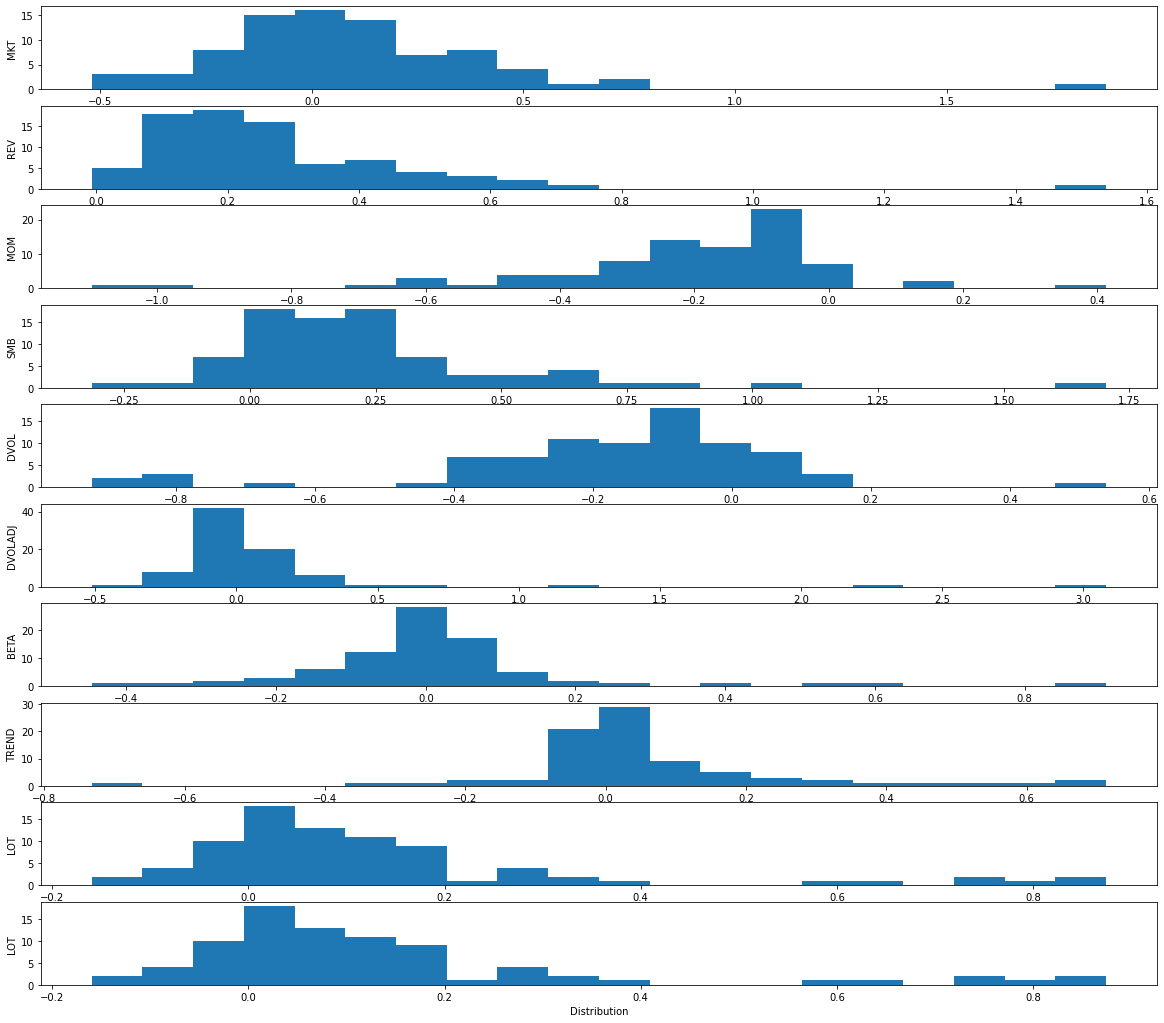

In [ ]:
fig = plt.figure(figsize=(20,18))
ax1 = fig.add_subplot(10, 1, 1)
ax2 = fig.add_subplot(10, 1, 2)
ax3 = fig.add_subplot(10, 1, 3)
ax4 = fig.add_subplot(10, 1, 4)
ax5 = fig.add_subplot(10, 1, 5)
ax6 = fig.add_subplot(10, 1, 6)
ax7 = fig.add_subplot(10, 1, 7)
ax8 = fig.add_subplot(10, 1, 8)
ax9 = fig.add_subplot(10, 1, 9)
ax10 = fig.add_subplot(10, 1, 10)

n, bins, patches = ax1.hist(hist_win_five['MktPrem'], bins=20)
ax1.set_xlabel('Distribution')
ax1.set_ylabel('MKT')

n, bins, patches = ax2.hist(hist_win_five['DMU'], bins=20)
ax2.set_xlabel('Distribution')
ax2.set_ylabel('REV')

n, bins, patches = ax3.hist(hist_win_five['MOM'],bins=20)
ax3.set_xlabel('Distribution')
ax3.set_ylabel('MOM')

n, bins, patches = ax4.hist(hist_win_five['SizeB'],bins=20)
ax4.set_xlabel('Distribution')
ax4.set_ylabel('SMB')

n, bins, patches = ax5.hist(hist_win_five['LogVol'],bins=20)
ax5.set_xlabel('Distribution')
ax5.set_ylabel('DVOL')

n, bins, patches = ax6.hist(hist_win_five['LogVolAdj'],bins=20)
ax6.set_xlabel('Distribution')
ax6.set_ylabel('DVOLADJ')

n, bins, patches = ax7.hist(hist_win_five['Beta'],bins=20)
ax7.set_xlabel('Distribution')
ax7.set_ylabel('BETA')

n, bins, patches = ax8.hist(hist_win_five['Trend'],bins=20)
ax8.set_xlabel('Distribution')
ax8.set_ylabel('TREND')

n, bins, patches = ax9.hist(hist_win_five['Lot'],bins=20)
ax9.set_xlabel('Distribution')
ax9.set_ylabel('LOT')

n, bins, patches = ax10.hist(hist_win_five['Lot'],bins=20)
ax10.set_xlabel('Distribution')
ax10.set_ylabel('LOT')

plt.savefig('/drive/My Drive/Colab Notebooks/Returns_winsorized_five.png', dpi=300)

In [ ]:
latexformatter(describex(F_Ret_win_five[['Return', 'MktPrem', 'DMU', 'MOM', 'SizeB', 'LogVol', 'LogVolAdj', 'Beta', 'Trend', 'Lot','Vola']].dropna()*100).T.round(3)).to_latex()

'\\begin{tabular}{lllllllllllll}\n\\toprule\n{} & count &      mean &     std &       min &        5\\% &       25\\% &       50\\% &      75\\% &      95\\% &     max &    Kurt &     Skew \\\\\n\\midrule\nReturn    &  82.0 &    18.794 &  43.465 &   (42.96) &  (24.239) &   (5.555) &       9.7 &   28.905 &  114.238 &  209.28 &   5.569 &    2.063 \\\\\nMktPrem   &  82.0 &     8.263 &  32.753 &   (51.99) &  (34.892) &    (9.57) &     1.445 &   22.825 &   51.923 &  187.64 &  10.154 &    2.164 \\\\\nDMU       &  82.0 &    26.989 &  21.468 &    (0.71) &     6.792 &    13.138 &     21.55 &   35.812 &    58.55 &  153.81 &  14.117 &    2.859 \\\\\nMOM       &  82.0 &   (21.11) &   21.91 &  (109.75) &  (62.868) &  (29.032) &  (17.315) &  (9.333) &    2.629 &   41.33 &   4.267 &  (1.306) \\\\\nSizeB     &  82.0 &    22.253 &  28.139 &   (31.47) &   (7.538) &     5.355 &    16.645 &    29.11 &   64.339 &  170.38 &   9.084 &    2.289 \\\\\nLogVol    &  82.0 &  (17.534) &  24.202 &   (92.06) &  (81.

In [ ]:
F_Ret_win_five.set_index('year_month', inplace=True)

In [ ]:
F_Ret_win_five

,Return,MktPrem,FFSMB,FFDMU,FFMOM,DMU,MOM,SizeB,LogVol,LogVolAdj,Beta,Trend,Lot,Vola
year_month,,,,,,,,,,,,,,
2015-10,0.0797,0.3710,0.1584,0.4524,-0.3025,0.3430,-0.0396,0.2015,-0.0616,0.0039,-0.0368,NaN,0.2720,0.2554
2015-11,0.0800,0.2310,-0.0604,0.2143,-0.1388,0.2316,-0.2525,-0.0755,-0.0507,-0.0222,0.0387,0.0633,-0.0612,-0.0245
2015-12,0.3123,0.1405,0.7211,-0.0693,-0.5057,0.5037,-0.3904,0.2930,0.0027,0.2788,0.1503,0.0017,0.2757,0.4311
2016-01,0.6462,-0.1752,1.4461,0.1577,-0.3153,0.4690,-0.4495,1.0221,-0.8501,0.7094,-0.4463,0.4564,0.8311,0.4954
2016-02,0.4609,0.1415,0.5926,0.0525,-0.1495,0.0781,-0.3403,0.5872,-0.1121,0.1193,-0.0918,0.1801,0.3800,0.4327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04,-0.2402,-0.1630,0.0990,-0.0649,0.0719,0.0292,-0.0741,0.1032,-0.1700,-0.0870,0.0898,-0.0306,0.0619,0.0823
2022-05,-0.2136,-0.0856,0.0851,-0.0598,-0.0094,-0.0071,-0.1121,0.0877,-0.0731,0.0547,0.1627,0.0111,0.0249,0.0233
2022-06,0.2535,-0.4281,0.0108,0.3469,-0.1808,0.4206,-0.3186,-0.0036,-0.0981,-0.0992,-0.3348,0.0309,0.1087,0.1826


In [ ]:
F_Ret_win_five

,Return,MktPrem,FFSMB,FFDMU,FFMOM,DMU,MOM,SizeB,LogVol,LogVolAdj,Beta,Trend,Lot,Vola
year_month,,,,,,,,,,,,,,
2015-10,0.0797,0.3710,0.1584,0.4524,-0.3025,0.3430,-0.0396,0.2015,-0.0616,0.0039,-0.0368,NaN,0.2720,0.2554
2015-11,0.0800,0.2310,-0.0604,0.2143,-0.1388,0.2316,-0.2525,-0.0755,-0.0507,-0.0222,0.0387,0.0633,-0.0612,-0.0245
2015-12,0.3123,0.1405,0.7211,-0.0693,-0.5057,0.5037,-0.3904,0.2930,0.0027,0.2788,0.1503,0.0017,0.2757,0.4311
2016-01,0.6462,-0.1752,1.4461,0.1577,-0.3153,0.4690,-0.4495,1.0221,-0.8501,0.7094,-0.4463,0.4564,0.8311,0.4954
2016-02,0.4609,0.1415,0.5926,0.0525,-0.1495,0.0781,-0.3403,0.5872,-0.1121,0.1193,-0.0918,0.1801,0.3800,0.4327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04,-0.2402,-0.1630,0.0990,-0.0649,0.0719,0.0292,-0.0741,0.1032,-0.1700,-0.0870,0.0898,-0.0306,0.0619,0.0823
2022-05,-0.2136,-0.0856,0.0851,-0.0598,-0.0094,-0.0071,-0.1121,0.0877,-0.0731,0.0547,0.1627,0.0111,0.0249,0.0233
2022-06,0.2535,-0.4281,0.0108,0.3469,-0.1808,0.4206,-0.3186,-0.0036,-0.0981,-0.0992,-0.3348,0.0309,0.1087,0.1826


In [ ]:
F_Ret_five = F_Ret_win_five[['Return', 'MktPrem', 'DMU', 'MOM', 'SizeB', 
                             'LogVol', 'LogVolAdj', 'Beta', 'Trend', 'Lot', 'Vola']]

In [ ]:
F_Ret_five['dummy'] = 0
F_Ret_five *= 100
stat = pd.DataFrame(columns=['mean', 't-value', 'bse', 'p-value'], index=F_Ret_five.columns)
i = 0
for column in F_Ret_five:
  stat.iloc[i]['bse'] = smp.ols(f'{column} ~ 1 + dummy',data=F_Ret_five).fit().get_robustcov_results(cov_type='HAC',maxlags=4).bse[0]
  stat.iloc[i]['t-value'] = smp.ols(f'{column} ~ 1 + dummy',data=F_Ret_five).fit().get_robustcov_results(cov_type='HAC',maxlags=4).tvalues[0]
  stat.iloc[i]['p-value'] = smp.ols(f'{column} ~ 1 + dummy',data=F_Ret_five).fit().get_robustcov_results(cov_type='HAC',maxlags=4).pvalues[0]
  stat.iloc[i]['mean'] = F_Ret_five[column].mean()
  i+=1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
stat = round(stat[:-1], 2)

In [ ]:
round(stat, 2).to_latex()

'\\begin{tabular}{lllll}\n\\toprule\n{} &       mean &    t-value &       bse &   p-value \\\\\n\\midrule\nReturn    &  18.663253 &   2.768544 &  6.741179 &   0.00696 \\\\\nMktPrem   &   8.610482 &   2.181607 &  3.946853 &  0.032001 \\\\\nDMU       &  27.076747 &  10.293979 &  2.630348 &       0.0 \\\\\nMOM       & -20.903012 &   -7.31627 &  2.857059 &       0.0 \\\\\nSizeB     &  22.227952 &   6.009239 &  3.698963 &       0.0 \\\\\nLogVol    & -17.396506 &  -5.702896 &  3.050469 &       0.0 \\\\\nLogVolAdj &    7.33012 &   1.494003 &  4.906362 &  0.139013 \\\\\nBeta      &   1.135301 &    0.41319 &  2.747646 &  0.680546 \\\\\nTrend     &   5.638171 &    2.29835 &  2.453138 &   0.02412 \\\\\nLot       &  13.467711 &   4.712889 &  2.857634 &   0.00001 \\\\\nVola      &  16.399639 &   5.830865 &  2.812557 &       0.0 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [ ]:
latexformatter(stat)

,mean,t-value,bse,p-value
Return,18.66325301204819,2.7685441993352113,6.741179359364986,0.0069599961738361004
MktPrem,8.610481927710845,2.181607074602688,3.946852771037597,0.03200145199251021
DMU,27.076746987951807,10.293978997207516,2.6303479922872404,1.9650195507862052e-16
MOM,(20.903012048192767),(7.3162696154390625),2.8570587398914964,1.5525350123108255e-10
SizeB,22.22795180722892,6.009238845693878,3.6989629432281768,4.9255354261219396e-08
LogVol,(17.396506024096386),(5.702896425773445),3.050468520781002,1.8056160725818557e-07
LogVolAdj,7.33012048192771,1.4940030577655514,4.906362436025216,0.1390130425569478
Beta,1.1353012048192779,0.4131904868416754,2.747646039717021,0.6805455762141615
Trend,5.638170731707317,2.298350304291725,2.4531381144028055,0.024119979826092236
Lot,13.467710843373494,4.712889271983047,2.857633622634776,9.859569091148568e-06


## One factor test

In [ ]:
F_Ret_five /= 100

In [ ]:
#Set up regression
Y = F_Ret_five[['DMU',
           #'MOM',
           #'SizeB',
           #'SizeMS',
           #'LogVol',
           #'LogVolAdj',
           #'Beta',
           #'Trend',
           #'Lot',
           #'Vola'
            ]].values 
X = F_Ret_five[['MktPrem']]
X = sm.add_constant(X)
X.rename(columns = {"const":"Intercept"}, inplace = True)

model = sm.OLS(Y.astype(float), X.astype(float), missing='drop')

result = model.fit(cov_type='HAC',cov_kwds={'maxlags':4})
q = pd.concat([result.params.to_frame(), 
                 result.tvalues.to_frame(), 
                 result.pvalues.to_frame(), 
                 result.bse.to_frame(), 
                 #result.rsquared, 
                 #result.rsquared_adj
                 ]
                 ,axis=1).round(3)
q.columns = ['Coef','t','p','se']
print(q, result.rsquared.round(3), result.rsquared_adj.round(3))

            Coef       t      p     se
Intercept  0.262  11.114  0.000  0.024
MktPrem    0.100   0.877  0.381  0.114 0.023 0.011


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
#Set up regression
Y = F_Ret_five[[#'DMU',
           'MOM',
           #'SizeB',
           #'SizeMS',
           #'LogVol',
           #'LogVolAdj',
           #'Beta',
           #'Trend',
           #'Lot',
           #'Vola'
            ]].values 
X = F_Ret_five[['MktPrem']]
X = sm.add_constant(X)
X.rename(columns = {"const":"Intercept"}, inplace = True)

model = sm.OLS(Y.astype(float), X.astype(float), missing='drop')

result = model.fit(cov_type='HAC',cov_kwds={'maxlags':4})
q = pd.concat([result.params.to_frame(), 
                 result.tvalues.to_frame(), 
                 result.pvalues.to_frame(), 
                 result.bse.to_frame(), 
                 #result.rsquared, 
                 #result.rsquared_adj
                 ]
                 ,axis=1).round(3)
q.columns = ['Coef','t','p','se']
print(q, result.rsquared.round(3), result.rsquared_adj.round(3))

            Coef      t     p     se
Intercept -0.211 -6.856  0.00  0.031
MktPrem    0.026  0.266  0.79  0.096 0.001 -0.011


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
#Set up regression
Y = F_Ret_five[[#'DMU',
           #'MOM',
           'SizeB',
           #'SizeMS',
           #'LogVol',
           #'LogVolAdj',
           #'Beta',
           #'Trend',
           #'Lot',
           #'Vola'
            ]].values 
X = F_Ret_five[['MktPrem']]
X = sm.add_constant(X)
X.rename(columns = {"const":"Intercept"}, inplace = True)

model = sm.OLS(Y.astype(float), X.astype(float), missing='drop')

result = model.fit(cov_type='HAC',cov_kwds={'maxlags':4})
q = pd.concat([result.params.to_frame(), 
                 result.tvalues.to_frame(), 
                 result.pvalues.to_frame(), 
                 result.bse.to_frame(), 
                 #result.rsquared, 
                 #result.rsquared_adj
                 ]
                 ,axis=1).round(3)
q.columns = ['Coef','t','p','se']
print(q, result.rsquared.round(3), result.rsquared_adj.round(3))

            Coef      t      p     se
Intercept  0.228  5.207  0.000  0.044
MktPrem   -0.062 -0.715  0.475  0.086 0.005 -0.007


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
#Set up regression
Y = F_Ret_five[[#'DMU',
           #'MOM',
           #'SizeB',
           #'SizeMS',
           'LogVol',
           #'LogVolAdj',
           #'Beta',
           #'Trend',
           #'Lot',
           #'Vola'
            ]].values 
X = F_Ret_five[['MktPrem']]
X = sm.add_constant(X)
X.rename(columns = {"const":"Intercept"}, inplace = True)

model = sm.OLS(Y.astype(float), X.astype(float), missing='drop')

result = model.fit(cov_type='HAC',cov_kwds={'maxlags':4})
q = pd.concat([result.params.to_frame(), 
                 result.tvalues.to_frame(), 
                 result.pvalues.to_frame(), 
                 result.bse.to_frame(), 
                 #result.rsquared, 
                 #result.rsquared_adj
                 ]
                 ,axis=1).round(3)
q.columns = ['Coef','t','p','se']
print(q, result.rsquared.round(3), result.rsquared_adj.round(3))

            Coef      t      p     se
Intercept -0.179 -5.200  0.000  0.034
MktPrem    0.055  0.741  0.459  0.074 0.006 -0.007


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
#Set up regression
Y = F_Ret_five[[#'DMU',
           #'MOM',
           #'SizeB',
           #'SizeMS',
           #'LogVol',
           'LogVolAdj',
           #'Beta',
           #'Trend',
           #'Lot',
           #'Vola'
            ]].values 
X = F_Ret_five[['MktPrem']]
X = sm.add_constant(X)
X.rename(columns = {"const":"Intercept"}, inplace = True)

model = sm.OLS(Y.astype(float), X.astype(float), missing='drop')

result = model.fit(cov_type='HAC',cov_kwds={'maxlags':4})
q = pd.concat([result.params.to_frame(), 
                 result.tvalues.to_frame(), 
                 result.pvalues.to_frame(), 
                 result.bse.to_frame(), 
                 #result.rsquared, 
                 #result.rsquared_adj
                 ]
                 ,axis=1).round(3)
q.columns = ['Coef','t','p','se']
print(q, result.rsquared.round(3), result.rsquared_adj.round(3))

            Coef      t      p     se
Intercept  0.051  1.300  0.194  0.040
MktPrem    0.254  1.599  0.110  0.159 0.032 0.02


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
#Set up regression
Y = F_Ret_five[[#'DMU',
           #'MOM',
           #'SizeB',
           #'SizeMS',
           #'LogVol',
           #'LogVolAdj',
           'Beta',
           #'Trend',
           #'Lot',
           #'Vola'
            ]].values 
X = F_Ret_five[['MktPrem']]
X = sm.add_constant(X)
X.rename(columns = {"const":"Intercept"}, inplace = True)

model = sm.OLS(Y.astype(float), X.astype(float), missing='drop')

result = model.fit(cov_type='HAC',cov_kwds={'maxlags':4})
q = pd.concat([result.params.to_frame(), 
                 result.tvalues.to_frame(), 
                 result.pvalues.to_frame(), 
                 result.bse.to_frame(), 
                 #result.rsquared, 
                 #result.rsquared_adj
                 ]
                 ,axis=1).round(3)
q.columns = ['Coef','t','p','se']
print(q, result.rsquared.round(3), result.rsquared_adj.round(3))

            Coef      t      p     se
Intercept  0.012  0.396  0.692  0.030
MktPrem   -0.008 -0.168  0.867  0.046 0.0 -0.012


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
#Set up regression
Y = F_Ret_five[[#'DMU',
           #'MOM',
           #'SizeB',
           #'SizeMS',
           #'LogVol',
           #'LogVolAdj',
           #'Beta',
           'Trend',
           #'Lot',
           #'Vola'
            ]].values 
X = F_Ret_five[['MktPrem']]
X = sm.add_constant(X)
X.rename(columns = {"const":"Intercept"}, inplace = True)

model = sm.OLS(Y.astype(float), X.astype(float), missing='drop')

result = model.fit(cov_type='HAC',cov_kwds={'maxlags':4})
q = pd.concat([result.params.to_frame(), 
                 result.tvalues.to_frame(), 
                 result.pvalues.to_frame(), 
                 result.bse.to_frame(), 
                 #result.rsquared, 
                 #result.rsquared_adj
                 ]
                 ,axis=1).round(3)
q.columns = ['Coef','t','p','se']
print(q, result.rsquared.round(3), result.rsquared_adj.round(3))

            Coef      t      p     se
Intercept  0.057  2.156  0.031  0.026
MktPrem   -0.002 -0.023  0.982  0.081 0.0 -0.012


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
#Set up regression
Y = F_Ret_five[[#'DMU',
           #'MOM',
           #'SizeB',
           #'SizeMS',
           #'LogVol',
           #'LogVolAdj',
           #'Beta',
           #'Trend',
           'Lot',
           #'Vola'
            ]].values 
X = F_Ret_five[['MktPrem']]
X = sm.add_constant(X)
X.rename(columns = {"const":"Intercept"}, inplace = True)

model = sm.OLS(Y.astype(float), X.astype(float), missing='drop')

result = model.fit(cov_type='HAC',cov_kwds={'maxlags':4})
q = pd.concat([result.params.to_frame(), 
                 result.tvalues.to_frame(), 
                 result.pvalues.to_frame(), 
                 result.bse.to_frame(), 
                 #result.rsquared, 
                 #result.rsquared_adj
                 ]
                 ,axis=1).round(3)
q.columns = ['Coef','t','p','se']
print(q, result.rsquared.round(3), result.rsquared_adj.round(3))

            Coef      t      p     se
Intercept  0.119  4.846  0.000  0.025
MktPrem    0.179  2.249  0.025  0.080 0.072 0.061


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
#Set up regression
Y = F_Ret_five[[#'DMU',
           #'MOM',
           #'SizeB',
           #'SizeMS',
           #'LogVol',
           #'LogVolAdj',
           #'Beta',
           #'Trend',
           #'Lot',
           'Vola'
            ]].values 
X = F_Ret_five[['MktPrem']]
X = sm.add_constant(X)
X.rename(columns = {"const":"Intercept"}, inplace = True)

model = sm.OLS(Y.astype(float), X.astype(float), missing='drop')

result = model.fit(cov_type='HAC',cov_kwds={'maxlags':4})
q = pd.concat([result.params.to_frame(), 
                 result.tvalues.to_frame(), 
                 result.pvalues.to_frame(), 
                 result.bse.to_frame(), 
                 #result.rsquared, 
                 #result.rsquared_adj
                 ]
                 ,axis=1).round(3)
q.columns = ['Coef','t','p','se']
print(q, result.rsquared.round(3), result.rsquared_adj.round(3))

            Coef      t      p     se
Intercept  0.149  6.038  0.000  0.025
MktPrem    0.178  2.641  0.008  0.067 0.08 0.069


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


## Two factor test

In [ ]:
F_Ret_five = F_Ret_win_five[['Return', 'MktPrem', 'FFSMB', 'FFDMU', 'DMU', 'MOM', 'SizeB', 
                             'LogVol', 'LogVolAdj', 'Beta', 'Trend', 'Lot', 'Vola']]

In [ ]:
#Set up regression
Y = F_Ret_five[[
           'DMU',
           #'MOM',
           #'SizeB',
           #'SizeMS',
           #'LogVol',
           #'LogVolAdj',
           #'Beta',
           #'Trend',
           #'Lot',
           #'Vola'
           ]].values 
X = F_Ret_five[['MktPrem',
             'FFSMB', 
             #'FFDMU',
             #'FFMOM',
           ]]
X = sm.add_constant(X)
X.rename(columns = {"const":"Intercept"}, inplace = True)


model = sm.OLS(Y.astype(float), X.astype(float), missing='drop')

result = model.fit(cov_type='HAC',cov_kwds={'maxlags':4})
q = pd.concat([result.params.to_frame(), 
                 result.tvalues.to_frame(), 
                 result.pvalues.to_frame(), 
                 result.bse.to_frame(), 
                 #result.rsquared, 
                 #result.rsquared_adj
                 ]
                 ,axis=1).round(3)
q.columns = ['Coef','t','p','se']
print(q, result.rsquared.round(3), result.rsquared_adj.round(3))

            Coef      t      p     se
Intercept  0.226  8.935  0.000  0.025
MktPrem    0.104  0.944  0.345  0.110
FFSMB      0.131  3.005  0.003  0.043 0.092 0.069


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
#Set up regression
Y = F_Ret_five[[
           #'DMU',
           'MOM',
           #'SizeB',
           #'SizeMS',
           #'LogVol',
           #'LogVolAdj',
           #'Beta',
           #'Trend',
           #'Lot',
           #'Vola'
           ]].values 
X = F_Ret_five[['MktPrem',
             'FFSMB', 
             #'FFDMU',
             #'FFMOM',
           ]]
X = sm.add_constant(X)
X.rename(columns = {"const":"Intercept"}, inplace = True)


model = sm.OLS(Y.astype(float), X.astype(float), missing='drop')

result = model.fit(cov_type='HAC',cov_kwds={'maxlags':4})
q = pd.concat([result.params.to_frame(), 
                 result.tvalues.to_frame(), 
                 result.pvalues.to_frame(), 
                 result.bse.to_frame(), 
                 #result.rsquared, 
                 #result.rsquared_adj
                 ]
                 ,axis=1).round(3)
q.columns = ['Coef','t','p','se']
print(q, result.rsquared.round(3), result.rsquared_adj.round(3))

            Coef       t      p     se
Intercept -0.130  -6.295  0.000  0.021
MktPrem    0.016   0.190  0.849  0.085
FFSMB     -0.293 -10.597  0.000  0.028 0.331 0.314


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
#Set up regression
Y = F_Ret_five[[
           #'DMU',
           #'MOM',
           #'SizeB',
           #'SizeMS',
           'LogVol',
           #'LogVolAdj',
           #'Beta',
           #'Trend',
           #'Lot',
           #'Vola'
           ]].values 
X = F_Ret_five[['MktPrem',
             'FFSMB', 
             #'FFDMU',
             #'FFMOM',
           ]]
X = sm.add_constant(X)
X.rename(columns = {"const":"Intercept"}, inplace = True)


model = sm.OLS(Y.astype(float), X.astype(float), missing='drop')

result = model.fit(cov_type='HAC',cov_kwds={'maxlags':4})
q = pd.concat([result.params.to_frame(), 
                 result.tvalues.to_frame(), 
                 result.pvalues.to_frame(), 
                 result.bse.to_frame(), 
                 #result.rsquared, 
                 #result.rsquared_adj
                 ]
                 ,axis=1).round(3)
q.columns = ['Coef','t','p','se']
print(q, result.rsquared.round(3), result.rsquared_adj.round(3))

            Coef      t      p     se
Intercept -0.082 -2.757  0.006  0.030
MktPrem    0.044  0.865  0.387  0.051
FFSMB     -0.345 -4.720  0.000  0.073 0.382 0.367


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
#Set up regression
Y = F_Ret_five[[
           #'DMU',
           #'MOM',
           #'SizeB',
           #'SizeMS',
           #'LogVol',
           'LogVolAdj',
           #'Beta',
           #'Trend',
           #'Lot',
           #'Vola'
           ]].values 
X = F_Ret_five[['MktPrem',
             'FFSMB', 
             #'FFDMU',
             #'FFMOM',
           ]]
X = sm.add_constant(X)
X.rename(columns = {"const":"Intercept"}, inplace = True)


model = sm.OLS(Y.astype(float), X.astype(float), missing='drop')

result = model.fit(cov_type='HAC',cov_kwds={'maxlags':4})
q = pd.concat([result.params.to_frame(), 
                 result.tvalues.to_frame(), 
                 result.pvalues.to_frame(), 
                 result.bse.to_frame(), 
                 #result.rsquared, 
                 #result.rsquared_adj
                 ]
                 ,axis=1).round(3)
q.columns = ['Coef','t','p','se']
print(q, result.rsquared.round(3), result.rsquared_adj.round(3))

            Coef      t      p     se
Intercept  0.048  0.843  0.399  0.057
MktPrem    0.254  1.623  0.105  0.157
FFSMB      0.012  0.099  0.921  0.124 0.032 0.008


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
#Set up regression
Y = F_Ret_five[[
           #'DMU',
           #'MOM',
           #'SizeB',
           #'SizeMS',
           #'LogVol',
           #'LogVolAdj',
           'Beta',
           #'Trend',
           #'Lot',
           #'Vola'
           ]].values 
X = F_Ret_five[['MktPrem',
             'FFSMB', 
             #'FFDMU',
             #'FFMOM',
           ]]
X = sm.add_constant(X)
X.rename(columns = {"const":"Intercept"}, inplace = True)


model = sm.OLS(Y.astype(float), X.astype(float), missing='drop')

result = model.fit(cov_type='HAC',cov_kwds={'maxlags':4})
q = pd.concat([result.params.to_frame(), 
                 result.tvalues.to_frame(), 
                 result.pvalues.to_frame(), 
                 result.bse.to_frame(), 
                 #result.rsquared, 
                 #result.rsquared_adj
                 ]
                 ,axis=1).round(3)
q.columns = ['Coef','t','p','se']
print(q, result.rsquared.round(3), result.rsquared_adj.round(3))

            Coef      t      p     se
Intercept -0.032 -2.112  0.035  0.015
MktPrem   -0.003 -0.076  0.939  0.035
FFSMB      0.159  1.536  0.125  0.103 0.141 0.12


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
#Set up regression
Y = F_Ret_five[[
           #'DMU',
           #'MOM',
           #'SizeB',
           #'SizeMS',
           #'LogVol',
           #'LogVolAdj',
           #'Beta',
           'Trend',
           #'Lot',
           #'Vola'
           ]].values 
X = F_Ret_five[['MktPrem',
             'FFSMB', 
             #'FFDMU',
             #'FFMOM',
           ]]
X = sm.add_constant(X)
X.rename(columns = {"const":"Intercept"}, inplace = True)


model = sm.OLS(Y.astype(float), X.astype(float), missing='drop')

result = model.fit(cov_type='HAC',cov_kwds={'maxlags':4})
q = pd.concat([result.params.to_frame(), 
                 result.tvalues.to_frame(), 
                 result.pvalues.to_frame(), 
                 result.bse.to_frame(), 
                 #result.rsquared, 
                 #result.rsquared_adj
                 ]
                 ,axis=1).round(3)
q.columns = ['Coef','t','p','se']
print(q, result.rsquared.round(3), result.rsquared_adj.round(3))

            Coef      t      p     se
Intercept  0.045  1.829  0.067  0.025
MktPrem   -0.001 -0.009  0.993  0.080
FFSMB      0.040  0.932  0.352  0.043 0.007 -0.018


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
#Set up regression
Y = F_Ret_five[[
           #'DMU',
           #'MOM',
           #'SizeB',
           #'SizeMS',
           #'LogVol',
           #'LogVolAdj',
           #'Beta',
           #'Trend',
           'Lot',
           #'Vola'
           ]].values 
X = F_Ret_five[['MktPrem',
             'FFSMB', 
             #'FFDMU',
             #'FFMOM',
           ]]
X = sm.add_constant(X)
X.rename(columns = {"const":"Intercept"}, inplace = True)


model = sm.OLS(Y.astype(float), X.astype(float), missing='drop')

result = model.fit(cov_type='HAC',cov_kwds={'maxlags':4})
q = pd.concat([result.params.to_frame(), 
                 result.tvalues.to_frame(), 
                 result.pvalues.to_frame(), 
                 result.bse.to_frame(), 
                 #result.rsquared, 
                 #result.rsquared_adj
                 ]
                 ,axis=1).round(3)
q.columns = ['Coef','t','p','se']
print(q, result.rsquared.round(3), result.rsquared_adj.round(3))

            Coef      t      p     se
Intercept  0.067  2.391  0.017  0.028
MktPrem    0.185  2.301  0.021  0.080
FFSMB      0.188  1.970  0.049  0.096 0.209 0.189


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
#Set up regression
Y = F_Ret_five[[
           #'DMU',
           #'MOM',
           #'SizeB',
           #'SizeMS',
           #'LogVol',
           #'LogVolAdj',
           #'Beta',
           #'Trend',
           #'Lot',
           'Vola'
           ]].values 
X = F_Ret_five[['MktPrem',
             'FFSMB', 
             #'FFDMU',
             #'FFMOM',
           ]]
X = sm.add_constant(X)
X.rename(columns = {"const":"Intercept"}, inplace = True)


model = sm.OLS(Y.astype(float), X.astype(float), missing='drop')

result = model.fit(cov_type='HAC',cov_kwds={'maxlags':4})
q = pd.concat([result.params.to_frame(), 
                 result.tvalues.to_frame(), 
                 result.pvalues.to_frame(), 
                 result.bse.to_frame(), 
                 #result.rsquared, 
                 #result.rsquared_adj
                 ]
                 ,axis=1).round(3)
q.columns = ['Coef','t','p','se']
print(q, result.rsquared.round(3), result.rsquared_adj.round(3))

            Coef      t      p     se
Intercept  0.087  3.847  0.000  0.023
MktPrem    0.185  2.743  0.006  0.068
FFSMB      0.221  3.817  0.000  0.058 0.291 0.273


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


## Three factor test

In [ ]:
#Set up regression
Y = F_Ret_five[[
           #'DMU',
           'MOM',
           #'SizeB',
           #'SizeMS',
           #'LogVol',
           #'LogVolAdj',
           #'Beta',
           #'Trend',
           #'Lot',
           #'Vola'
           ]].values 
X = F_Ret_five[['MktPrem',
             'FFSMB', 
             'FFDMU',
           ]]
X = sm.add_constant(X)
X.rename(columns = {"const":"Intercept"}, inplace = True)


model = sm.OLS(Y.astype(float), X.astype(float), missing='drop')

result = model.fit(cov_type='HAC',cov_kwds={'maxlags':4})
q = pd.concat([result.params.to_frame(), 
                 result.tvalues.to_frame(), 
                 result.pvalues.to_frame(), 
                 result.bse.to_frame(), 
                 #result.rsquared, 
                 #result.rsquared_adj
                 ]
                 ,axis=1).round(3)
q.columns = ['Coef','t','p','se']
print(q, result.rsquared.round(3), result.rsquared_adj.round(3))

            Coef      t      p     se
Intercept -0.103 -3.866  0.000  0.027
MktPrem    0.056  0.751  0.453  0.075
FFSMB     -0.333 -6.321  0.000  0.053
FFDMU     -0.114 -0.955  0.340  0.120 0.35 0.325


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
#Set up regression
Y = F_Ret_five[[
           #'DMU',
           #'MOM',
           #'SizeB',
           #'SizeMS',
           'LogVol',
           #'LogVolAdj',
           #'Beta',
           #'Trend',
           #'Lot',
           #'Vola'
           ]].values 
X = F_Ret_five[['MktPrem',
             'FFSMB', 
             'FFDMU',
           ]]
X = sm.add_constant(X)
X.rename(columns = {"const":"Intercept"}, inplace = True)


model = sm.OLS(Y.astype(float), X.astype(float), missing='drop')

result = model.fit(cov_type='HAC',cov_kwds={'maxlags':4})
q = pd.concat([result.params.to_frame(), 
                 result.tvalues.to_frame(), 
                 result.pvalues.to_frame(), 
                 result.bse.to_frame(), 
                 #result.rsquared, 
                 #result.rsquared_adj
                 ]
                 ,axis=1).round(3)
q.columns = ['Coef','t','p','se']
print(q, result.rsquared.round(3), result.rsquared_adj.round(3))

            Coef      t      p     se
Intercept -0.030 -1.075  0.282  0.028
MktPrem    0.123  2.057  0.040  0.060
FFSMB     -0.425 -7.487  0.000  0.057
FFDMU     -0.227 -3.586  0.000  0.063 0.443 0.422


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
#Set up regression
Y = F_Ret_five[[
           #'DMU',
           #'MOM',
           #'SizeB',
           #'SizeMS',
           #'LogVol',
           'LogVolAdj',
           #'Beta',
           #'Trend',
           #'Lot',
           #'Vola'
           ]].values 
X = F_Ret_five[['MktPrem',
             'FFSMB', 
             'FFDMU',
           ]]
X = sm.add_constant(X)
X.rename(columns = {"const":"Intercept"}, inplace = True)


model = sm.OLS(Y.astype(float), X.astype(float), missing='drop')

result = model.fit(cov_type='HAC',cov_kwds={'maxlags':4})
q = pd.concat([result.params.to_frame(), 
                 result.tvalues.to_frame(), 
                 result.pvalues.to_frame(), 
                 result.bse.to_frame(), 
                 #result.rsquared, 
                 #result.rsquared_adj
                 ]
                 ,axis=1).round(3)
q.columns = ['Coef','t','p','se']
print(q, result.rsquared.round(3), result.rsquared_adj.round(3))

            Coef      t      p     se
Intercept -0.068 -0.801  0.423  0.085
MktPrem    0.080  0.718  0.473  0.112
FFSMB      0.187  1.369  0.171  0.137
FFDMU      0.497  1.014  0.311  0.491 0.112 0.078


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
#Set up regression
Y = F_Ret_five[[
           #'DMU',
           #'MOM',
           #'SizeB',
           #'SizeMS',
           #'LogVol',
           #'LogVolAdj',
           'Beta',
           #'Trend',
           #'Lot',
           #'Vola'
           ]].values 
X = F_Ret_five[['MktPrem',
             'FFSMB', 
             'FFDMU',
           ]]
X = sm.add_constant(X)
X.rename(columns = {"const":"Intercept"}, inplace = True)


model = sm.OLS(Y.astype(float), X.astype(float), missing='drop')

result = model.fit(cov_type='HAC',cov_kwds={'maxlags':4})
q = pd.concat([result.params.to_frame(), 
                 result.tvalues.to_frame(), 
                 result.pvalues.to_frame(), 
                 result.bse.to_frame(), 
                 #result.rsquared, 
                 #result.rsquared_adj
                 ]
                 ,axis=1).round(3)
q.columns = ['Coef','t','p','se']
print(q, result.rsquared.round(3), result.rsquared_adj.round(3))

            Coef      t      p     se
Intercept  0.018  0.885  0.376  0.020
MktPrem    0.073  1.383  0.167  0.053
FFSMB      0.083  0.909  0.363  0.091
FFDMU     -0.216 -2.772  0.006  0.078 0.24 0.211


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
#Set up regression
Y = F_Ret_five[[
           #'DMU',
           #'MOM',
           #'SizeB',
           #'SizeMS',
           #'LogVol',
           #'LogVolAdj',
           #'Beta',
           'Trend',
           #'Lot',
           #'Vola'
           ]].values 
X = F_Ret_five[['MktPrem',
             'FFSMB', 
             'FFDMU',
           ]]
X = sm.add_constant(X)
X.rename(columns = {"const":"Intercept"}, inplace = True)


model = sm.OLS(Y.astype(float), X.astype(float), missing='drop')

result = model.fit(cov_type='HAC',cov_kwds={'maxlags':4})
q = pd.concat([result.params.to_frame(), 
                 result.tvalues.to_frame(), 
                 result.pvalues.to_frame(), 
                 result.bse.to_frame(), 
                 #result.rsquared, 
                 #result.rsquared_adj
                 ]
                 ,axis=1).round(3)
q.columns = ['Coef','t','p','se']
print(q, result.rsquared.round(3), result.rsquared_adj.round(3))

            Coef      t      p     se
Intercept -0.007 -0.318  0.751  0.023
MktPrem   -0.080 -1.338  0.181  0.060
FFSMB      0.120  2.301  0.021  0.052
FFDMU      0.229  2.668  0.008  0.086 0.098 0.064


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
#Set up regression
Y = F_Ret_five[[
           #'DMU',
           #'MOM',
           #'SizeB',
           #'SizeMS',
           #'LogVol',
           #'LogVolAdj',
           #'Beta',
           #'Trend',
           'Lot',
           #'Vola'
           ]].values 
X = F_Ret_five[['MktPrem',
             'FFSMB', 
             'FFDMU',
           ]]
X = sm.add_constant(X)
X.rename(columns = {"const":"Intercept"}, inplace = True)


model = sm.OLS(Y.astype(float), X.astype(float), missing='drop')

result = model.fit(cov_type='HAC',cov_kwds={'maxlags':4})
q = pd.concat([result.params.to_frame(), 
                 result.tvalues.to_frame(), 
                 result.pvalues.to_frame(), 
                 result.bse.to_frame(), 
                 #result.rsquared, 
                 #result.rsquared_adj
                 ]
                 ,axis=1).round(3)
q.columns = ['Coef','t','p','se']
print(q, result.rsquared.round(3), result.rsquared_adj.round(3))

            Coef      t      p     se
Intercept -0.021 -0.802  0.423  0.026
MktPrem    0.053  0.935  0.350  0.056
FFSMB      0.321  4.461  0.000  0.072
FFDMU      0.378  3.074  0.002  0.123 0.416 0.394


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
#Set up regression
Y = F_Ret_five[[
           #'DMU',
           #'MOM',
           #'SizeB',
           #'SizeMS',
           #'LogVol',
           #'LogVolAdj',
           #'Beta',
           #'Trend',
           #'Lot',
           'Vola'
           ]].values 
X = F_Ret_five[['MktPrem',
             'FFSMB', 
             'FFDMU',
           ]]
X = sm.add_constant(X)
X.rename(columns = {"const":"Intercept"}, inplace = True)


model = sm.OLS(Y.astype(float), X.astype(float), missing='drop')

result = model.fit(cov_type='HAC',cov_kwds={'maxlags':4})
q = pd.concat([result.params.to_frame(), 
                 result.tvalues.to_frame(), 
                 result.pvalues.to_frame(), 
                 result.bse.to_frame(), 
                 #result.rsquared, 
                 #result.rsquared_adj
                 ]
                 ,axis=1).round(3)
q.columns = ['Coef','t','p','se']
print(q, result.rsquared.round(3), result.rsquared_adj.round(3))

            Coef      t      p     se
Intercept  0.015  0.669  0.504  0.023
MktPrem    0.077  1.713  0.087  0.045
FFSMB      0.329  7.145  0.000  0.046
FFDMU      0.309  2.907  0.004  0.106 0.447 0.426


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


# Robustness Check with 7 portfolios

In [ ]:
dates = list(win['year_month'].unique())

F_Ret_win_seven = pd.DataFrame(columns =
                  ['year_month',
                   'Return',
                   'MktPrem',
                   'FFSMB',
                   'FFDMU',
                   'FFMOM',
                   #'FFVOL',
                   #'MOMcu',
                   'DMU',
                   'MOM',
                   'SizeB',
                   #'SizeMS',
                   'LogVol',
                   'LogVolAdj',
                   'Beta',
                   'Trend',
                   'Lot',
                   'Vola'
                  ])
F_Ret_win_sevenIndex = 0 
for i in dates:
    F_Ret_win_seven.loc[F_Ret_win_sevenIndex] = [i, 
                    calcReturn(win.loc[win['year_month'] == i]),  
                    calcMktPrem(win.loc[win['year_month'] == i]), 
                    calcFFSMB(win.loc[win['year_month'] == i]), 
                    calcFFDMU(win.loc[win['year_month'] == i]),
                    calcFFMOM(win.loc[win['year_month'] == i]),
                    #calcFFVOL(win.loc[win['year_month'] == i]), 
                    #calcMOMcu(win.loc[win['year_month'] == i]), 
                    calcShortRev_seven(win.loc[win['year_month'] == i]), 
                    calcMOM_seven(win.loc[win['year_month'] == i]), 
                    calcSizeB_seven(win.loc[win['year_month'] == i]),
                    #calcSizeMS(win.loc[win['year_month'] == i]), 
                    calcLogVol_seven(win.loc[win['year_month'] == i]), 
                    calcLogVolAdj_seven(win.loc[win['year_month'] == i]), 
                    calcBeta_seven(win.loc[win['year_month'] == i]), 
                    calcTrend_seven(win.loc[win['year_month'] == i]),
                    calcLot_seven(win.loc[win['year_month']==i]),
                    calcVola_seven(win.loc[win['year_month']==i])
                   ]
    F_Ret_win_sevenIndex += 1
F_Ret_win_seven['year_month'] = F_Ret_win_seven['year_month']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

In [ ]:
hist_win_seven = F_Ret_win_seven[['MktPrem', 'DMU', 'MOM', 'SizeB', 'LogVol', 'LogVolAdj', 'Beta', 'Trend', 'Lot', 'Vola']].dropna()

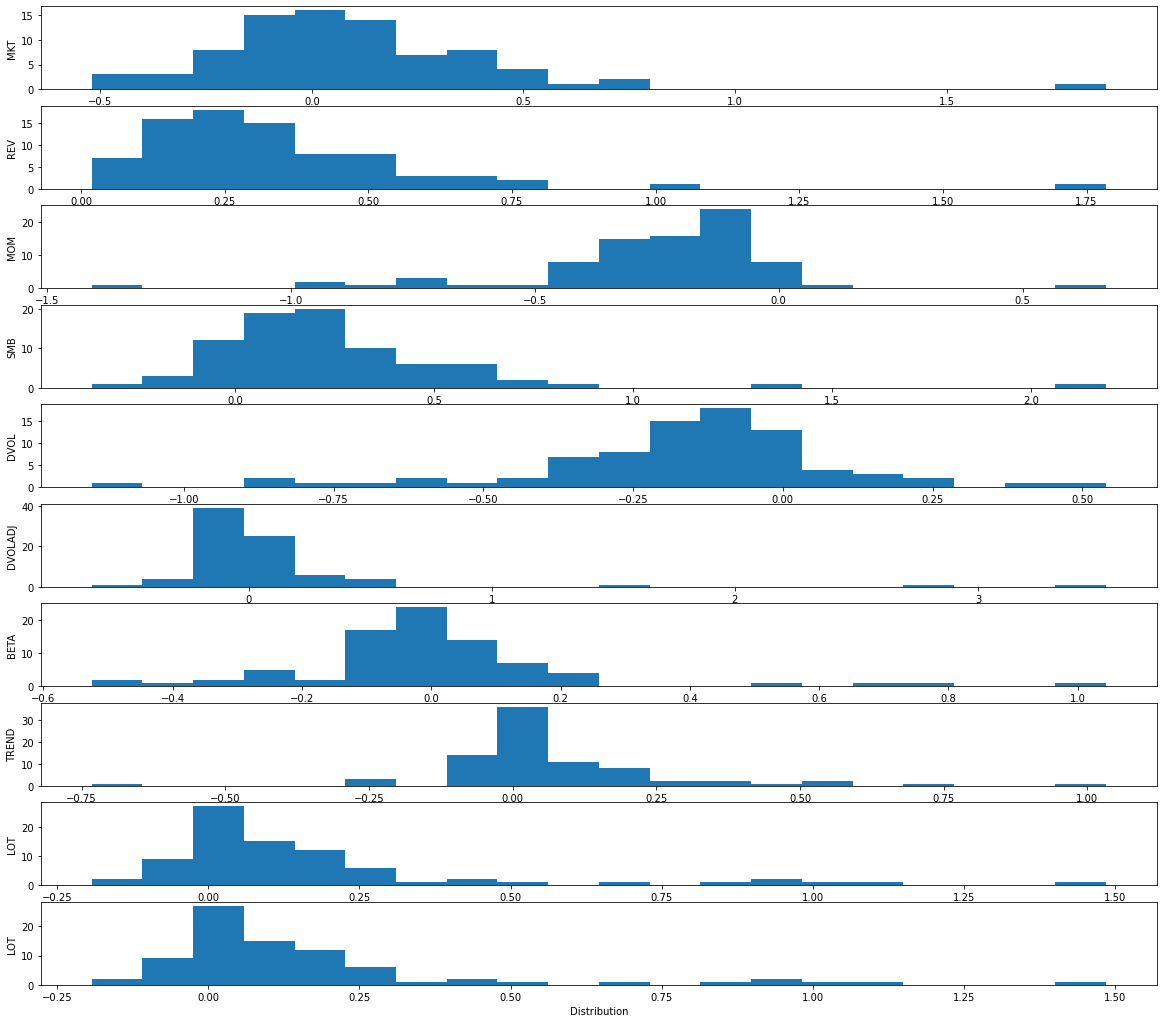

In [ ]:
fig = plt.figure(figsize=(20,18))
ax1 = fig.add_subplot(10, 1, 1)
ax2 = fig.add_subplot(10, 1, 2)
ax3 = fig.add_subplot(10, 1, 3)
ax4 = fig.add_subplot(10, 1, 4)
ax5 = fig.add_subplot(10, 1, 5)
ax6 = fig.add_subplot(10, 1, 6)
ax7 = fig.add_subplot(10, 1, 7)
ax8 = fig.add_subplot(10, 1, 8)
ax9 = fig.add_subplot(10, 1, 9)
ax10 = fig.add_subplot(10, 1, 10)

n, bins, patches = ax1.hist(hist_win_seven['MktPrem'], bins=20)
ax1.set_xlabel('Distribution')
ax1.set_ylabel('MKT')

n, bins, patches = ax2.hist(hist_win_seven['DMU'], bins=20)
ax2.set_xlabel('Distribution')
ax2.set_ylabel('REV')

n, bins, patches = ax3.hist(hist_win_seven['MOM'],bins=20)
ax3.set_xlabel('Distribution')
ax3.set_ylabel('MOM')

n, bins, patches = ax4.hist(hist_win_seven['SizeB'],bins=20)
ax4.set_xlabel('Distribution')
ax4.set_ylabel('SMB')

n, bins, patches = ax5.hist(hist_win_seven['LogVol'],bins=20)
ax5.set_xlabel('Distribution')
ax5.set_ylabel('DVOL')

n, bins, patches = ax6.hist(hist_win_seven['LogVolAdj'],bins=20)
ax6.set_xlabel('Distribution')
ax6.set_ylabel('DVOLADJ')

n, bins, patches = ax7.hist(hist_win_seven['Beta'],bins=20)
ax7.set_xlabel('Distribution')
ax7.set_ylabel('BETA')

n, bins, patches = ax8.hist(hist_win_seven['Trend'],bins=20)
ax8.set_xlabel('Distribution')
ax8.set_ylabel('TREND')

n, bins, patches = ax9.hist(hist_win_seven['Lot'],bins=20)
ax9.set_xlabel('Distribution')
ax9.set_ylabel('LOT')

n, bins, patches = ax10.hist(hist_win_seven['Lot'],bins=20)
ax10.set_xlabel('Distribution')
ax10.set_ylabel('LOT')

plt.savefig('/drive/My Drive/Colab Notebooks/Returns_winsorized_seven.png', dpi=300)

In [ ]:
latexformatter(describex(F_Ret_win_seven[['Return', 'MktPrem', 'DMU', 'MOM', 'SizeB', 'LogVol', 'LogVolAdj', 'Beta', 'Trend', 'Lot','Vola']].dropna()*100).T.round(3)).to_latex()

'\\begin{tabular}{lllllllllllll}\n\\toprule\n{} & count &      mean &     std &       min &        5\\% &       25\\% &       50\\% &       75\\% &      95\\% &     max &    Kurt &     Skew \\\\\n\\midrule\nReturn    &  82.0 &    18.794 &  43.465 &   (42.96) &  (24.239) &   (5.555) &       9.7 &    28.905 &  114.238 &  209.28 &   5.569 &    2.063 \\\\\nMktPrem   &  82.0 &     8.263 &  32.753 &   (51.99) &  (34.892) &    (9.57) &     1.445 &    22.825 &   51.923 &  187.64 &  10.154 &    2.164 \\\\\nDMU       &  82.0 &    33.407 &  24.921 &      1.86 &      9.79 &    18.085 &     28.16 &    40.368 &   68.631 &  178.43 &  13.753 &    2.921 \\\\\nMOM       &  82.0 &  (25.101) &  26.981 &  (140.83) &  (77.644) &  (34.005) &   (18.86) &  (10.255) &  (0.547) &   67.13 &   5.343 &  (1.234) \\\\\nSizeB     &  82.0 &    24.427 &  33.824 &    (36.1) &  (10.108) &     5.833 &    18.005 &    32.193 &   70.144 &  218.96 &  13.575 &     2.85 \\\\\nLogVol    &  82.0 &  (16.896) &  26.451 &  (115.39) &

In [ ]:
F_Ret_seven = F_Ret_win_seven[['Return', 'MktPrem', 'DMU', 'MOM', 'SizeB', 
                             'LogVol', 'LogVolAdj', 'Beta', 'Trend', 'Lot', 'Vola']]

In [ ]:
F_Ret_seven['dummy'] = 0
F_Ret_seven *= 100
stat = pd.DataFrame(columns=['mean', 't-value', 'bse', 'p-value'], index=F_Ret_seven.columns)
i = 0
for column in F_Ret_seven:
  stat.iloc[i]['bse'] = smp.ols(f'{column} ~ 1 + dummy',data=F_Ret_seven).fit().get_robustcov_results(cov_type='HAC',maxlags=4).bse[0]
  stat.iloc[i]['t-value'] = smp.ols(f'{column} ~ 1 + dummy',data=F_Ret_seven).fit().get_robustcov_results(cov_type='HAC',maxlags=4).tvalues[0]
  stat.iloc[i]['p-value'] = smp.ols(f'{column} ~ 1 + dummy',data=F_Ret_seven).fit().get_robustcov_results(cov_type='HAC',maxlags=4).pvalues[0]
  stat.iloc[i]['mean'] = F_Ret_seven[column].mean()
  i+=1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
stat = round(stat[:-1], 2)
stat

,mean,t-value,bse,p-value
Return,18.663253,2.768544,6.741179,0.00696
MktPrem,8.610482,2.181607,3.946853,0.032001
DMU,33.536988,10.155825,3.302241,0.0
MOM,-24.946024,-7.524712,3.315213,0.0
SizeB,24.40494,5.471446,4.460419,0.0
LogVol,-16.674337,-4.951108,3.367799,0.000004
LogVolAdj,9.853614,1.602385,6.149344,0.112916
Beta,0.227108,0.066589,3.410579,0.947071
Trend,6.682683,2.62357,2.547172,0.010395
Lot,17.090241,4.392562,3.890723,0.000033


## One factor model

In [ ]:
#Set up regression
Y = F_Ret_win_seven[['DMU',
           #'MOM',
           #'SizeB',
           #'SizeMS',
           #'LogVol',
           #'LogVolAdj',
           #'Beta',
           #'Trend',
           #'Lot',
           #'Vola'
            ]].values 
X = F_Ret_win_seven[['MktPrem']]
X = sm.add_constant(X)
X.rename(columns = {"const":"Intercept"}, inplace = True)

model = sm.OLS(Y.astype(float), X.astype(float), missing='drop')

result = model.fit(cov_type='HAC',cov_kwds={'maxlags':4})
q = pd.concat([result.params.to_frame(), 
                 result.tvalues.to_frame(), 
                 result.pvalues.to_frame(), 
                 result.bse.to_frame(), 
                 #result.rsquared, 
                 #result.rsquared_adj
                 ]
                 ,axis=1).round(3)
q.columns = ['Coef','t','p','se']
print(q, result.rsquared.round(3), result.rsquared_adj.round(3))

            Coef       t      p     se
Intercept  0.321  11.968  0.000  0.027
MktPrem    0.171   1.148  0.251  0.149 0.051 0.039


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
#Set up regression
Y = F_Ret_win_seven[[#'DMU',
           'MOM',
           #'SizeB',
           #'SizeMS',
           #'LogVol',
           #'LogVolAdj',
           #'Beta',
           #'Trend',
           #'Lot',
           #'Vola'
            ]].values 
X = F_Ret_win_seven[['MktPrem']]
X = sm.add_constant(X)
X.rename(columns = {"const":"Intercept"}, inplace = True)

model = sm.OLS(Y.astype(float), X.astype(float), missing='drop')

result = model.fit(cov_type='HAC',cov_kwds={'maxlags':4})
q = pd.concat([result.params.to_frame(), 
                 result.tvalues.to_frame(), 
                 result.pvalues.to_frame(), 
                 result.bse.to_frame(), 
                 #result.rsquared, 
                 #result.rsquared_adj
                 ]
                 ,axis=1).round(3)
q.columns = ['Coef','t','p','se']
print(q, result.rsquared.round(3), result.rsquared_adj.round(3))

            Coef      t      p     se
Intercept -0.251 -7.261  0.000  0.035
MktPrem    0.018  0.173  0.863  0.106 0.0 -0.012


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
#Set up regression
Y = F_Ret_win_seven[[#'DMU',
           #'MOM',
           'SizeB',
           #'SizeMS',
           #'LogVol',
           #'LogVolAdj',
           #'Beta',
           #'Trend',
           #'Lot',
           #'Vola'
            ]].values 
X = F_Ret_win_seven[['MktPrem']]
X = sm.add_constant(X)
X.rename(columns = {"const":"Intercept"}, inplace = True)

model = sm.OLS(Y.astype(float), X.astype(float), missing='drop')

result = model.fit(cov_type='HAC',cov_kwds={'maxlags':4})
q = pd.concat([result.params.to_frame(), 
                 result.tvalues.to_frame(), 
                 result.pvalues.to_frame(), 
                 result.bse.to_frame(), 
                 #result.rsquared, 
                 #result.rsquared_adj
                 ]
                 ,axis=1).round(3)
q.columns = ['Coef','t','p','se']
print(q, result.rsquared.round(3), result.rsquared_adj.round(3))

            Coef      t      p     se
Intercept  0.248  4.759  0.000  0.052
MktPrem   -0.044 -0.441  0.659  0.100 0.002 -0.01


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
#Set up regression
Y = F_Ret_win_seven[[#'DMU',
           #'MOM',
           #'SizeB',
           #'SizeMS',
           'LogVol',
           #'LogVolAdj',
           #'Beta',
           #'Trend',
           #'Lot',
           #'Vola'
            ]].values 
X = F_Ret_win_seven[['MktPrem']]
X = sm.add_constant(X)
X.rename(columns = {"const":"Intercept"}, inplace = True)

model = sm.OLS(Y.astype(float), X.astype(float), missing='drop')

result = model.fit(cov_type='HAC',cov_kwds={'maxlags':4})
q = pd.concat([result.params.to_frame(), 
                 result.tvalues.to_frame(), 
                 result.pvalues.to_frame(), 
                 result.bse.to_frame(), 
                 #result.rsquared, 
                 #result.rsquared_adj
                 ]
                 ,axis=1).round(3)
q.columns = ['Coef','t','p','se']
print(q, result.rsquared.round(3), result.rsquared_adj.round(3))

            Coef      t      p     se
Intercept -0.171 -4.688  0.000  0.037
MktPrem    0.054  0.540  0.589  0.100 0.004 -0.008


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
#Set up regression
Y = F_Ret_win_seven[[#'DMU',
           #'MOM',
           #'SizeB',
           #'SizeMS',
           #'LogVol',
           'LogVolAdj',
           #'Beta',
           #'Trend',
           #'Lot',
           #'Vola'
            ]].values 
X = F_Ret_win_seven[['MktPrem']]
X = sm.add_constant(X)
X.rename(columns = {"const":"Intercept"}, inplace = True)

model = sm.OLS(Y.astype(float), X.astype(float), missing='drop')

result = model.fit(cov_type='HAC',cov_kwds={'maxlags':4})
q = pd.concat([result.params.to_frame(), 
                 result.tvalues.to_frame(), 
                 result.pvalues.to_frame(), 
                 result.bse.to_frame(), 
                 #result.rsquared, 
                 #result.rsquared_adj
                 ]
                 ,axis=1).round(3)
q.columns = ['Coef','t','p','se']
print(q, result.rsquared.round(3), result.rsquared_adj.round(3))

            Coef      t      p     se
Intercept  0.072  1.387  0.165  0.052
MktPrem    0.311  1.746  0.081  0.178 0.034 0.022


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
#Set up regression
Y = F_Ret_win_seven[[#'DMU',
           #'MOM',
           #'SizeB',
           #'SizeMS',
           #'LogVol',
           #'LogVolAdj',
           'Beta',
           #'Trend',
           #'Lot',
           #'Vola'
            ]].values 
X = F_Ret_win_seven[['MktPrem']]
X = sm.add_constant(X)
X.rename(columns = {"const":"Intercept"}, inplace = True)

model = sm.OLS(Y.astype(float), X.astype(float), missing='drop')

result = model.fit(cov_type='HAC',cov_kwds={'maxlags':4})
q = pd.concat([result.params.to_frame(), 
                 result.tvalues.to_frame(), 
                 result.pvalues.to_frame(), 
                 result.bse.to_frame(), 
                 #result.rsquared, 
                 #result.rsquared_adj
                 ]
                 ,axis=1).round(3)
q.columns = ['Coef','t','p','se']
print(q, result.rsquared.round(3), result.rsquared_adj.round(3))

            Coef      t      p     se
Intercept  0.004  0.114  0.909  0.037
MktPrem   -0.022 -0.392  0.695  0.056 0.001 -0.011


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
#Set up regression
Y = F_Ret_win_seven[[#'DMU',
           #'MOM',
           #'SizeB',
           #'SizeMS',
           #'LogVol',
           #'LogVolAdj',
           #'Beta',
           'Trend',
           #'Lot',
           #'Vola'
            ]].values 
X = F_Ret_win_seven[['MktPrem']]
X = sm.add_constant(X)
X.rename(columns = {"const":"Intercept"}, inplace = True)

model = sm.OLS(Y.astype(float), X.astype(float), missing='drop')

result = model.fit(cov_type='HAC',cov_kwds={'maxlags':4})
q = pd.concat([result.params.to_frame(), 
                 result.tvalues.to_frame(), 
                 result.pvalues.to_frame(), 
                 result.bse.to_frame(), 
                 #result.rsquared, 
                 #result.rsquared_adj
                 ]
                 ,axis=1).round(3)
q.columns = ['Coef','t','p','se']
print(q, result.rsquared.round(3), result.rsquared_adj.round(3))

            Coef      t      p     se
Intercept  0.060  2.432  0.015  0.025
MktPrem    0.078  1.000  0.317  0.078 0.015 0.002


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
#Set up regression
Y = F_Ret_win_seven[[#'DMU',
           #'MOM',
           #'SizeB',
           #'SizeMS',
           #'LogVol',
           #'LogVolAdj',
           #'Beta',
           #'Trend',
           'Lot',
           #'Vola'
            ]].values 
X = F_Ret_win_seven[['MktPrem']]
X = sm.add_constant(X)
X.rename(columns = {"const":"Intercept"}, inplace = True)

model = sm.OLS(Y.astype(float), X.astype(float), missing='drop')

result = model.fit(cov_type='HAC',cov_kwds={'maxlags':4})
q = pd.concat([result.params.to_frame(), 
                 result.tvalues.to_frame(), 
                 result.pvalues.to_frame(), 
                 result.bse.to_frame(), 
                 #result.rsquared, 
                 #result.rsquared_adj
                 ]
                 ,axis=1).round(3)
q.columns = ['Coef','t','p','se']
print(q, result.rsquared.round(3), result.rsquared_adj.round(3))

            Coef      t     p     se
Intercept  0.148  4.785  0.00  0.031
MktPrem    0.270  2.335  0.02  0.116 0.092 0.081


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
#Set up regression
Y = F_Ret_win_seven[[#'DMU',
           #'MOM',
           #'SizeB',
           #'SizeMS',
           #'LogVol',
           #'LogVolAdj',
           #'Beta',
           #'Trend',
           #'Lot',
           'Vola'
            ]].values 
X = F_Ret_win_seven[['MktPrem']]
X = sm.add_constant(X)
X.rename(columns = {"const":"Intercept"}, inplace = True)

model = sm.OLS(Y.astype(float), X.astype(float), missing='drop')

result = model.fit(cov_type='HAC',cov_kwds={'maxlags':4})
q = pd.concat([result.params.to_frame(), 
                 result.tvalues.to_frame(), 
                 result.pvalues.to_frame(), 
                 result.bse.to_frame(), 
                 #result.rsquared, 
                 #result.rsquared_adj
                 ]
                 ,axis=1).round(3)
q.columns = ['Coef','t','p','se']
print(q, result.rsquared.round(3), result.rsquared_adj.round(3))

            Coef      t      p     se
Intercept  0.171  5.292  0.000  0.032
MktPrem    0.265  2.743  0.006  0.097 0.089 0.078


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


## Two factor model

In [ ]:
#Set up regression
Y = F_Ret_win_seven[[
           'DMU',
           #'MOM',
           #'SizeB',
           #'SizeMS',
           #'LogVol',
           #'LogVolAdj',
           #'Beta',
           #'Trend',
           #'Lot',
           #'Vola'
           ]].values 
X = F_Ret_win_seven[['MktPrem',
             'FFSMB', 
             #'FFDMU',
             #'FFMOM',
           ]]
X = sm.add_constant(X)
X.rename(columns = {"const":"Intercept"}, inplace = True)


model = sm.OLS(Y.astype(float), X.astype(float), missing='drop')

result = model.fit(cov_type='HAC',cov_kwds={'maxlags':4})
q = pd.concat([result.params.to_frame(), 
                 result.tvalues.to_frame(), 
                 result.pvalues.to_frame(), 
                 result.bse.to_frame(), 
                 #result.rsquared, 
                 #result.rsquared_adj
                 ]
                 ,axis=1).round(3)
q.columns = ['Coef','t','p','se']
print(q, result.rsquared.round(3), result.rsquared_adj.round(3))

            Coef       t      p     se
Intercept  0.289  10.005  0.000  0.029
MktPrem    0.175   1.191  0.234  0.147
FFSMB      0.113   2.751  0.006  0.041 0.089 0.067


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
#Set up regression
Y = F_Ret_win_seven[[
           #'DMU',
           'MOM',
           #'SizeB',
           #'SizeMS',
           #'LogVol',
           #'LogVolAdj',
           #'Beta',
           #'Trend',
           #'Lot',
           #'Vola'
           ]].values 
X = F_Ret_win_seven[['MktPrem',
             'FFSMB', 
             #'FFDMU',
             #'FFMOM',
           ]]
X = sm.add_constant(X)
X.rename(columns = {"const":"Intercept"}, inplace = True)


model = sm.OLS(Y.astype(float), X.astype(float), missing='drop')

result = model.fit(cov_type='HAC',cov_kwds={'maxlags':4})
q = pd.concat([result.params.to_frame(), 
                 result.tvalues.to_frame(), 
                 result.pvalues.to_frame(), 
                 result.bse.to_frame(), 
                 #result.rsquared, 
                 #result.rsquared_adj
                 ]
                 ,axis=1).round(3)
q.columns = ['Coef','t','p','se']
print(q, result.rsquared.round(3), result.rsquared_adj.round(3))

            Coef      t      p     se
Intercept -0.145 -6.670  0.000  0.022
MktPrem    0.006  0.073  0.942  0.083
FFSMB     -0.382 -8.973  0.000  0.043 0.371 0.356


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
#Set up regression
Y = F_Ret_win_seven[[
           #'DMU',
           #'MOM',
           #'SizeB',
           #'SizeMS',
           'LogVol',
           #'LogVolAdj',
           #'Beta',
           #'Trend',
           #'Lot',
           #'Vola'
           ]].values 
X = F_Ret_win_seven[['MktPrem',
             'FFSMB', 
             #'FFDMU',
             #'FFMOM',
           ]]
X = sm.add_constant(X)
X.rename(columns = {"const":"Intercept"}, inplace = True)


model = sm.OLS(Y.astype(float), X.astype(float), missing='drop')

result = model.fit(cov_type='HAC',cov_kwds={'maxlags':4})
q = pd.concat([result.params.to_frame(), 
                 result.tvalues.to_frame(), 
                 result.pvalues.to_frame(), 
                 result.bse.to_frame(), 
                 #result.rsquared, 
                 #result.rsquared_adj
                 ]
                 ,axis=1).round(3)
q.columns = ['Coef','t','p','se']
print(q, result.rsquared.round(3), result.rsquared_adj.round(3))

            Coef      t      p     se
Intercept -0.050 -2.084  0.037  0.024
MktPrem    0.040  0.517  0.605  0.077
FFSMB     -0.436 -6.230  0.000  0.070 0.505 0.492


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
#Set up regression
Y = F_Ret_win_seven[[
           #'DMU',
           #'MOM',
           #'SizeB',
           #'SizeMS',
           #'LogVol',
           'LogVolAdj',
           #'Beta',
           #'Trend',
           #'Lot',
           #'Vola'
           ]].values 
X = F_Ret_win_seven[['MktPrem',
             'FFSMB', 
             #'FFDMU',
             #'FFMOM',
           ]]
X = sm.add_constant(X)
X.rename(columns = {"const":"Intercept"}, inplace = True)


model = sm.OLS(Y.astype(float), X.astype(float), missing='drop')

result = model.fit(cov_type='HAC',cov_kwds={'maxlags':4})
q = pd.concat([result.params.to_frame(), 
                 result.tvalues.to_frame(), 
                 result.pvalues.to_frame(), 
                 result.bse.to_frame(), 
                 #result.rsquared, 
                 #result.rsquared_adj
                 ]
                 ,axis=1).round(3)
q.columns = ['Coef','t','p','se']
print(q, result.rsquared.round(3), result.rsquared_adj.round(3))

            Coef      t      p     se
Intercept  0.055  0.837  0.403  0.066
MktPrem    0.313  1.784  0.074  0.175
FFSMB      0.059  0.436  0.663  0.136 0.036 0.012


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
#Set up regression
Y = F_Ret_win_seven[[
           #'DMU',
           #'MOM',
           #'SizeB',
           #'SizeMS',
           #'LogVol',
           #'LogVolAdj',
           'Beta',
           #'Trend',
           #'Lot',
           #'Vola'
           ]].values 
X = F_Ret_win_seven[['MktPrem',
             'FFSMB', 
             #'FFDMU',
             #'FFMOM',
           ]]
X = sm.add_constant(X)
X.rename(columns = {"const":"Intercept"}, inplace = True)


model = sm.OLS(Y.astype(float), X.astype(float), missing='drop')

result = model.fit(cov_type='HAC',cov_kwds={'maxlags':4})
q = pd.concat([result.params.to_frame(), 
                 result.tvalues.to_frame(), 
                 result.pvalues.to_frame(), 
                 result.bse.to_frame(), 
                 #result.rsquared, 
                 #result.rsquared_adj
                 ]
                 ,axis=1).round(3)
q.columns = ['Coef','t','p','se']
print(q, result.rsquared.round(3), result.rsquared_adj.round(3))

            Coef      t      p     se
Intercept -0.049 -2.583  0.010  0.019
MktPrem   -0.016 -0.343  0.731  0.046
FFSMB      0.191  1.491  0.136  0.128 0.129 0.107


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
#Set up regression
Y = F_Ret_win_seven[[
           #'DMU',
           #'MOM',
           #'SizeB',
           #'SizeMS',
           #'LogVol',
           #'LogVolAdj',
           #'Beta',
           'Trend',
           #'Lot',
           #'Vola'
           ]].values 
X = F_Ret_win_seven[['MktPrem',
             'FFSMB', 
             #'FFDMU',
             #'FFMOM',
           ]]
X = sm.add_constant(X)
X.rename(columns = {"const":"Intercept"}, inplace = True)


model = sm.OLS(Y.astype(float), X.astype(float), missing='drop')

result = model.fit(cov_type='HAC',cov_kwds={'maxlags':4})
q = pd.concat([result.params.to_frame(), 
                 result.tvalues.to_frame(), 
                 result.pvalues.to_frame(), 
                 result.bse.to_frame(), 
                 #result.rsquared, 
                 #result.rsquared_adj
                 ]
                 ,axis=1).round(3)
q.columns = ['Coef','t','p','se']
print(q, result.rsquared.round(3), result.rsquared_adj.round(3))

            Coef      t      p     se
Intercept  0.050  1.930  0.054  0.026
MktPrem    0.079  1.023  0.306  0.078
FFSMB      0.038  0.785  0.433  0.049 0.021 -0.004


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
#Set up regression
Y = F_Ret_win_seven[[
           #'DMU',
           #'MOM',
           #'SizeB',
           #'SizeMS',
           #'LogVol',
           #'LogVolAdj',
           #'Beta',
           #'Trend',
           'Lot',
           #'Vola'
           ]].values 
X = F_Ret_win_seven[['MktPrem',
             'FFSMB', 
             #'FFDMU',
             #'FFMOM',
           ]]
X = sm.add_constant(X)
X.rename(columns = {"const":"Intercept"}, inplace = True)


model = sm.OLS(Y.astype(float), X.astype(float), missing='drop')

result = model.fit(cov_type='HAC',cov_kwds={'maxlags':4})
q = pd.concat([result.params.to_frame(), 
                 result.tvalues.to_frame(), 
                 result.pvalues.to_frame(), 
                 result.bse.to_frame(), 
                 #result.rsquared, 
                 #result.rsquared_adj
                 ]
                 ,axis=1).round(3)
q.columns = ['Coef','t','p','se']
print(q, result.rsquared.round(3), result.rsquared_adj.round(3))

            Coef      t      p     se
Intercept  0.104  2.591  0.010  0.040
MktPrem    0.275  2.341  0.019  0.118
FFSMB      0.158  1.518  0.129  0.104 0.147 0.125


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
#Set up regression
Y = F_Ret_win_seven[[
           #'DMU',
           #'MOM',
           #'SizeB',
           #'SizeMS',
           #'LogVol',
           #'LogVolAdj',
           #'Beta',
           #'Trend',
           #'Lot',
           'Vola'
           ]].values 
X = F_Ret_win_seven[['MktPrem',
             'FFSMB', 
             #'FFDMU',
             #'FFMOM',
           ]]
X = sm.add_constant(X)
X.rename(columns = {"const":"Intercept"}, inplace = True)


model = sm.OLS(Y.astype(float), X.astype(float), missing='drop')

result = model.fit(cov_type='HAC',cov_kwds={'maxlags':4})
q = pd.concat([result.params.to_frame(), 
                 result.tvalues.to_frame(), 
                 result.pvalues.to_frame(), 
                 result.bse.to_frame(), 
                 #result.rsquared, 
                 #result.rsquared_adj
                 ]
                 ,axis=1).round(3)
q.columns = ['Coef','t','p','se']
print(q, result.rsquared.round(3), result.rsquared_adj.round(3))

            Coef      t      p     se
Intercept  0.124  3.167  0.002  0.039
MktPrem    0.271  2.703  0.007  0.100
FFSMB      0.169  1.919  0.055  0.088 0.151 0.13


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


## Three factor model

In [ ]:
#Set up regression
Y = F_Ret_win_seven[[
           #'DMU',
           'MOM',
           #'SizeB',
           #'SizeMS',
           #'LogVol',
           #'LogVolAdj',
           #'Beta',
           #'Trend',
           #'Lot',
           #'Vola'
           ]].values 
X = F_Ret_win_seven[['MktPrem',
             'FFSMB', 
             'FFDMU',
           ]]
X = sm.add_constant(X)
X.rename(columns = {"const":"Intercept"}, inplace = True)


model = sm.OLS(Y.astype(float), X.astype(float), missing='drop')

result = model.fit(cov_type='HAC',cov_kwds={'maxlags':4})
q = pd.concat([result.params.to_frame(), 
                 result.tvalues.to_frame(), 
                 result.pvalues.to_frame(), 
                 result.bse.to_frame(), 
                 #result.rsquared, 
                 #result.rsquared_adj
                 ]
                 ,axis=1).round(3)
q.columns = ['Coef','t','p','se']
print(q, result.rsquared.round(3), result.rsquared_adj.round(3))

            Coef      t      p     se
Intercept -0.127 -3.884  0.000  0.033
MktPrem    0.032  0.555  0.579  0.057
FFSMB     -0.408 -5.325  0.000  0.077
FFDMU     -0.073 -0.513  0.608  0.143 0.376 0.353


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
#Set up regression
Y = F_Ret_win_seven[[
           #'DMU',
           #'MOM',
           #'SizeB',
           #'SizeMS',
           'LogVol',
           #'LogVolAdj',
           #'Beta',
           #'Trend',
           #'Lot',
           #'Vola'
           ]].values 
X = F_Ret_win_seven[['MktPrem',
             'FFSMB', 
             'FFDMU',
           ]]
X = sm.add_constant(X)
X.rename(columns = {"const":"Intercept"}, inplace = True)


model = sm.OLS(Y.astype(float), X.astype(float), missing='drop')

result = model.fit(cov_type='HAC',cov_kwds={'maxlags':4})
q = pd.concat([result.params.to_frame(), 
                 result.tvalues.to_frame(), 
                 result.pvalues.to_frame(), 
                 result.bse.to_frame(), 
                 #result.rsquared, 
                 #result.rsquared_adj
                 ]
                 ,axis=1).round(3)
q.columns = ['Coef','t','p','se']
print(q, result.rsquared.round(3), result.rsquared_adj.round(3))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


            Coef      t      p     se
Intercept -0.024 -0.904  0.366  0.026
MktPrem    0.080  1.000  0.317  0.080
FFSMB     -0.476 -8.310  0.000  0.057
FFDMU     -0.114 -0.998  0.318  0.114 0.517 0.499


In [ ]:
#Set up regression
Y = F_Ret_win_seven[[
           #'DMU',
           #'MOM',
           #'SizeB',
           #'SizeMS',
           #'LogVol',
           'LogVolAdj',
           #'Beta',
           #'Trend',
           #'Lot',
           #'Vola'
           ]].values 
X = F_Ret_win_seven[['MktPrem',
             'FFSMB', 
             'FFDMU',
           ]]
X = sm.add_constant(X)
X.rename(columns = {"const":"Intercept"}, inplace = True)


model = sm.OLS(Y.astype(float), X.astype(float), missing='drop')

result = model.fit(cov_type='HAC',cov_kwds={'maxlags':4})
q = pd.concat([result.params.to_frame(), 
                 result.tvalues.to_frame(), 
                 result.pvalues.to_frame(), 
                 result.bse.to_frame(), 
                 #result.rsquared, 
                 #result.rsquared_adj
                 ]
                 ,axis=1).round(3)
q.columns = ['Coef','t','p','se']
print(q, result.rsquared.round(3), result.rsquared_adj.round(3))

            Coef      t      p     se
Intercept -0.074 -0.773  0.439  0.095
MktPrem    0.119  0.897  0.370  0.133
FFSMB      0.254  1.778  0.075  0.143
FFDMU      0.554  0.991  0.322  0.559 0.105 0.071


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
#Set up regression
Y = F_Ret_win_seven[[
           #'DMU',
           #'MOM',
           #'SizeB',
           #'SizeMS',
           #'LogVol',
           #'LogVolAdj',
           'Beta',
           #'Trend',
           #'Lot',
           #'Vola'
           ]].values 
X = F_Ret_win_seven[['MktPrem',
             'FFSMB', 
             'FFDMU',
           ]]
X = sm.add_constant(X)
X.rename(columns = {"const":"Intercept"}, inplace = True)


model = sm.OLS(Y.astype(float), X.astype(float), missing='drop')

result = model.fit(cov_type='HAC',cov_kwds={'maxlags':4})
q = pd.concat([result.params.to_frame(), 
                 result.tvalues.to_frame(), 
                 result.pvalues.to_frame(), 
                 result.bse.to_frame(), 
                 #result.rsquared, 
                 #result.rsquared_adj
                 ]
                 ,axis=1).round(3)
q.columns = ['Coef','t','p','se']
print(q, result.rsquared.round(3), result.rsquared_adj.round(3))

            Coef      t      p     se
Intercept  0.022  0.875  0.381  0.025
MktPrem    0.090  1.443  0.149  0.063
FFSMB      0.085  0.711  0.477  0.119
FFDMU     -0.303 -3.088  0.002  0.098 0.251 0.222


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
#Set up regression
Y = F_Ret_win_seven[[
           #'DMU',
           #'MOM',
           #'SizeB',
           #'SizeMS',
           #'LogVol',
           #'LogVolAdj',
           #'Beta',
           'Trend',
           #'Lot',
           #'Vola'
           ]].values 
X = F_Ret_win_seven[['MktPrem',
             'FFSMB', 
             'FFDMU',
           ]]
X = sm.add_constant(X)
X.rename(columns = {"const":"Intercept"}, inplace = True)


model = sm.OLS(Y.astype(float), X.astype(float), missing='drop')

result = model.fit(cov_type='HAC',cov_kwds={'maxlags':4})
q = pd.concat([result.params.to_frame(), 
                 result.tvalues.to_frame(), 
                 result.pvalues.to_frame(), 
                 result.bse.to_frame(), 
                 #result.rsquared, 
                 #result.rsquared_adj
                 ]
                 ,axis=1).round(3)
q.columns = ['Coef','t','p','se']
print(q, result.rsquared.round(3), result.rsquared_adj.round(3))

            Coef      t      p     se
Intercept -0.012 -0.400  0.689  0.029
MktPrem   -0.012 -0.258  0.796  0.047
FFSMB      0.131  2.239  0.025  0.059
FFDMU      0.265  1.946  0.052  0.136 0.13 0.096


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
#Set up regression
Y = F_Ret_win_seven[[
           #'DMU',
           #'MOM',
           #'SizeB',
           #'SizeMS',
           #'LogVol',
           #'LogVolAdj',
           #'Beta',
           #'Trend',
           'Lot',
           #'Vola'
           ]].values 
X = F_Ret_win_seven[['MktPrem',
             'FFSMB', 
             'FFDMU',
           ]]
X = sm.add_constant(X)
X.rename(columns = {"const":"Intercept"}, inplace = True)


model = sm.OLS(Y.astype(float), X.astype(float), missing='drop')

result = model.fit(cov_type='HAC',cov_kwds={'maxlags':4})
q = pd.concat([result.params.to_frame(), 
                 result.tvalues.to_frame(), 
                 result.pvalues.to_frame(), 
                 result.bse.to_frame(), 
                 #result.rsquared, 
                 #result.rsquared_adj
                 ]
                 ,axis=1).round(3)
q.columns = ['Coef','t','p','se']
print(q, result.rsquared.round(3), result.rsquared_adj.round(3))

            Coef      t      p     se
Intercept -0.037 -1.053  0.292  0.035
MktPrem    0.064  0.921  0.357  0.070
FFSMB      0.369  5.354  0.000  0.069
FFDMU      0.602  3.433  0.001  0.175 0.444 0.423


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
#Set up regression
Y = F_Ret_win_seven[[
           #'DMU',
           #'MOM',
           #'SizeB',
           #'SizeMS',
           #'LogVol',
           #'LogVolAdj',
           #'Beta',
           #'Trend',
           #'Lot',
           'Vola'
           ]].values 
X = F_Ret_win_seven[['MktPrem',
             'FFSMB', 
             'FFDMU',
           ]]
X = sm.add_constant(X)
X.rename(columns = {"const":"Intercept"}, inplace = True)


model = sm.OLS(Y.astype(float), X.astype(float), missing='drop')

result = model.fit(cov_type='HAC',cov_kwds={'maxlags':4})
q = pd.concat([result.params.to_frame(), 
                 result.tvalues.to_frame(), 
                 result.pvalues.to_frame(), 
                 result.bse.to_frame(), 
                 #result.rsquared, 
                 #result.rsquared_adj
                 ]
                 ,axis=1).round(3)
q.columns = ['Coef','t','p','se']
print(q, result.rsquared.round(3), result.rsquared_adj.round(3))

            Coef      t      p     se
Intercept  0.011  0.355  0.723  0.031
MktPrem    0.101  1.552  0.121  0.065
FFSMB      0.339  6.423  0.000  0.053
FFDMU      0.485  4.090  0.000  0.118 0.344 0.319


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
d

# Fama MacBeth

In [ ]:
def ols_coef(x,formula):
    return smf.ols(formula,data=x).fit().params

In [ ]:
win['ExRET_t'] /= 100

In [ ]:
gamma = (win.groupby('date')
                .apply(ols_coef,'ExRET_t1 ~ 1 + ExRET_t +  Lot + RV + SizeB + LogVol + LogVolAdj + Trend + Momentum + Beta'))
gamma.mean()

Intercept    0.157532
ExRET_t     -0.052406
Lot          0.000688
RV           0.000031
SizeB       -0.008840
LogVol      -0.013713
LogVolAdj    0.018250
Trend        0.002919
Momentum    -0.032289
Beta        -0.013817
dtype: float64

In [ ]:
def fm_summary(p):
    s = p.describe().T
    s['std_error'] = s['std']/np.sqrt(s['count'])
    s['tstat'] = s['mean']/s['std_error']
    return s[['mean','std_error','tstat']]

In [ ]:
data = read_csv('FamaFrench.csv')

# Split using both named colums and ix for larger blocks
dates = data['date'].values
factors = data[['VWMe', 'SMB', 'HML']].values
riskfree = data['RF'].values
portfolios = data.iloc[:, 5:].values

# Use mat for easier linear algebra
factors = mat(factors)
riskfree = mat(riskfree)
portfolios = mat(portfolios)

# Shape information
T,K = factors.shape
T,N = portfolios.shape
# Reshape rf and compute excess returns
riskfree.shape = T,1
excessReturns = portfolios - riskfree

In [ ]:
# Time series regressions
X = sm.add_constant(factors)
ts_res = sm.OLS(excessReturns, X).fit()
alpha = ts_res.params[0]
beta = ts_res.params[1:]
avgExcessReturns = mean(excessReturns, 0)
# Cross-section regression
cs_res = sm.OLS(avgExcessReturns.T, beta.T).fit()
riskPremia = cs_res.params

In [ ]:
# Moment conditions
X = sm.add_constant(factors)
p = vstack((alpha, beta))
epsilon = excessReturns - X @ p
moments1 = kron(epsilon, ones((1, K + 1)))
moments1 = multiply(moments1, kron(ones((1, N)), X))
u = excessReturns - riskPremia[None,:] @ beta
moments2 = u * beta.T
# Score covariance
S = mat(cov(hstack((moments1, moments2)).T))
# Jacobian
G = mat(zeros((N * K + N + K, N * K + N + K)))
SigmaX = (X.T @ X) / T
G[:N * K + N, :N * K + N] = kron(eye(N), SigmaX)
G[N * K + N:, N * K + N:] = -beta @ beta.T
for i in range(N):
    temp = zeros((K, K + 1))
    values = mean(u[:, i]) - multiply(beta[:, i], riskPremia)
    temp[:, 1:] = diag(values)
    G[N * K + N:, i * (K + 1):(i + 1) * (K + 1)] = temp

vcv = inv(G.T) * S * inv(G) / T

# Fama MacBeth

In [ ]:
!pip install finance-byu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from finance_byu.regtables import Regtable

In [ ]:
win

,date,ExRET_t,ExRET_t1,Lot,RV,price,market_cap,Beta,Trend,av_Vol,Index_level,pct_change_M,SizeB,SizeMS,LogVol,LogVolAdj,Momentum,year_month
0,2015-10-31,-0.117814,0.806973,12.519619,50.125226,466.222321,2.334011e+04,0.983218,0.000000,509.229909,803.638516,0.370959,10.057929,6.144663,6.232900,0.088237,-0.843269,2015-10
1,2015-10-31,-0.523513,1.024596,15.465800,69.400829,0.001884,2.145913e+03,0.848298,0.000000,19.323677,803.638516,0.370959,7.671320,-6.274243,2.961331,9.235575,-1.483129,2015-10
2,2015-10-31,0.424384,0.002397,21.606643,66.749892,0.000504,6.105434e+03,-0.047860,0.000000,37.797856,803.638516,0.370959,8.716935,-7.592122,3.632252,11.224375,-2.713113,2015-10
3,2015-10-31,-0.243492,0.049292,33.549235,123.337596,0.000377,5.516760e+03,0.610433,0.000000,16.265676,803.638516,0.370959,8.615546,-7.883681,2.789057,10.672738,1.523550,2015-10
4,2015-10-31,-0.101245,0.134986,18.584453,67.685987,0.000089,2.200501e+03,0.963408,0.000000,22.963971,803.638516,0.370959,7.696440,-9.326929,3.133927,12.460856,-0.304109,2015-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92968,2022-08-31,-0.002211,-0.826910,0.007859,0.035942,0.010000,0.000000e+00,-2.336519,8480.349614,0.026774,22685.011886,-0.178879,0.000000,-4.605154,-3.620317,0.984837,-2.706649,2022-08
92969,2022-08-31,0.003060,0.001086,1.266405,4.569122,0.997271,1.468220e+06,0.014349,9.582086,25127.179032,22685.011886,-0.178879,14.199561,-0.002732,10.131705,10.134438,-0.006006,2022-08
92970,2022-08-31,-0.308800,-0.097831,3.912372,21.950543,0.238215,7.792762e+06,-0.048320,0.657047,33080.270000,22685.011886,-0.178879,15.868706,-1.434583,10.406692,11.841275,-0.161227,2022-08
92971,2022-08-31,-0.269244,0.107012,5.155479,27.421100,0.004285,0.000000e+00,-0.581093,2.533387,239845.283226,22685.011886,-0.178879,0.000000,-5.452540,12.387749,17.840290,-1.147820,2022-08


In [ ]:
FF = win.copy()


def FamaMacBeth(group, formula):
    FM = smp.ols(formula, data=group).fit(cov_type='HAC',cov_kwds={'maxlags':6})
    FMparams = FM.params[:]
    FMparams['R2t'] = FM.rsquared
    FMparams['Adj.R2t'] = FM.rsquared_adj
    FMparams['nt'] = FM.nobs
    return FMparams


regformulas = [
              'ExRET_t1 ~ 1 + Beta',
              'ExRET_t1 ~ 1 + ExRET_t',
              'ExRET_t1 ~ 1 + LogVol',
              'ExRET_t1 ~ 1 + LogVolAdj',
              'ExRET_t1 ~ 1 + Lot',
              'ExRET_t1 ~ 1 + Momentum',
              'ExRET_t1 ~ 1 + RV',
              'ExRET_t1 ~ 1 + SizeB',
              'ExRET_t1 ~ 1 + Trend', 
              'ExRET_t1 ~ 1 + Beta + ExRET_t + LogVol + LogVolAdj + Lot + Momentum + RV + SizeB + Trend'     
               ]
reg = [smp.ols(f,FF).fit(cov_type='HAC',cov_kwds={'maxlags':4}) for f in regformulas]

tbl = Regtable(reg, sig='stat')
tbl.set_reg_names('num-brackets')
tbl.render()

,[1],[2],[3],[4],[5],[6],[7],[8],[9],[10]
,,,,,,,,,,
Beta,-0.019,,,,,,,,,-0.028
,(-1.89),,,,,,,,,(-2.75)***
ExRET_t,,-0.000,,,,,,,,0.000
,,(-66.80)***,,,,,,,,(6.31)***
Intercept,0.124,0.113,0.215,0.096,0.113,0.117,0.113,0.121,0.113,0.035
,(16.65)***,(29.45)***,(30.08)***,(11.13)***,(29.45)***,(28.11)***,(29.45)***,(18.25)***,(29.45)***,(3.56)***
LogVol,,,-0.012,,,,,,,-0.030
,,,(-19.71)***,,,,,,,(-28.85)***
LogVolAdj,,,,0.001,,,,,,0.022


In [ ]:
di = 0
helplist = []
for i in range(len(reg)):
  FMparams = reg[i].params[:]
  FMparams['R2t'] = reg[i].rsquared
  FMparams['Adj.R2t'] = reg[i].rsquared_adj
  FMparams['nt'] = reg[i].nobs
  FMparams['dummy'] = 0
  helplist.append(FMparams)
  i+=1

# PCA

In [ ]:
x=df_nona[['ExRET_t', 'Lot', 'RV', 'Beta', 'SizeB', 'LogVol','Momentum',]]
x.reset_index(inplace=True, drop=True)
x = x.astype(int)
y = df_nona[['ExRET_t1']]
y.reset_index(inplace=True, drop=True)
y = y.astype(int)
from sklearn import preprocessing
from sklearn.decomposition import PCA
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2)
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test)


from sklearn.decomposition import PCA
pca = PCA(0.95) # read in 95% of usefull features and create new dimensions

x_pca = pca.fit_transform(x)
x_pca
x_pca.shape
pca.explained_variance_ratio_
b = pd.DataFrame(x_pca)
b

In [ ]:
x = pd.concat([df_nona, b], axis=1, ignore_index=True)
df_nona.reset_index(inplace=True, drop=True)
df_nona
l = df_nona[['MktRet', 'SizeB','Momentum']]
k = pd.concat([b, l], axis=1)
k.rename(columns={0:'PC_1', 1:'PC_2', 2:'PC_3'}, inplace=True)

In [ ]:
x
scaled_data = preprocessing.scale(x.T)
x_scaled = StandardScaler().fit_transform(x.T)
pca = PCA()
pca.fit(scaled_data)
pca_data = pca.transform(scaled_data)
per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.savefig('/drive/My Drive/Colab Notebooks/PCA.png', dpi=600)

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import bs4 as bs
import requests
prices = df_nona[['date', 'price','name_symbol']]
prices.set_index('date',inplace=True)
prices.index = pd.to_datetime(prices.index)
prices
prices = pd.pivot_table(data=df, index='date', values='ExRET_t1', columns='name_symbol')
prices = prices.interpolate()
winsorize_df(prices)

prices.plot(legend=0, figsize=(10,6), grid=True, title='Monthly Log-Returns of cryptocurrencies tracked by CoinMarketCap')
plt.tight_layout()
plt.ylabel('Log-Returns')
plt.xlabel('Date')
plt.savefig('/drive/My Drive/Colab Notebooks/Monthly_returns.png', dpi=100)